# Modeling the Major Indices: 
- S&P 500
- Nasdaq
- Dow Jones
- Russell 2000

## Notebook Guide:
- Data Understanding
- Process Outline
- Models
    - Dow 12, 1, 3, 6 month iterations
    - S&P 1, 3, 6, 12 month iterations
    - Nasdaq 1, 3, 6, 12 month iterations
    - Russell 2000 1, 3, 6, 12 month iterations
 - Conclusion

### Disclaimer: This notebook should not be considered any kind of financial advice. It exists only for the purposes of practicing modeling and making predictions 

<hr style="border: 4px solid red">

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier

from inferencial_functions import describe_predictions, plot_test_accuracy
from other_functions import compare_curves
from classification_classes import Importance
sns.set_style("dark")
pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 45)

In [159]:
import warnings

# Suppress FutureWarnings for all of scikit-learn's modules
warnings.filterwarnings("ignore")

### Functions

In [160]:
def features_from_trees(model_class):

    # Extracting feature importances and adding them to a dataframe to contain them for each model

    features = list(model_class.model.get_params()["ct"].get_feature_names_out())
    features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]

    imp_feats = model_class.model.get_params()['model'].feature_importances_

    imp_list = list(zip(features_list, imp_feats))
    imp_dict = dict(imp_list)

    Importance(imp_dict)

    print("Top 5 Feature Importances")
    for i in sorted(imp_list, key=lambda x: x[1], reverse=True)[:5]:
        print(i)

In [541]:
def coefs_from_lr(model_class):
    features = model_class.model.named_steps["ct"].get_feature_names_out()
    features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]
    
    coef_feats = model_class.model.get_params()['model'].coef_[0]
    
    imp_list = list(zip(features_list, coef_feats))
    imp_dict = dict(imp_list)
    
    Importance(imp_dict)

    print("Top 5 Feature Coefficients")
    for i in sorted(imp_list, key=lambda x: x[1], reverse=True)[:5]:
        print(i)

In [609]:
def show_time_horizon(df, time_horizon):
    time_dict = {"One":"1-Month", "Three":"3-Month", "Six":'6-Month', "Twelve":'12-Month'}
    return df[df['name'].str.contains(str(time_dict[time_horizon]))].sort_values(by="test_prec", ascending=False)

In [247]:
def describe_predictions(model, ticker, df=df, cat=1, box=False):
    targets = df[df["Ticker"] == ticker][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', \
                                         'Twelve_Month_Change']]

    combined_df = model.X_test.join(targets)
    predictions = list(model.y_pred)
    combined_df["Y_PREDS"] = predictions
    
    # Add this stuff
    if box:
        assess_positive_preds = combined_df[combined_df["Y_PREDS"] == 1]

        fig, ax = plt.subplots(figsize=(6,5.5))
        sns.set_style("darkgrid")
        palette = sns.color_palette("rocket_r", n_colors=6)
        sns.boxplot(assess_positive_preds[["One_Month_Change", 'Three_Month_Change','Six_Month_Change',\
                                           'Twelve_Month_Change']], ax=ax, palette=palette)
        ax.set_title(f"{model.name} Box Plot for Each Timeframe")
        plt.xticks(rotation=30)
        ax.set_ylabel("Percentage Change in Decimals");
    else:
        print("Set 'box' to 'True' if you want to see box plots")

    return combined_df[combined_df["Y_PREDS"] == cat][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change',\
                                                     'Twelve_Month_Change']].describe()

In [242]:
# Definition to handle splits using df, and string for time horizon

def select_data(df, time_horizon:str):
    
    X = df.drop(columns=["Ticker", 'one_months_later', 'three_months_later', 'six_months_later', \
                         'twelve_months_later', 'One_Month_Positive', 'Three_Month_Positive', 'Six_Month_Positive',\
                         'Twelve_Month_Positive', 'One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', \
                         'Twelve_Month_Change'])
    y = df[f'{time_horizon.title()}_Month_Positive']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=131, shuffle=False)
    return X_train, X_test, y_train, y_test

### Importing Data

In [162]:
df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/INDICES_FILLED.csv')
df.head(4)

Date Ticker  Adj Close      Close       High        Low  Open  \
0  1964-02-06  ^GSPC  76.930000  76.930000  77.260002  76.470001   0.0   
1  1964-02-07  ^GSPC  77.180000  77.180000  77.510002  76.660004   0.0   
2  1964-02-10  ^GSPC  77.050003  77.050003  77.769997  76.830002   0.0   
3  1964-02-11  ^GSPC  77.330002  77.330002  77.650002  76.809998   0.0   

      Volume  GDP_Filled  Interest_Rates  Mkt-RF     SMB     HML     RMW  \
0  4110000.0     669.822            3.50  0.0024  0.0006 -0.0023  0.0004   
1  4710000.0     669.822            3.52  0.0037 -0.0006  0.0014  0.0008   
2  4150000.0     669.822            3.53 -0.0013  0.0017 -0.0020  0.0013   
3  4040000.0     669.822            3.52  0.0033 -0.0003 -0.0014  0.0021   

      CMA  garman_klass_vol        RSI  lowest_bollinger_band  \
0  0.0006               NaN  64.329769              76.168076   
1  0.0036               NaN  68.197375              76.234617   
2 -0.0016               NaN  64.376738              76.331949   
3  0.0038               NaN  68.391587              76.385595   

   lower_bollinger_band  20_day_SMA  one_up_bollinger_band  \
0             76.456788     76.7455              77.034212   
1             76.513558     76.7925              77.071442   
2             76.582974     76.8340              77.085026   
3             76.634047     76.8825              77.130953   

   upper_bollinger_band       ATR      MACD  dollar_volume(M)  Quarter  Month  \
0             77.322924  0.983026  0.294062          316.1823        1      2   
1             77.350383  0.971905  0.301594          363.5178        1      2   
2             77.336051  0.969269  0.293688          319.7575        1      2   
3             77.379405  0.958710  0.306483          312.4132        1      2   

   cycle_year day_of_week one_months_later three_months_later  \
0           4    Thursday       1964-03-06         1964-05-06   
1           4      Friday       1964-03-09         1964-05-07   
2           4      Monday       1964-03-10         1964-05-11   
3           4     Tuesday       1964-03-11         1964-05-11   

  six_months_later twelve_months_later  One_Month_Change  Three_Month_Change  \
0       1964-08-06          1965-02-08          0.017938            0.053685   
1       1964-08-07          1965-02-08          0.014900            0.051438   
2       1964-08-10          1965-02-10          0.019987            0.049968   
3       1964-08-11          1965-02-11          0.020949            0.046166   

   Six_Month_Change  Twelve_Month_Change  One_Month_Positive  \
0          0.057325             0.130248                 1.0   
1          0.060637             0.126587                 1.0   
2          0.061389             0.122128                 1.0   
3          0.057287             0.106168                 1.0   

   Three_Month_Positive  Six_Month_Positive  Twelve_Month_Positive  
0                   1.0                 1.0                    1.0  
1                   1.0                 1.0                    1.0  
2                   1.0                 1.0                    1.0  
3                   1.0                 1.0                    1.0

In [163]:
# Change to Datetime

df["Date"] = pd.to_datetime(df["Date"])

In [164]:
# Move the Date to the index column

df.set_index("Date", inplace=True)

# Data Understanding
Looking at this market data from the index level reduces the overall volatility of the markets as much as possible. Each of these indexes is made up of many stocks, and therefore insulated against the outsized swings of any individual stocks within the index. The Dow is primarily legacy industrial, staple, and financial stocks, and is imbalanced relatively infrequently, the S&P 500 is composed of the 500 largest market cap US listed companies from a variety of sectors, the Nasdaq is made up primarily of tech companies, and the Russell 2000 are small cap stocks, many of whom are not yet profitable, but have tremendous potential for growth. 

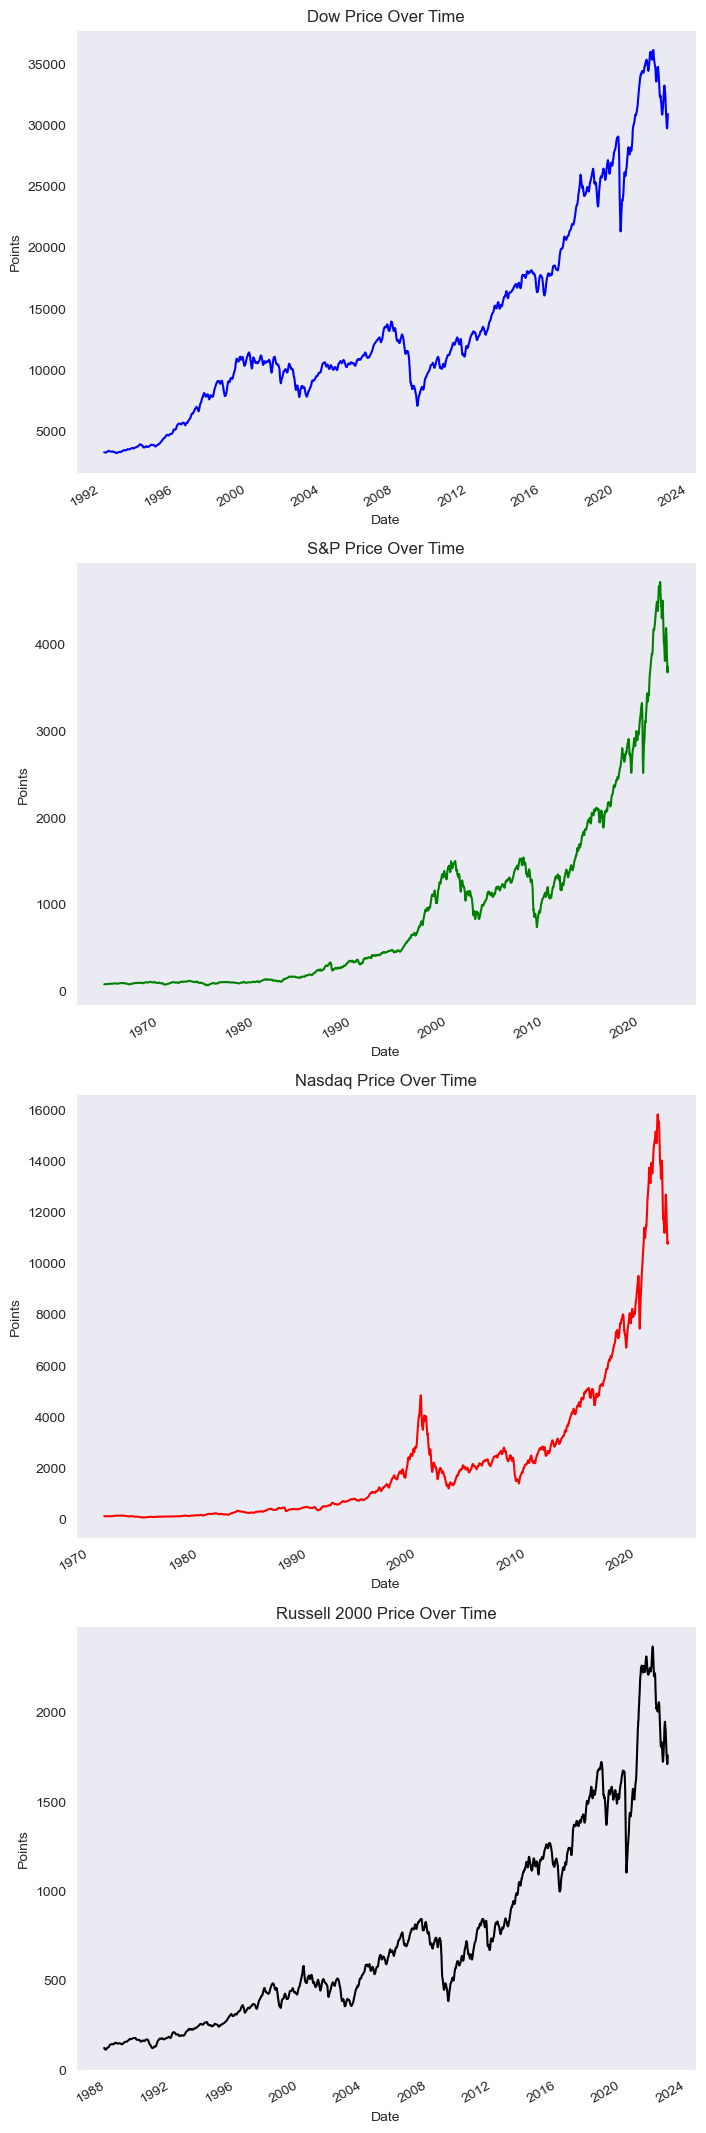

In [165]:
# Plots of the indices, smoothed using 20-day moving averages
fig, ax = plt.subplots(nrows=4, figsize=(8,30))

df[df["Ticker"] == "^DJI"]["Adj Close"].rolling(window=20).mean().plot(kind="line", color="blue", ax=ax[0])
ax[0].set_ylabel("Points")
ax[0].set_title("Dow Price Over Time")

df[df["Ticker"] == "^GSPC"]["Adj Close"].rolling(window=20).mean().plot(kind="line", color="green", ax=ax[1])
ax[1].set_ylabel("Points")
ax[1].set_title("S&P Price Over Time")

df[df["Ticker"] == "^IXIC"]["Adj Close"].rolling(window=20).mean().plot(kind="line", color="red", ax=ax[2])
ax[2].set_ylabel("Points")
ax[2].set_title("Nasdaq Price Over Time")

df[df["Ticker"] == "^RUT"]["Adj Close"].rolling(window=20).mean().plot(kind="line", color="black", ax=ax[3])
ax[3].set_ylabel("Points")
ax[3].set_title("Russell 2000 Price Over Time");

### Heatmap
The features exhibiting the strongest correlation with one another are all related to the specific price of the moment, and therefore, the strength of these correlations is not a surprise.

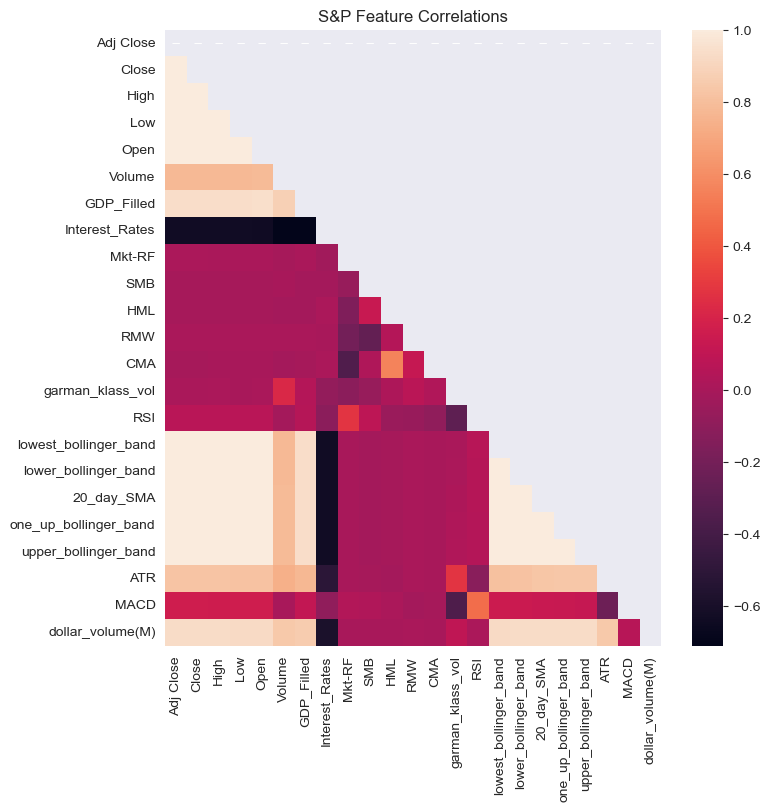

In [166]:
# Heatmap of S&P Correlations

fig, ax = plt.subplots(figsize=(8,8))
sns.set_style("dark")

mask = np.triu(np.ones_like(df.drop(columns=["Ticker", "one_months_later", 'three_months_later',\
                                             'six_months_later', 'twelve_months_later', 'One_Month_Positive',\
                                             'Three_Month_Positive','Six_Month_Positive','Twelve_Month_Positive',\
                                             'Quarter', 'Month', 'cycle_year', 'day_of_week', 'One_Month_Change', \
                                             'Three_Month_Change', 'Six_Month_Change','Twelve_Month_Change']).corr()))


sns.heatmap(df[df["Ticker"] == "^GSPC"].drop(columns=\
                ["Ticker", "one_months_later", 'three_months_later',\
                                             'six_months_later', 'twelve_months_later', 'One_Month_Positive',\
                                             'Three_Month_Positive','Six_Month_Positive','Twelve_Month_Positive',\
                                             'Quarter', 'Month', 'cycle_year', 'day_of_week', 'One_Month_Change', \
                                             'Three_Month_Change', 'Six_Month_Change','Twelve_Month_Change']).corr(),\
            mask=mask, annot=True, ax=ax)

ax.set_title("S&P Feature Correlations");

### Correlations to Target

In [167]:
df.reset_index(inplace=True)

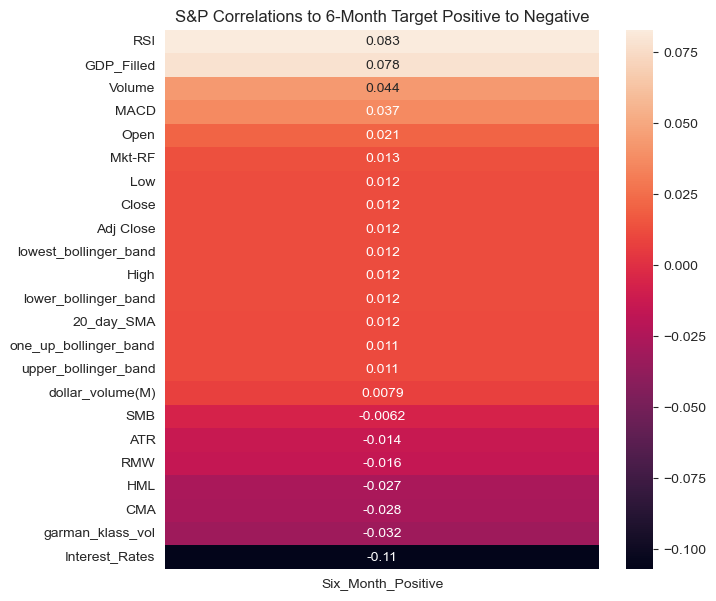

In [168]:
# S&P heatmap of correlations to target

fig, ax = plt.subplots(figsize=(7,7))
sns.set_style("dark")

sns.heatmap(df[df["Ticker"] == "^GSPC"].drop(columns=\
        ["Date", "Ticker", "one_months_later", 'three_months_later', 'six_months_later', 'twelve_months_later',\
         'One_Month_Positive', 'Three_Month_Positive', 'Twelve_Month_Positive', 'Quarter', 'Month',\
         'cycle_year', 'day_of_week', 'One_Month_Change', 'Three_Month_Change', 'Six_Month_Change',\
         'Twelve_Month_Change']).corr()[["Six_Month_Positive"]].sort_values(by="Six_Month_Positive", \
                                                                            ascending=False)[1:], annot=True, ax=ax)

ax.set_title("S&P Correlations to 6-Month Target Positive to Negative");

<hr style="border: 3px solid black">

# Missing Data
The missing data is exclusively Garman-Klass Vol. Other technical indicators have already been dropped which intially require a fixed window of time to generate. Also logically for recent history, it is impossible to label the outcomes of dates a year into the future that have yet to pass, so the data ends around Fall 2022. 

In [169]:
# Shows the amount of data to be dropped in order to consolidate everything into null-free data

df.shape[0], df.shape[0] - df.dropna().shape[0]

(43966, 4491)

### Setting up the df properly

In [170]:
df.set_index("Date", inplace=True)
df["day_of_week"] = df["day_of_week"].astype(str)
df["Quarter"] = df["Quarter"].astype(str)
df["Month"] = df["Month"].astype(str)
df["cycle_year"] = df['cycle_year'].astype(str)

In [171]:
# Unique DF's based on the TARGET time horizon 

one_month_df = df.drop(columns=["one_months_later", 'three_months_later', 'six_months_later', \
                                'twelve_months_later', 'Three_Month_Positive', 'Six_Month_Positive', \
                                'Twelve_Month_Positive', 'One_Month_Change', 'Three_Month_Change', \
                                'Six_Month_Change', 'Twelve_Month_Change'])


three_month_df = df.drop(columns=["one_months_later", 'three_months_later', 'six_months_later', \
                                  'twelve_months_later', 'One_Month_Positive', 'Six_Month_Positive', \
                                  'Twelve_Month_Positive', 'One_Month_Change', 'Three_Month_Change', \
                                'Six_Month_Change', 'Twelve_Month_Change'])


six_month_df = df.drop(columns=["one_months_later", 'three_months_later', 'six_months_later', 'twelve_months_later',\
                                'One_Month_Positive', 'Three_Month_Positive', 'Twelve_Month_Positive',\
                               'One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', 'Twelve_Month_Change'])


twelve_month_df = df.drop(columns=["one_months_later", 'three_months_later', 'six_months_later', \
                                   'twelve_months_later', 'One_Month_Positive', 'Three_Month_Positive', \
                                   'Six_Month_Positive', 'One_Month_Change', 'Three_Month_Change', \
                                'Six_Month_Change', 'Twelve_Month_Change'])

In [172]:
# For Verification

twelve_month_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43966 entries, 1964-02-06 to 2022-11-02
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ticker                 43966 non-null  object 
 1   Adj Close              43966 non-null  float64
 2   Close                  43966 non-null  float64
 3   High                   43966 non-null  float64
 4   Low                    43966 non-null  float64
 5   Open                   43966 non-null  float64
 6   Volume                 43966 non-null  float64
 7   GDP_Filled             43966 non-null  float64
 8   Interest_Rates         43966 non-null  float64
 9   Mkt-RF                 43966 non-null  float64
 10  SMB                    43966 non-null  float64
 11  HML                    43966 non-null  float64
 12  RMW                    43966 non-null  float64
 13  CMA                    43966 non-null  float64
 14  garman_klass_vol       39475 non-null

<hr style="border: 2px solid green">

### Re-Visiting Macro Data for Six Month Windows
To provide a bit of insight into how Macro Economic factors like GDP and federal interest rates impact stock returns, we will look at those features' characteristics when they appreciate over a 6 month period, and when they do not.

In [173]:
# Macro Statistics when indices increase in value over a 6 month period

df[df["Six_Month_Positive"] == 1][["GDP_Filled", "Interest_Rates"]].describe()

GDP_Filled  Interest_Rates
count  30033.000000    30033.000000
mean   10966.181758        3.571803
std     6467.165622        3.041161
min      669.822000       -0.050000
25%     6004.733000        0.330000
50%     9900.169000        3.640000
75%    16319.541000        5.310000
max    26408.405000       17.140000

##### GDP
`Mean GDP is slightly higher when indices increase in value`, and the `Median GDP is surprisingly LOWER` for times when indices increase in value `over 6 months` compared to when they do not.

##### Interest Rates 
Over 6 months, mean Interest Rates are `slightly lower when indices increase in value`, and `median interest rates are also slightly lower` when indices increase in value. 

In [174]:
# Macro Statistics when indices do not increase in value over a 6 month period 

df[df["Six_Month_Positive"] == 0][["GDP_Filled", "Interest_Rates"]].describe()

GDP_Filled  Interest_Rates
count  13933.000000    13933.000000
mean   10692.932357        4.071540
std     7092.895746        3.308188
min      697.319000       -0.010000
25%     4507.894000        1.590000
50%    10470.231000        3.850000
75%    14898.999000        5.980000
max    26408.405000       17.010000

In [175]:
six_month_df["Six_Month_Positive"].value_counts()

Six_Month_Positive
1.0    30033
0.0    13933
Name: count, dtype: int64

In [176]:
# It makes sense that Interest Rates would be negatively correlated, but it is a bit strange that GDP is also

six_month_df[["Six_Month_Positive", "GDP_Filled", "Interest_Rates"]].corr()[["GDP_Filled", "Interest_Rates"]][0:1]

GDP_Filled  Interest_Rates
Six_Month_Positive    0.019052       -0.074124

In [177]:
# The technical indicators exhibit the strongest correlation, but nothing to an objectionable level

print("Top 5 Most Positive Correlations")
six_month_df.drop(columns=["Ticker", "day_of_week", "Quarter", "Month", 'cycle_year']).corr()\
["Six_Month_Positive"].sort_values(ascending=False)[1:6]

Top 5 Most Positive Correlations


RSI           0.044623
GDP_Filled    0.019052
MACD          0.017134
Mkt-RF        0.010494
Open         -0.006430
Name: Six_Month_Positive, dtype: float64

In [178]:
# Entries per index -> going back to 1964 for the S&P, more recent for other indices
print(df.index.min())
df["Ticker"].value_counts()

1964-02-06 00:00:00


Ticker
^GSPC    14634
^IXIC    12891
^RUT      8759
^DJI      7682
Name: count, dtype: int64

<hr style="border: 2px solid purple">

# Breaking Data into Index Groups

### Dow Jones

In [179]:
# Different groups for each respective target time horizon

dow_one_month = one_month_df[one_month_df["Ticker"] == "^DJI"]
dow_three_month = three_month_df[three_month_df["Ticker"] == "^DJI"]
dow_six_month = six_month_df[six_month_df["Ticker"] == "^DJI"]
dow_twelve_month = twelve_month_df[twelve_month_df["Ticker"] == "^DJI"]

dow_one_month.shape, dow_twelve_month.shape

((7682, 29), (7682, 29))

### S&P 500

In [180]:
# Different groups for each respective target time horizon

SnP_one_month = one_month_df[one_month_df["Ticker"] == "^GSPC"]
SnP_three_month = three_month_df[three_month_df["Ticker"] == "^GSPC"]
SnP_six_month = six_month_df[six_month_df["Ticker"] == "^GSPC"]
SnP_twelve_month = twelve_month_df[twelve_month_df["Ticker"] == "^GSPC"]

SnP_one_month.shape, SnP_twelve_month.shape

((14634, 29), (14634, 29))

### Nasdaq Composite

In [181]:
# Different groups for each respective target time horizon

nasdaq_one_month = one_month_df[one_month_df["Ticker"] == "^IXIC"]
nasdaq_three_month = three_month_df[three_month_df["Ticker"] == "^IXIC"]
nasdaq_six_month = six_month_df[six_month_df["Ticker"] == "^IXIC"]
nasdaq_twelve_month = twelve_month_df[twelve_month_df["Ticker"] == "^IXIC"]

nasdaq_one_month.shape, nasdaq_twelve_month.shape

((12891, 29), (12891, 29))

### Russell 2000

In [182]:
# Different groups for each respective target time horizon

russell_one_month = one_month_df[one_month_df["Ticker"] == '^RUT']
russell_three_month = three_month_df[three_month_df["Ticker"] == '^RUT']
russell_six_month = six_month_df[six_month_df["Ticker"] == '^RUT']
russell_twelve_month = twelve_month_df[twelve_month_df["Ticker"] == '^RUT']

russell_one_month.shape, russell_twelve_month.shape

((8759, 29), (8759, 29))

# Class For Data Collection, pre-model Prep

In [183]:
# Creating the class that will store my data 
from sklearn.model_selection import TimeSeriesSplit

class Model():
    model_list = []
    model_df = pd.DataFrame(columns=['name','train_accuracy','train_prec','train_recall','train_f1','train_logloss',\
                                     'test_accuracy','test_prec','test_recall','test_f1','test_logloss', "AUC"])
    
    def __init__(self, name, model, X_train, X_test, y_train, y_test, threshold=.5):
        self.name = name
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.threshold = threshold
        
        # for cross val training
        tscv = TimeSeriesSplit(n_splits=5)
        
        # Collection of training attributes
        # f1, recall, precision add "_macro" for multi-class
        self.train_results = cross_validate(self.model, self.X_train, self.y_train, scoring=[
            'precision', 'accuracy', 'recall', 'f1', 'neg_log_loss'], cv=tscv, n_jobs=4, verbose=1)
        # Train metrics
        self.train_acc = np.mean(self.train_results['test_accuracy'])
        self.train_prec = np.mean(self.train_results['test_precision']) # add "_macro" for multi-class
        self.train_rec = np.mean(self.train_results['test_recall'])  # add "_macro" for multi-class
        self.train_f1 = np.mean(self.train_results['test_f1'])  # add "_macro" for multi-class
        self.train_logloss = -np.mean(self.train_results['test_neg_log_loss'])
        
        # Test metrics
        self.y_pred_proba = self.model.predict_proba(self.X_test)
        if self.threshold == .5:
            self.y_pred = self.model.predict(self.X_test)
        else:
            self.y_pred = (self.model.predict_proba(self.X_test)[:, 1] >= self.threshold).astype(int)
        
        self.test_score = model.score(self.X_test, self.y_test)
        # average = "macro" for multi-class
        self.test_recall = recall_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        # average = "macro" for multi-class
        self.test_prec = precision_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        self.test_log_loss = log_loss(self.y_test, self.y_pred_proba)
        # average = "macro" for multi-class
        self.test_f1 = f1_score(self.y_test, self.y_pred, average='binary', zero_division=0)
        
        # AUC metrics -> Remove when we get to multi-class
        self.auc = roc_auc_score(self.y_test, self.y_pred_proba[:,1])
        
        # Add model object to the class data container for access within the notebook
        Model.model_list.append(self)
        
        # Dictionary containing all of the metrics to add to the dataframe
        self.attributes = {'name':self.name, 'train_accuracy':self.train_acc, "train_prec": self.train_prec,
                           "train_recall": self.train_rec, "train_f1": self.train_f1, \
                           "train_logloss": self.train_logloss, \
                          'test_accuracy':self.test_score, "test_prec": self.test_prec,
                           "test_recall": self.test_recall, "test_f1": self.test_f1, \
                           "test_logloss": self.test_log_loss, "AUC":self.auc}
        
        # Add the metrics to the class dataframe
        Model.model_df.loc[len(Model.model_df)] = self.attributes
        
        
        
    # Roc Curve plot method -> needs to be removed for multi-class
    def roc_curve(self):
        # Create the plot
        sns.set_style("dark")
        fig, ax = plt.subplots(figsize=(6,6))
        # get the predict_proba values
        y_hat_hd = self.y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr, label=f"{self.name} | AUC: {self.auc:.2f})")
        # Y-axis
        ax.set_yticks([0,.2,.4,.6,.8,1])
        ax.set_yticklabels([0,20,40,60,80,100])
        ax.set_ylabel("True Positive %")
        # X-axis
        ax.set_xticks([0,.2,.4,.6,.8,1])
        ax.set_xticklabels([0,20,40,60,80,100])
        ax.set_xlabel("False Positive %")
        ax.set_title(f"{self.name} ROC Curve", fontsize=20)
        plt.grid(False);
        
        
    def compare_roc_curve(self):
        sns.set_style("dark")
        # Color Palette
        colors = sns.color_palette("Paired", n_colors=30)
        # Create the plot
        fig, ax = plt.subplots(figsize=(7,7))
        for i in range(len(Model.model_list)):
            # get the predict_proba values
            y_hat_hd = Model.model_list[i].y_pred_proba[:, 1]

            # Get the FPR and TPR data
            fpr, tpr, thresholds = roc_curve(Model.model_list[i].y_test, y_hat_hd)
            # Plot the actual graph
            ax.plot(fpr, tpr, color=colors[i], label=f'{Model.model_list[i].name} | AUC: {Model.model_list[i].auc:.2f})')
        
        ax.set_title(f"Comparison of ROC Curve")
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right')
        plt.grid(False);
    
    
    def confusion_matrix(self):
        sns.set_style('white')
        # Confusion Matrix Plot
        fig, ax = plt.subplots(figsize=(6,6))
        self.cm = ConfusionMatrixDisplay.from_predictions(y_true=self.y_test, y_pred=self.y_pred, ax=ax)
        plt.title(f'Confusion Matrix for "{self.name}" Test Data');
    
    
    def __str__(self):
      return f"Model name: {self.name}"

# Dummy Model and Train Test Split

Now that the data has been split into 16 total segments, both by target and then subsequently by index, we can begin to establish a dummy baseline model for classification, and then build out sklearn Pipelines to hand our data pre processing and avoid any kind of data leakage. As you can see, the longer the time horizon, the more likely the most frequently occuring class would be the correct prediction. Given that, I will start with the 12 Month target groups, and go backward from there.

In [184]:
# Showing the ratios of gains to losses at different timeframes

print(one_month_df["One_Month_Positive"].value_counts().rename({1:"Profitable", 0:"Not Profitable"}), 
      three_month_df["Three_Month_Positive"].value_counts().rename({1:"Profitable", 0:"Not Profitable"}), \
      six_month_df["Six_Month_Positive"].value_counts().rename({1:"Profitable", 0:"Not Profitable"}), 
      twelve_month_df["Twelve_Month_Positive"].value_counts().rename({1:"Profitable", 0:"Not Profitable"}))

One_Month_Positive
Profitable        26891
Not Profitable    17075
Name: count, dtype: int64 Three_Month_Positive
Profitable        28489
Not Profitable    15477
Name: count, dtype: int64 Six_Month_Positive
Profitable        30033
Not Profitable    13933
Name: count, dtype: int64 Twelve_Month_Positive
Profitable        32561
Not Profitable    11405
Name: count, dtype: int64


### Large Cell with commented out groups to avoid having to constantly re-enter the code

In [185]:
# Creating X and y groups

                # DOW GROUPS

# X = dow_one_month.drop(columns=["Ticker", "One_Month_Positive"])
# y = dow_one_month["One_Month_Positive"]

# X = dow_three_month.drop(columns=["Ticker", "Three_Month_Positive"])
# y = dow_three_month["Three_Month_Positive"]

# X = dow_six_month.drop(columns=["Ticker", "Six_Month_Positive"])
# y = dow_six_month["Six_Month_Positive"]

X = dow_twelve_month.drop(columns=["Ticker", "Twelve_Month_Positive"])
y = dow_twelve_month["Twelve_Month_Positive"]


                # S&P GROUPS

# X = SnP_one_month.drop(columns=["Ticker", "One_Month_Positive"])
# y = SnP_one_month["One_Month_Positive"]

# X = SnP_three_month.drop(columns=["Ticker", "Three_Month_Positive"])
# y = SnP_three_month["Three_Month_Positive"]

# X = SnP_six_month.drop(columns=["Ticker", "Six_Month_Positive"])
# y = SnP_six_month["Six_Month_Positive"]

# X = SnP_twelve_month.drop(columns=["Ticker", "Twelve_Month_Positive"])
# y = SnP_twelve_month["Twelve_Month_Positive"]


                # NASDAQ GROUPS

# X = nasdaq_one_month.drop(columns=["Ticker", "One_Month_Positive"])
# y = nasdaq_one_month["One_Month_Positive"]

# X = nasdaq_three_month.drop(columns=["Ticker", "Three_Month_Positive"])
# y = nasdaq_three_month["Three_Month_Positive"]

# X = nasdaq_six_month.drop(columns=["Ticker", "Six_Month_Positive"])
# y = nasdaq_six_month["Six_Month_Positive"]

# X = nasdaq_twelve_month.drop(columns=["Ticker", "Twelve_Month_Positive"])
# y = nasdaq_twelve_month["Twelve_Month_Positive"]


                # RUSSELL GROUPS

# X = russell_one_month.drop(columns=["Ticker", "One_Month_Positive"])
# y = russell_one_month["One_Month_Positive"]

# X = russell_three_month.drop(columns=["Ticker", "Three_Month_Positive"])
# y = russell_three_month["Three_Month_Positive"]

# X = russell_six_month.drop(columns=["Ticker", "Six_Month_Positive"])
# y = russell_six_month["Six_Month_Positive"]

# X = russell_twelve_month.drop(columns=["Ticker", "Twelve_Month_Positive"])
# y = russell_twelve_month["Twelve_Month_Positive"]

In [186]:
# 3.5 to 1 ratio for Dow 12 Month Return, a little bit imbalanced but not horrendous

y.value_counts()

Twelve_Month_Positive
1.0    5992
0.0    1690
Name: count, dtype: int64

In [190]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7682 entries, 1992-02-06 to 2022-11-02
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Adj Close              7682 non-null   float64
 1   Close                  7682 non-null   float64
 2   High                   7682 non-null   float64
 3   Low                    7682 non-null   float64
 4   Open                   7682 non-null   float64
 5   Volume                 7682 non-null   float64
 6   GDP_Filled             7682 non-null   float64
 7   Interest_Rates         7682 non-null   float64
 8   Mkt-RF                 7682 non-null   float64
 9   SMB                    7682 non-null   float64
 10  HML                    7682 non-null   float64
 11  RMW                    7682 non-null   float64
 12  CMA                    7682 non-null   float64
 13  garman_klass_vol       7682 non-null   float64
 14  RSI                    7682 non-null  

<hr style="border: 4px solid royalblue">

# Train Test Split

In [191]:
# The actual data split, sequential due to the time series nature so shuffle=False

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1313, shuffle=False, test_size=.2)

In [192]:
# Sequential Train Test Split
X_train.index.min(), X_train.index.max(), X_test.index.min(), X_test.index.max()

(Timestamp('1992-02-06 00:00:00'),
 Timestamp('2016-09-08 00:00:00'),
 Timestamp('2016-09-09 00:00:00'),
 Timestamp('2022-11-02 00:00:00'))

# Dummy Model

Because the dummy is based on our target variable, we don't yet need to worry about scaling our data.

In [193]:
dummy = DummyClassifier(strategy="most_frequent")

In [194]:
dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [203]:
dummy_model_first = Model("Dummy Model", dummy, X_train, X_test, y_train, y_test, threshold=.5)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


In [204]:
Model.model_df

name  train_accuracy  train_prec  train_recall  \
0  Logistic Regression 12-Month Dow        0.683594    0.854941         0.732   
1                       Dummy Model        0.749219    0.749219         1.000   

   train_f1  train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
0  0.720464       1.960234       0.287573   1.000000     0.045336  0.086739   
1  0.847737       9.039072       0.746259   0.746259     1.000000  0.854694   

   test_logloss       AUC  
0     13.978651  0.723824  
1      9.145755  0.500000

In [67]:
"Dummy Test Score:", dummy_model_first.test_score, "*"*80, y_test.value_counts(normalize=True)

('Dummy Test Score:',
 0.7462589459986988,
 '********************************************************************************',
 Twelve_Month_Positive
 1.0    0.746259
 0.0    0.253741
 Name: proportion, dtype: float64)

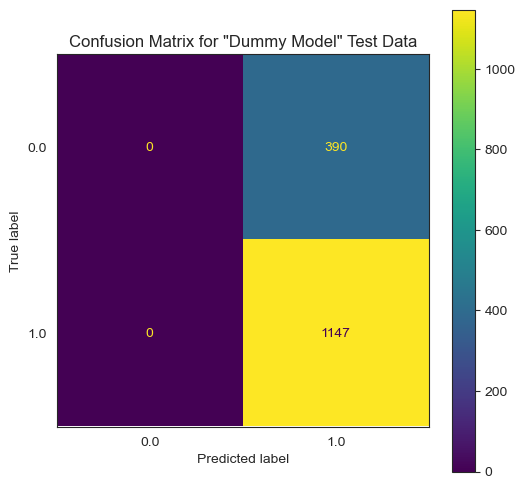

In [196]:
dummy_model_first.confusion_matrix()

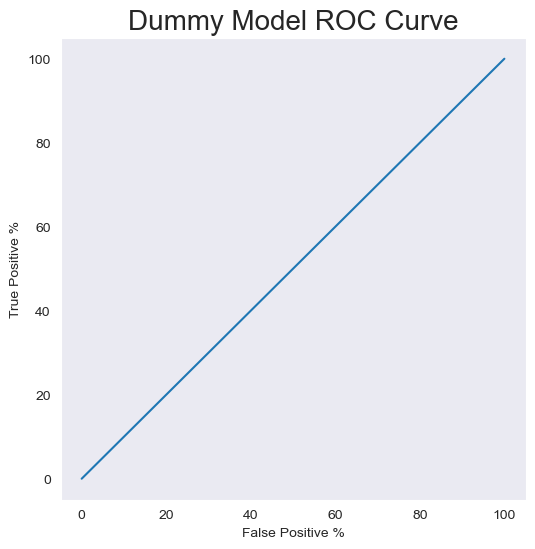

In [197]:
dummy_model_first.roc_curve()

<hr style="border: 2px solid blue;">

# Pipelines

Now that I have established a dummy baseline for our predictions, I can begin to iterate through different models using sklearn pipelines. Because my data is composed of continuous numeric values and categorical features, I will  need to `SCALE` and `OneHotEncode` the data before processing it. I will use a variety of different models in an attempt to best predict the qualitative performance of the market on different time horizons.

In [198]:
X_train.head(2)

Adj Close        Close         High          Low         Open  \
Date                                                                          
1992-02-06  3255.600098  3255.600098  3265.649902  3238.600098  3257.600098   
1992-02-07  3225.399902  3225.399902  3269.899902  3207.959961  3255.600098   

                Volume  GDP_Filled  Interest_Rates  Mkt-RF     SMB     HML  \
Date                                                                         
1992-02-06  20490000.0    6363.102            3.81  0.0004  0.0029  0.0061   
1992-02-07  21660000.0    6363.102            3.74 -0.0059  0.0044  0.0024   

               RMW     CMA  garman_klass_vol        RSI  \
Date                                                      
1992-02-06 -0.0017  0.0024          0.000034  56.552121   
1992-02-07  0.0003  0.0031          0.000149  50.814965   

            lowest_bollinger_band  lower_bollinger_band   20_day_SMA  \
Date                                                                   
1992-02-06            3196.798777           3218.979400  3241.160022   
1992-02-07            3201.665597           3222.060307  3242.455017   

            one_up_bollinger_band  upper_bollinger_band        ATR       MACD  \
Date                                                                            
1992-02-06            3263.340644           3285.521267  35.828285  13.500840   
1992-02-07            3262.849727           3283.244437  38.011273  10.948214   

            dollar_volume(M) Quarter Month cycle_year day_of_week  
Date                                                               
1992-02-06        66707.2460       1     2          4    Thursday  
1992-02-07        69862.1619       1     2          4      Friday

### Sub-Pipes/Column Transformer

In [375]:
# Sub-pipe for numeric transformation
num_pipe = Pipeline(steps=[
    ('knn', KNNImputer(add_indicator=False)),
    ("ss", StandardScaler())
])

# Sub-pipe for categorical transformation
cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Column Transformer object to be given to the ultimate pipeline model
ct = ColumnTransformer(transformers=[
    ("num_pipe", num_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
])

In [217]:
# Pipeline creation -> I will leave the iterations of the models commented out near the top

                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    # RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
    # ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=None, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

    # XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)


pipeline = Pipeline(steps=[
    ('ct', ct),
    ('model', KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
                                metric='minkowski', metric_params=None, n_jobs=4)
    
    )])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('knn',
                                                                   KNNImputer(add_indicator=True)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8111736d40>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8111737e20>)])),
                ('model', KNeighborsClassifier(n_jobs=4))])

In [219]:
# Collection of class objects


# log_reg1 = Model("Logistic Regression 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)
# rf1 = Model("Random Forest 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)
# ET1 = Model("Extra Trees 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)
# ada1 = Model("AdaBoost 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)
# XGB1 = Model("XGBoost 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)
# KNN1 = Model("K Nearest Neighbors 12-Month Dow", pipeline, X_train, X_test, y_train, y_test)

Model.model_df.sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  train_recall  \
0  Logistic Regression 12-Month Dow        0.683594    0.854941      0.732000   
6  K Nearest Neighbors 12-Month Dow        0.658984    0.831777      0.654924   
3          Extra Trees 12-Month Dow        0.636914    0.855598      0.665313   
1                       Dummy Model        0.749219    0.749219      1.000000   
4             AdaBoost 12-Month Dow        0.643164    0.775691      0.579941   
2        Random Forest 12-Month Dow        0.528906    0.872591      0.540391   
5              XGBoost 12-Month Dow        0.643164    0.831283      0.714542   

   train_f1  train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
0  0.720464       1.960234       0.287573   1.000000     0.045336  0.086739   
6  0.711420       6.757966       0.398829   0.911439     0.215344  0.348378   
3  0.676741       1.655228       0.744307   0.778846     0.918047  0.842737   
1  0.847737       9.039072       0.746259   0.746259     1.000000  0.854694   
4  0.605361       0.685775       0.746259   0.746259     1.000000  0.854694   
2  0.545309       1.796611       0.543917   0.728484     0.619878  0.669807   
5  0.703865       1.734609       0.394275   0.662651     0.383609  0.485919   

   test_logloss       AUC  
0     13.978651  0.723824  
6      1.284476  0.602717  
3      0.566689  0.627260  
1      9.145755  0.500000  
4      0.592272  0.444427  
2      0.637578  0.538532  
5      2.527285  0.413137

### Initial Observations:
Accuracy appears to be an unattainable metric upon which to improve. In lieu of pursuing accuracy, pursuing precision makes the most sense, given that when we "buy", we want the highest likelihood that those signals result in appreciation of value. `The precision scores for logistic regression and KNN are both significant improvements` on the dummy model, whereas `their respective accuracies are MUCH WORSE.` ExtraTrees also shows some promise, given its comparable performance with the dummy in terms of accuracy and precision. 

### Function for conducting grid searches on tree based models

In [457]:
def best_etc_grid(estimator, model_type, sector_name, time_period):
    # Parameters to search through
    tscv = TimeSeriesSplit(n_splits=5)

    params = {"model__criterion": ['gini', 'entropy', 'log_loss'],
             'model__max_depth': [None, 7, 5],
             'model__max_features': ["auto", "sqrt", "log2"],
             "model__ccp_alpha": [0, .001, .01, .1],
         }
    precision_scorer = make_scorer(precision_score, zero_division=0)
# Fitting the gridsearch model 

    grid = GridSearchCV(estimator=estimator, param_grid=params, n_jobs=6, cv=tscv, verbose=1, scoring=precision_scorer)
    grid.fit(X_train, y_train)

# Adding GridSearchCV searched model
    print(grid.best_params_)

    return model_type(f"Grid Searched Tree Model, {time_period}-Month {sector_name}",\
                      grid.best_estimator_, X_train, X_test, y_train, y_test)


In [222]:
# using the function to grid search and instantiate an object

grid_etc_1 = best_etc_grid(estimator=ET1.model, model_type=Model, sector_name="Dow", time_period=12, )

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0.001, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


In [458]:
def best_XGB_grid(estimator, model_class_type, sector_name, time_period):
    tscv = TimeSeriesSplit(n_splits=5)
    
    params_XLC = {
        'model__booster':['gbtree', 'gblinear', "dart"],
        'model__max_depth':[5, 6, 8, 10],
        'model__sampling_method': ['uniform', 'gradient_based'],
        'model__n_estimators': [100, 150, 200]
    }
    
    precision_scorer = make_scorer(precision_score, zero_division=0)
    
# Fitting the gridsearch model 

    grid = GridSearchCV(estimator=estimator, param_grid=params_XLC, n_jobs=6, cv=tscv, verbose=1, scoring=precision_scorer)
    grid.fit(X_train, y_train)

# Adding GridSearchCV searched model
    print(grid.best_params_)

    return model_class_type(f"Grid Searched XGBoost, {time_period}-Month {sector_name}",\
                      grid.best_estimator_, X_train, X_test, y_train, y_test)

In [455]:
def best_ada_grid(estimator, model_class_type, sector_name, time_period):
    tscv = TimeSeriesSplit(n_splits=5)

    params = {"model__algorithm": ['SAMME', 'SAMME.R'],
             'model__estimator': [DecisionTreeClassifier(), LogisticRegression(), KNeighborsClassifier()],
             "model__learning_rate": [0.5, 1.0, 2.0, 5.0],
              "model__n_estimators":[50, 75, 100, 150]
                }
    precision_scorer = make_scorer(precision_score, zero_division=0)
    
# Fitting the gridsearch model 

    grid = GridSearchCV(estimator=estimator, param_grid=params, n_jobs=6, cv=tscv, verbose=1, scoring=precision_scorer)
    grid.fit(X_train, y_train)

# Adding GridSearchCV searched model
    print(grid.best_params_)

    return model_class_type(f"Grid Searched AdaBoost, {time_period}-Month {sector_name}",\
                      grid.best_estimator_, X_train, X_test, y_train, y_test)

In [467]:
def best_logreg_search(estimator, model_type, sector_name, time_period):
    tscv = TimeSeriesSplit(n_splits=5)
    
    params = {"model__C": [1.0, 2.0, 0.5, .25],
                "model__class_weight":[{0:1, 1:1}, {0:1, 1:2}],
                'model__max_iter':[100, 200, 300],
                'model__solver':['lbfgs', 'liblinear'],
                'model__tol':[.0001,.001,.01]}
    
    precision_scorer = make_scorer(precision_score, zero_division=0)
                
    grid = GridSearchCV(estimator=estimator, param_grid=params, n_jobs=6, cv=tscv, verbose=1, scoring=precision_scorer)
    
    grid.fit(X_train, y_train)
    
    print(grid.best_params_)

    return model_type(f"Grid Searched LR, {time_period}-Month {sector_name}",\
                      grid.best_estimator_, X_train, X_test, y_train, y_test)

In [226]:
# ada_grid1 = best_ada_grid(ada1.model, Model, "Dow", 12)

In [456]:
def best_KNN_search(estimator, model_class_type, sector_name, time_period):
    tscv = TimeSeriesSplit(n_splits=5)
    
    params = {'model__algorithm':['auto', 'ball_tree', 'kd_tree'],
            'model__leaf_size':[25,30,35],
            'model__n_neighbors':[4,5,6,7],
            'model__p':[1,2],
            'model__weights':['uniform', 'distance']}
    precision_scorer = make_scorer(precision_score, zero_division=0)
    
    grid = GridSearchCV(estimator=estimator, param_grid=params, n_jobs=6, cv=tscv, verbose=1, scoring=precision_scorer)
    grid.fit(X_train, y_train)

# Adding GridSearchCV searched model
    print(grid.best_params_)

    return model_class_type(f"Grid Searched KNN, {time_period}-Month {sector_name}",\
                      grid.best_estimator_, X_train, X_test, y_train, y_test)

In [459]:
# Gridsearch for the KNN model
knn_grid = best_KNN_search(KNN1.model, Model, "Dow KNN", 12)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'model__algorithm': 'auto', 'model__leaf_size': 25, 'model__n_neighbors': 6, 'model__p': 2, 'model__weights': 'uniform'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.9s finished


In [239]:
Model.model_df.sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
0          Logistic Regression 12-Month Dow        0.683594    0.854941   
8      Grid Searched AdaBoost, 12-Month Dow        0.627148    0.840793   
6          K Nearest Neighbors 12-Month Dow        0.658984    0.831777   
9  Grid Searched AdaBoost, 12-Month Dow KNN        0.639844    0.840066   
3                  Extra Trees 12-Month Dow        0.636914    0.855598   
7    Grid Searched Tree Model, 12-Month Dow        0.624023    0.853422   
1                               Dummy Model        0.749219    0.749219   
4                     AdaBoost 12-Month Dow        0.643164    0.775691   
2                Random Forest 12-Month Dow        0.528906    0.872591   
5                      XGBoost 12-Month Dow        0.643164    0.831283   

   train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
0      0.732000  0.720464       1.960234       0.287573   1.000000   
8      0.615627  0.605328       0.678889       0.273910   1.000000   
6      0.654924  0.711420       6.757966       0.398829   0.911439   
9      0.604937  0.678924       6.337333       0.364997   0.897674   
3      0.665313  0.676741       1.655228       0.744307   0.778846   
7      0.651571  0.666470       1.729951       0.744307   0.772793   
1      1.000000  0.847737       9.039072       0.746259   0.746259   
4      0.579941  0.605361       0.685775       0.746259   0.746259   
2      0.540391  0.545309       1.796611       0.543917   0.728484   
5      0.714542  0.703865       1.734609       0.394275   0.662651   

   test_recall   test_f1  test_logloss       AUC  
0     0.045336  0.086739     13.978651  0.723824  
8     0.027027  0.052632      0.703935  0.724061  
6     0.215344  0.348378      1.284476  0.602717  
9     0.168265  0.283407      1.034505  0.621733  
3     0.918047  0.842737      0.566689  0.627260  
7     0.931125  0.844603      0.540395  0.658751  
1     1.000000  0.854694      9.145755  0.500000  
4     1.000000  0.854694      0.592272  0.444427  
2     0.619878  0.669807      0.637578  0.538532  
5     0.383609  0.485919      2.527285  0.413137

### Evaluation
Logistic Regression and AdaBoost both boast 100% precision, but LR made only 52 positive predictions out of 1537 total days of observations, and the AdaBoost model made even fewer "buy" predictions. These models are not practically useful due to the infrequency of "buys"

(None, None, None)

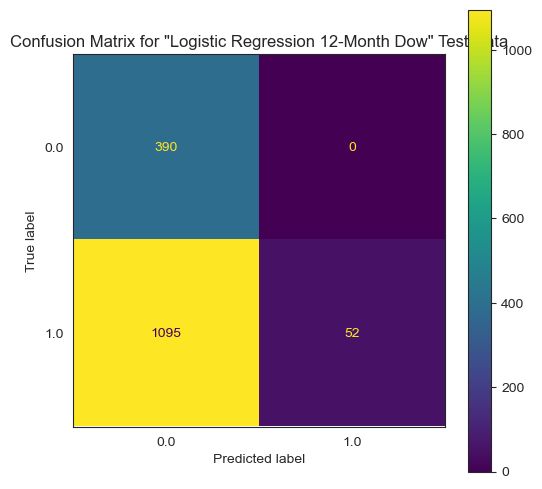

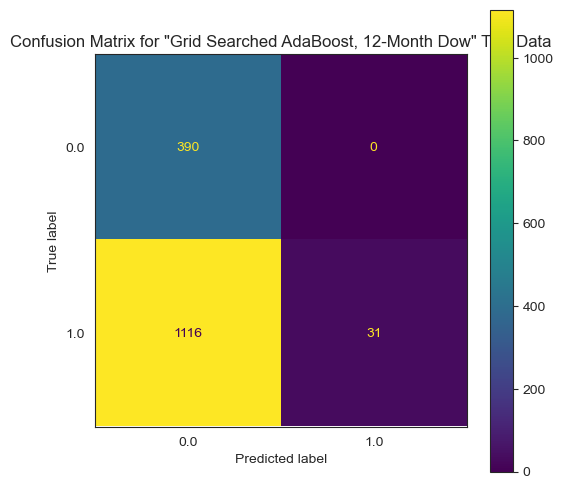

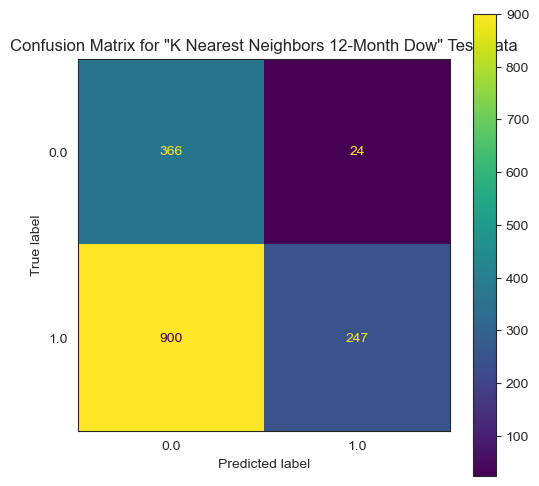

In [246]:
# 100% precision, but only 52 positive predictions out of 1537 total days of observations
log_reg1.confusion_matrix(), ada_grid1.confusion_matrix(), KNN1.confusion_matrix()

### Results of the Most Practically Useful Model

One_Month_Change  Three_Month_Change  Six_Month_Change  \
count        271.000000          271.000000        271.000000   
mean           0.029689            0.066789          0.107811   
std            0.058765            0.086277          0.106915   
min           -0.187707           -0.273906         -0.310132   
25%           -0.002877            0.021510          0.062694   
50%            0.029777            0.081489          0.126903   
75%            0.056982            0.107502          0.159785   
max            0.264810            0.406852          0.439503   

       Twelve_Month_Change  
count           271.000000  
mean              0.211214  
std               0.161018  
min              -0.075477  
25%               0.080859  
50%               0.220399  
75%               0.287461  
max               0.743937

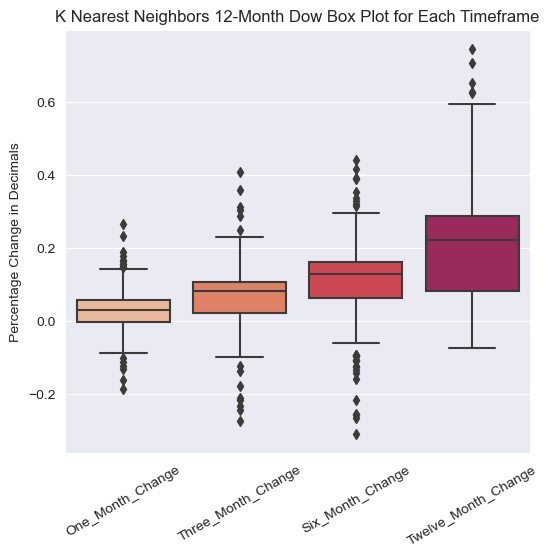

In [252]:
# Shows the results for "buy" predictions of the 12-Month model
describe_predictions(KNN1, "^DJI", df=df, cat=1, box=True)

### ROC curves
These curves show the relationship between true positives and false positives at different classification thresholds. These curves are a very sloppy bunch, indicating that they do a poor job of predicting the data. 

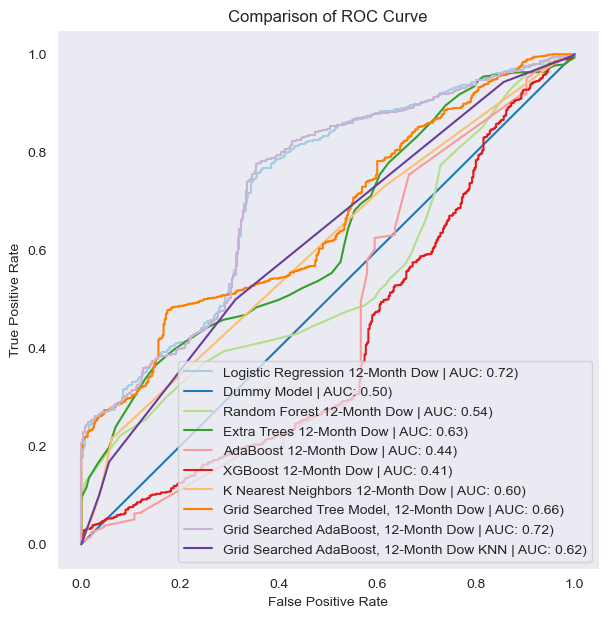

In [240]:
# Comparing ROC CURVES
log_reg1.compare_roc_curve()

### Feature Importances from the Best Tree Model

In [292]:
# All importances 
features_from_trees(ET1)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.12125575795897403)
('Interest_Rates', 0.09920452629278932)
('ATR', 0.04640420674285076)
('upper_bollinger_band', 0.043800295398101284)
('lower_bollinger_band', 0.04311114605053667)


Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
0   0.040632  0.037007  0.042715  0.037906  0.031394  0.022302    0.121256   

   Interest_Rates    Mkt-RF       SMB       HML       RMW       CMA  \
0        0.099205  0.005304  0.005326  0.007362  0.007724  0.010244   

   garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
0          0.006258  0.015604                0.03996              0.043111   

   20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
0    0.041155               0.031843                0.0438  0.046404   

       MACD  ...  Quarter_4   Month_1  Month_10  Month_11  Month_12   Month_2  \
0  0.017998  ...   0.014279  0.005447  0.005716  0.003006  0.005145  0.004382   

    Month_3  Month_4   Month_5  Month_6   Month_7   Month_8   Month_9  \
0  0.004801  0.00659  0.006236  0.00469  0.008413  0.004068  0.009018   

   cycle_year_1  cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
0      0.016851      0.030314      0.027356      0.023366            0.002242   

   day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
0             0.00226              0.002095             0.002078   

   day_of_week_Wednesday  
0               0.002048  

[1 rows x 48 columns]

### Notes:
Logistic Regression and KNN both had extremely high precision. Given that accuracy is so poor in general, focusing on precision will be appropriate, given that we are interested in "buying" and having the asset's value increase. Early indications are that KNN might be a better choice because LogisticRegression was entirely too selective. 

<hr style="border: 2px solid red;">

# Functions to expedite the process

In [336]:
def dummy_model(model_type, sector_name, time_period):
    # Dummy Classifier for new time horizon
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)


    # CHANGE THE CLASS EACH TIME IT'S APPROPRIATE
    return model_type(f"Dummy {sector_name} {str(time_period)}-Month", dummy, X_train, X_test, y_train, y_test)


def l_regr(model_type, sector_name, time_period, threshold=.5):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
                                    fit_intercept=True)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Logistic Regression {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test, threshold=threshold)



def r_forest(model_type, sector_name, time_period, threshold=.5):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
                                  max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
                                  oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Random Forest {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test, threshold=threshold)
    

def extra_trees(model_type, sector_name, time_period, threshold=.5):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
    min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
    bootstrap=False,oob_score=False, n_jobs=None, random_state=13, verbose=0, warm_start=False, class_weight=None, \
    ccp_alpha=0.0, max_samples=None)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Extra Trees {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test, threshold=threshold)
    

def x_g_b(model_type, sector_name, time_period, threshold=.5):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
                         tree_method="auto", n_jobs=4, random_state=13)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} XGBoost {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test, threshold=threshold)


def knn(model_type, sector_name, time_period, threshold=.5):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
                                metric='minkowski', metric_params=None, n_jobs=4)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} KNN {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test, threshold=threshold)



def ada(model_type, sector_name, time_period, threshold=.5):
    pipeline = Pipeline(steps=[
        ('ct', ct),
        ('model', AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
                                  random_state=13, base_estimator='deprecated')

        )])

    pipeline.fit(X_train, y_train)
    return model_type(f"{sector_name} ADA {str(time_period)}-Month", pipeline,\
                     X_train, X_test, y_train, y_test, threshold=threshold)

### Adjusting the Classification Threshold

In [262]:
# knn_threshold = knn(Model, "Dow Thresh", 12, threshold=.7)

Model.model_df.sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
0           Logistic Regression 12-Month Dow        0.683594    0.854941   
8       Grid Searched AdaBoost, 12-Month Dow        0.627148    0.840793   
6           K Nearest Neighbors 12-Month Dow        0.658984    0.831777   
9   Grid Searched AdaBoost, 12-Month Dow KNN        0.639844    0.840066   
10                   Dow Thresh KNN 12-Month        0.658984    0.831777   
3                   Extra Trees 12-Month Dow        0.636914    0.855598   
7     Grid Searched Tree Model, 12-Month Dow        0.624023    0.853422   
1                                Dummy Model        0.749219    0.749219   
4                      AdaBoost 12-Month Dow        0.643164    0.775691   
2                 Random Forest 12-Month Dow        0.528906    0.872591   
5                       XGBoost 12-Month Dow        0.643164    0.831283   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
0       0.732000  0.720464       1.960234       0.287573   1.000000   
8       0.615627  0.605328       0.678889       0.273910   1.000000   
6       0.654924  0.711420       6.757966       0.398829   0.911439   
9       0.604937  0.678924       6.337333       0.364997   0.897674   
10      0.654924  0.711420       6.757966       0.398829   0.892617   
3       0.665313  0.676741       1.655228       0.744307   0.778846   
7       0.651571  0.666470       1.729951       0.744307   0.772793   
1       1.000000  0.847737       9.039072       0.746259   0.746259   
4       0.579941  0.605361       0.685775       0.746259   0.746259   
2       0.540391  0.545309       1.796611       0.543917   0.728484   
5       0.714542  0.703865       1.734609       0.394275   0.662651   

    test_recall   test_f1  test_logloss       AUC  
0      0.045336  0.086739     13.978651  0.723824  
8      0.027027  0.052632      0.703935  0.724061  
6      0.215344  0.348378      1.284476  0.602717  
9      0.168265  0.283407      1.034505  0.621733  
10     0.115955  0.205247      1.284476  0.602717  
3      0.918047  0.842737      0.566689  0.627260  
7      0.931125  0.844603      0.540395  0.658751  
1      1.000000  0.854694      9.145755  0.500000  
4      1.000000  0.854694      0.592272  0.444427  
2      0.619878  0.669807      0.637578  0.538532  
5      0.383609  0.485919      2.527285  0.413137

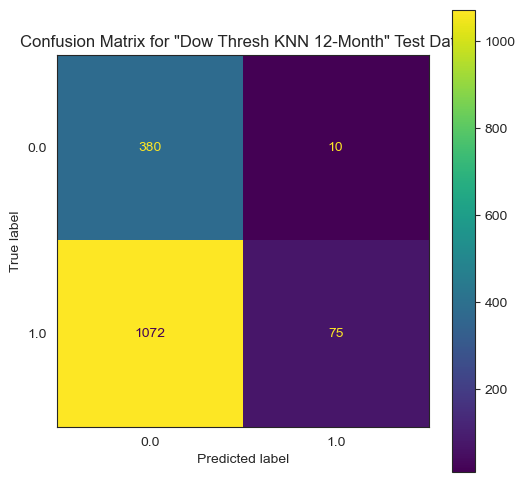

In [260]:
knn_threshold2.confusion_matrix()

### Final Thoughts:
Even after manipulating the classification thresholds for the models, precision did not improve. IN FACT, the test precision actually got worse by 2%, meaning that some key features that the model was latching onto were clearly misleading the model. It seems as though the base KNN model might provide the best overall profile, given precision is our target metric. That being said, the training precision was appreciably worse than the test precision, so these may be noisy results due to relative lack of sufficient data. 

<hr style="border: 4px solid blue">

# 1 Month Dow

Now that we began with the 12 Month Dow modeling, we will iterate through every permutation of index and targets and see how well we do with our models.

### df objects to streamline modeling

In [263]:
# DFs for each ETF

# DOW
dow_df = df[df["Ticker"]== "^DJI"]

# S&P
sp_df = df[df["Ticker"]== "^GSPC"]

# Nasdac
nas_df = df[df["Ticker"]== "^IXIC"]

# Russel
rus_df = df[df["Ticker"]== "^RUT"]

In [277]:
# Create variables

X_train, X_test, y_train, y_test = select_data(dow_df, "One")

# Create Model Objects

# dummy_D_1_month = dummy_model(Model, "Dow", 1)
# logreg_D_1_month = l_regr(Model, "Dow", 1)
# knn_D_1_month = knn(Model, "Dow", 1)
# rfc_D_1_month = r_forest(Model, "Dow", 1)
# ada_D_1_month = ada(Model, "Dow", 1)
# etc_D_1_month = extra_trees(Model, "Dow", 1)
# XGBoost_D_1_month = x_g_b(Model, "Dow", 1)

# grid_D_1_month = best_etc_grid(estimator=rfc_D_1_month.model, model_type=Model, sector_name="Dow", time_period=1)
# knngrid_D_1_month = best_KNN_search(knn_D_1_month.model, Model, "Dow-KNNGrid", 1)

Model.model_df.iloc[11:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
19  Grid Searched KNN, 1-Month Dow-KNNGrid        0.560625    0.672413   
14               Dow Random Forest 1-Month        0.503542    0.656345   
13                         Dow KNN 1-Month        0.525208    0.621172   
11                       Dummy Dow 1-Month        0.614375    0.614375   
18   Grid Searched Tree Model, 1-Month Dow        0.598125    0.685453   
17                     Dow XGBoost 1-Month        0.510417    0.646263   
16                 Dow Extra Trees 1-Month        0.514792    0.655944   
15                         Dow KNN 1-Month        0.530625    0.594697   
12         Dow Logistic Regression 1-Month        0.513125    0.697672   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
19      0.659101  0.618968       7.670646       0.527330   0.678571   
14      0.514933  0.501164       0.835088       0.408641   0.661417   
13      0.625675  0.581782       6.139916       0.512233   0.639523   
11      1.000000  0.759591      13.899334       0.634045   0.634045   
18      0.815322  0.668378       0.690694       0.634045   0.634045   
17      0.541660  0.544001       1.930505       0.408121   0.619469   
16      0.502988  0.521440       0.834570       0.426340   0.607407   
15      0.714193  0.610381       0.726103       0.375325   0.552941   
12      0.589764  0.528005       3.056202       0.368558   0.507553   

    test_recall   test_f1  test_logloss       AUC  
19     0.483580  0.564717      5.404944  0.548775  
14     0.137931  0.228261      0.875498  0.509742  
13     0.528736  0.578876      3.431722  0.531134  
11     1.000000  0.776043     13.190364  0.500000  
18     1.000000  0.776043      0.657441  0.529425  
17     0.172414  0.269750      3.315236  0.505482  
16     0.269294  0.373151      0.814788  0.510756  
15     0.077176  0.135447      0.736092  0.532198  
12     0.137931  0.216914      4.110226  0.502545

### Results for the Most Practically Useful Model
You can see that the mean return from the model has a 0.6% better mean return than the dummy, even though the precision of the model is only 4.4% higher. The biggest loss by the dummy model was 10% larger than the KNN grid searched model. All other statistics are fairly similar over the 1 month target period. 

One_Month_Change  Three_Month_Change  Six_Month_Change  \
count        868.000000          868.000000        868.000000   
mean           0.013883            0.032354          0.054016   
std            0.050790            0.071074          0.095906   
min           -0.259502           -0.244665         -0.211851   
25%           -0.009469           -0.006735         -0.006675   
50%            0.016961            0.036613          0.055375   
75%            0.042827            0.080693          0.119162   
max            0.264810            0.406852          0.439503   

       Twelve_Month_Change  
count           868.000000  
mean              0.109498  
std               0.134906  
min              -0.270971  
25%               0.016198  
50%               0.088588  
75%               0.189704  
max               0.743937

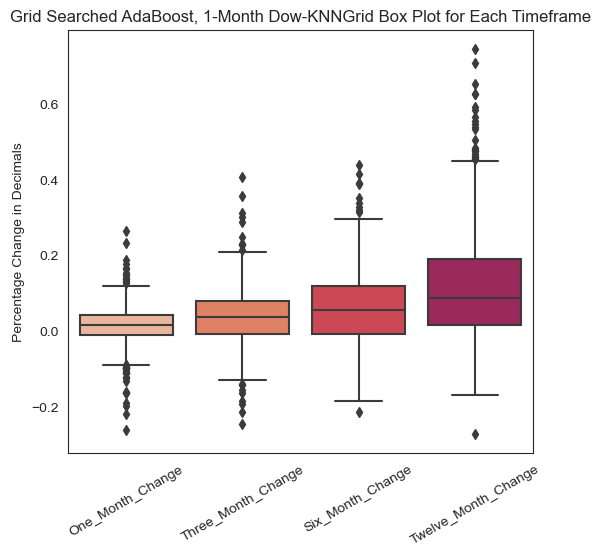

In [278]:
# Most precise model
describe_predictions(knngrid_D_1_month, "^DJI", df=df, cat=1, box=True)

One_Month_Change  Three_Month_Change  Six_Month_Change  \
count       1921.000000         1921.000000       1921.000000   
mean           0.007983            0.023577          0.046128   
std            0.048061            0.071831          0.093010   
min           -0.358731           -0.348829         -0.310132   
25%           -0.014135           -0.011741         -0.013177   
50%            0.011876            0.030589          0.048206   
75%            0.035676            0.068046          0.113835   
max            0.264810            0.406852          0.439503   

       Twelve_Month_Change  
count          1921.000000  
mean              0.098050  
std               0.132302  
min              -0.283893  
25%               0.002086  
50%               0.081420  
75%               0.184957  
max               0.743937

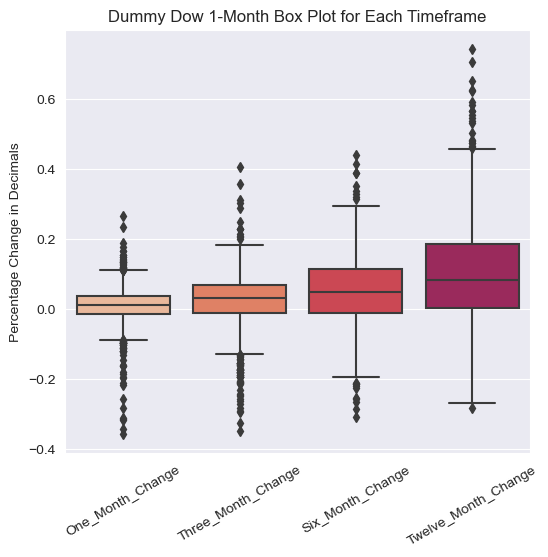

In [281]:
describe_predictions(dummy_D_1_month, "^DJI", df=df, cat=1, box=True)

### Tree model Feature Importances 

In [293]:
# Feature importances for the best tree model
features_from_trees(rfc_D_1_month)
Importance.df

Top 5 Feature Importances
('Interest_Rates', 0.05824327562399875)
('ATR', 0.05298237073810881)
('lowest_bollinger_band', 0.0496700365969398)
('MACD', 0.04952510490464257)
('GDP_Filled', 0.049118539217128984)


Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
0   0.040632  0.037007  0.042715  0.037906  0.031394  0.022302    0.121256   
1   0.047910  0.046397  0.041861  0.044876  0.040230  0.027051    0.049119   

   Interest_Rates    Mkt-RF       SMB       HML       RMW       CMA  \
0        0.099205  0.005304  0.005326  0.007362  0.007724  0.010244   
1        0.058243  0.016385  0.015627  0.015127  0.015592  0.016332   

   garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
0          0.006258  0.015604                0.03996              0.043111   
1          0.019209  0.041324                0.04967              0.045896   

   20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
0    0.041155               0.031843              0.043800  0.046404   
1    0.042415               0.046067              0.046743  0.052982   

       MACD  ...  Quarter_4   Month_1  Month_10  Month_11  Month_12   Month_2  \
0  0.017998  ...   0.014279  0.005447  0.005716  0.003006  0.005145  0.004382   
1  0.049525  ...   0.011129  0.009137  0.004313  0.003696  0.003661  0.005549   

    Month_3   Month_4   Month_5   Month_6   Month_7   Month_8   Month_9  \
0  0.004801  0.006590  0.006236  0.004690  0.008413  0.004068  0.009018   
1  0.007936  0.004587  0.006597  0.005226  0.007133  0.004183  0.006217   

   cycle_year_1  cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
0      0.016851      0.030314      0.027356      0.023366            0.002242   
1      0.006947      0.009211      0.007121      0.008194            0.001407   

   day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
0            0.002260              0.002095             0.002078   
1            0.002048              0.001609             0.001821   

   day_of_week_Wednesday  
0               0.002048  
1               0.001614  

[2 rows x 48 columns]

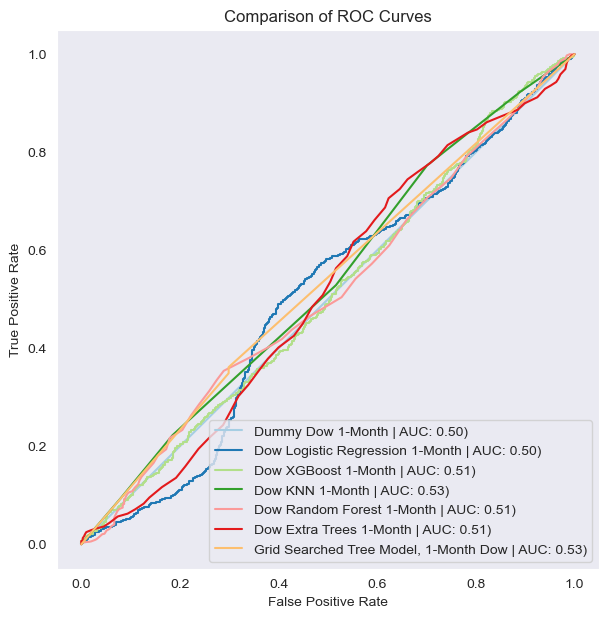

In [294]:
# Comparing model ROC curves

compare_curves([dummy_D_1_month, logreg_D_1_month, XGBoost_D_1_month, knn_D_1_month, rfc_D_1_month, etc_D_1_month, \
                grid_D_1_month])

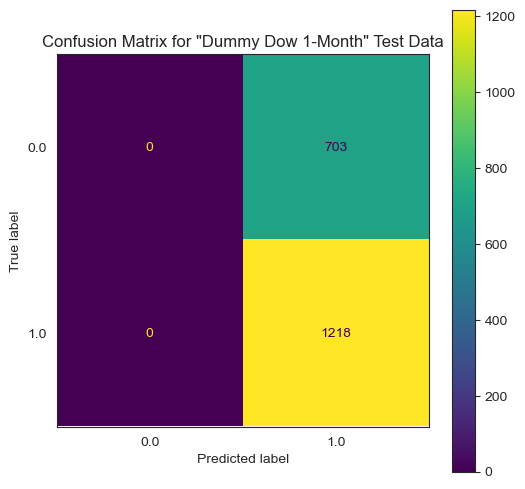

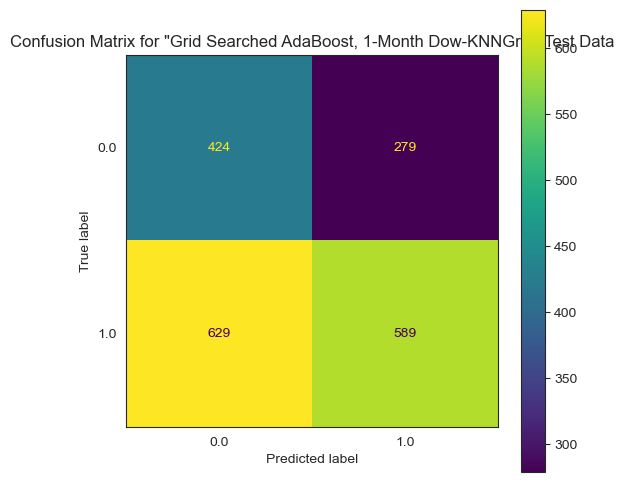

In [295]:
# Dummy CM followed by best individual model CM

for i in [dummy_D_1_month, knngrid_D_1_month]:
    i.confusion_matrix()

<hr style="border: 2px solid red;">

# 3 Month Dow

In [305]:
# Create variables

X_train, X_test, y_train, y_test = select_data(dow_df, "Three")

# Create Model Objects

# dummy_D_3_month = dummy_model(Model, "Dow", 3)
# logreg_D_3_month = l_regr(Model, "Dow", 3)
# knn_D_3_month = knn(Model, "Dow", 3)
# rfc_D_3_month = r_forest(Model, "Dow", 3)
# ada_D_3_month = ada(Model, "Dow", 3)
# etc_D_3_month = extra_trees(Model, "Dow", 3)
# XGBoost_D_3_month = x_g_b(Model, "Dow", 3)

# grid_D_3_month = best_etc_grid(estimator=etc_D_3_month.model, model_type=Model, sector_name="Dow", time_period=3)
# grid_XG_D_3_month = best_XGB_grid(XGBoost_D_3_month.model, Model, "Dow", 3)

Model.model_df.iloc[20:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
25             Dow Extra Trees 3-Month        0.570625    0.689718   
26                 Dow XGBoost 3-Month        0.565208    0.722274   
22                     Dow KNN 3-Month        0.562292    0.661654   
20                   Dummy Dow 3-Month        0.645417    0.645417   
24                     Dow KNN 3-Month        0.564167    0.650181   
23           Dow Random Forest 3-Month        0.550208    0.702109   
21     Dow Logistic Regression 3-Month        0.503125    0.710590   
27  Grid Searched XGBoost, 3-Month Dow        0.511667    0.717040   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
25      0.624035  0.595505       0.824975       0.646538   0.709657   
26      0.620343  0.617795       1.900541       0.483082   0.706938   
22      0.651276  0.621069       7.905623       0.695992   0.700691   
20      1.000000  0.780472      12.780479       0.697033   0.697033   
24      0.716298  0.647284       0.663923       0.396668   0.675097   
23      0.610686  0.574216       0.777297       0.411244   0.646479   
21      0.658290  0.544303       4.402378       0.322749   0.560510   
27      0.651203  0.545304       3.383873       0.322749   0.559375   

    test_recall   test_f1  test_logloss       AUC  
25     0.834205  0.766907      0.663034  0.477463  
26     0.441374  0.543448      1.843976  0.516976  
22     0.984317  0.818634      8.450214  0.544427  
20     1.000000  0.821472     10.920045  0.500000  
24     0.259149  0.374528      0.701979  0.464509  
23     0.342793  0.448023      0.739899  0.494012  
21     0.131441  0.212946      6.348030  0.515903  
27     0.133682  0.215793      5.825099  0.514613

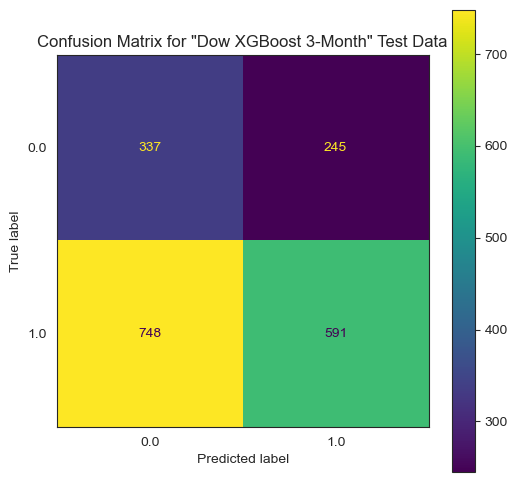

In [313]:
# Most practically useful model
XGBoost_D_3_month.confusion_matrix()

### Results
Looking specifically at the 3-month target, the XGBoost model produced better mean return by 0.8%, and cut the maximum losses by a factor of almost 3. Maximum gains from our model were equivalent to the dummy. You can see how well the XGBoost model minimized outsized negative returns.

count    836.000000
mean       0.031296
std        0.068451
min       -0.132909
25%       -0.009217
50%        0.032430
75%        0.080693
max        0.406852
Name: Three_Month_Change, dtype: float64

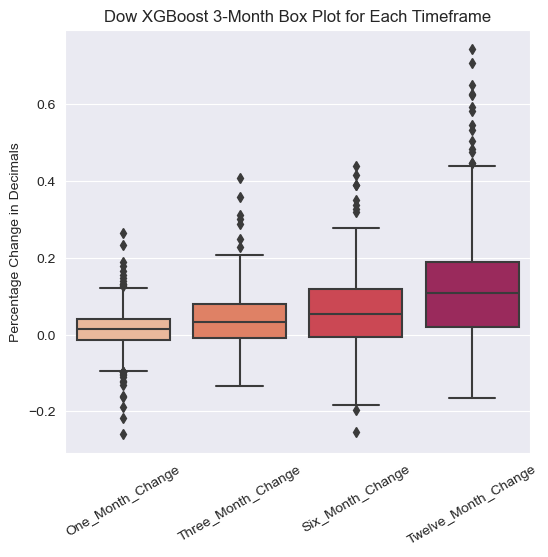

In [316]:
# Most precise model profile
describe_predictions(XGBoost_D_3_month, ticker="^DJI", df=df, cat=1, box=True)["Three_Month_Change"]

count    1921.000000
mean        0.023577
std         0.071831
min        -0.348829
25%        -0.011741
50%         0.030589
75%         0.068046
max         0.406852
Name: Three_Month_Change, dtype: float64

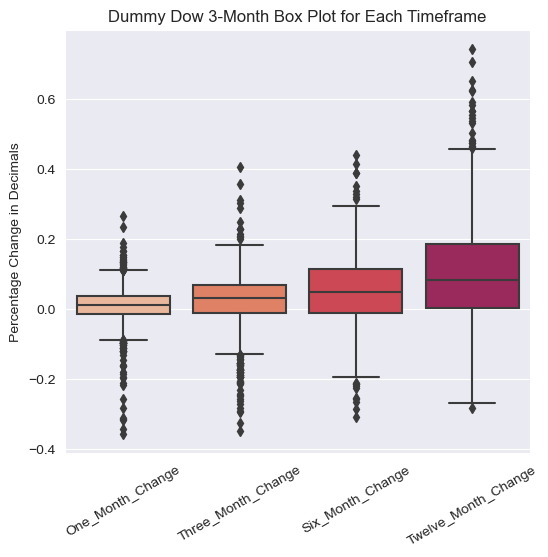

In [315]:
# Dummy Profile
describe_predictions(dummy_D_3_month, ticker="^DJI", df=df, cat=1, box=True)["Three_Month_Change"]

### Choosing XGBoost for better overall statistics

In [306]:
# Feature importances for the best model
features_from_trees(XGBoost_D_3_month)
Importance.df

Top 5 Feature Importances
('cycle_year_2', 0.077668555)
('GDP_Filled', 0.0700603)
('Month_7', 0.06218109)
('Month_6', 0.060685918)
('upper_bollinger_band', 0.046541773)


Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
0   0.040632  0.037007  0.042715  0.037906  0.031394  0.022302    0.121256   
1   0.047910  0.046397  0.041861  0.044876  0.040230  0.027051    0.049119   
2   0.025346  0.000000  0.040976  0.014000  0.006188  0.007736    0.070060   

   Interest_Rates    Mkt-RF       SMB       HML       RMW       CMA  \
0        0.099205  0.005304  0.005326  0.007362  0.007724  0.010244   
1        0.058243  0.016385  0.015627  0.015127  0.015592  0.016332   
2        0.033718  0.004473  0.003492  0.002693  0.006508  0.005923   

   garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
0          0.006258  0.015604               0.039960              0.043111   
1          0.019209  0.041324               0.049670              0.045896   
2          0.004837  0.016786               0.024541              0.025817   

   20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
0    0.041155               0.031843              0.043800  0.046404   
1    0.042415               0.046067              0.046743  0.052982   
2    0.015513               0.029528              0.046542  0.034682   

       MACD  ...  Quarter_4   Month_1  Month_10  Month_11  Month_12   Month_2  \
0  0.017998  ...   0.014279  0.005447  0.005716  0.003006  0.005145  0.004382   
1  0.049525  ...   0.011129  0.009137  0.004313  0.003696  0.003661  0.005549   
2  0.015104  ...   0.007964  0.026322  0.005728  0.019336  0.034812  0.021865   

    Month_3   Month_4   Month_5   Month_6   Month_7   Month_8   Month_9  \
0  0.004801  0.006590  0.006236  0.004690  0.008413  0.004068  0.009018   
1  0.007936  0.004587  0.006597  0.005226  0.007133  0.004183  0.006217   
2  0.033343  0.014447  0.024518  0.060686  0.062181  0.000834  0.012478   

   cycle_year_1  cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
0      0.016851      0.030314      0.027356      0.023366            0.002242   
1      0.006947      0.009211      0.007121      0.008194            0.001407   
2      0.013912      0.077669      0.012335      0.033711            0.001394   

   day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
0            0.002260              0.002095             0.002078   
1            0.002048              0.001609             0.001821   
2            0.001593              0.002069             0.003360   

   day_of_week_Wednesday  
0               0.002048  
1               0.001614  
2               0.000534  

[3 rows x 48 columns]

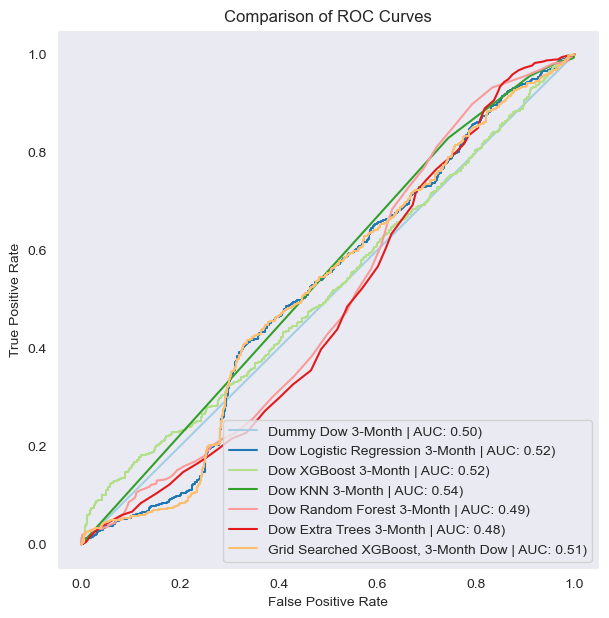

In [318]:
# Comparing model ROC curves

compare_curves([dummy_D_3_month, logreg_D_3_month, XGBoost_D_3_month, knn_D_3_month, rfc_D_3_month, etc_D_3_month, \
                grid_XG_D_3_month])

<hr style="border: 2px solid red;">

# 6 Month Dow

In [354]:
X_train, X_test, y_train, y_test = select_data(dow_df, "Six")

In [356]:
X_test.shape

(1921, 27)

In [322]:
# Create variables

X_train, X_test, y_train, y_test = select_data(dow_df, "Six")

# Create Model Objects

# dummy_D_6_month = dummy_model(Model, "Dow", 6)
# logreg_D_6_month = l_regr(Model, "Dow", 6)
# knn_D_6_month = knn(Model, "Dow", 6)
# ada_D_6_month = ada(Model, "Dow", 6)
# rfc_D_6_month = r_forest(Model, "Dow", 6)
# etc_D_6_month = extra_trees(Model, "Dow", 6)
# XGBoost_D_6_month = x_g_b(Model, "Dow", 6)

# grid_D_6_month = best_etc_grid(estimator=etc_D_6_month.model, model_type=Model, sector_name="Dow", time_period=6)

Model.model_df.iloc[28:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0.1, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.4s finished


name  train_accuracy  train_prec  \
33                Dow Extra Trees 6-Month        0.472708    0.765056   
32              Dow Random Forest 6-Month        0.456458    0.764950   
30                        Dow KNN 6-Month        0.488125    0.749116   
28                      Dummy Dow 6-Month        0.689792    0.689792   
35  Grid Searched Tree Model, 6-Month Dow        0.689792    0.689792   
31                        Dow KNN 6-Month        0.447292    0.652177   
34                    Dow XGBoost 6-Month        0.490208    0.777273   
29        Dow Logistic Regression 6-Month        0.492083    0.740033   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
33      0.621918  0.502458       1.282768       0.567933   0.771819   
32      0.563114  0.464478       1.478109       0.373243   0.756272   
30      0.584104  0.524834      11.507263       0.695471   0.730351   
28      1.000000  0.799315      11.181042       0.701197   0.701197   
35      1.000000  0.799315       0.675748       0.701197   0.701197   
31      0.625447  0.501116       0.714455       0.380531   0.698734   
34      0.559132  0.499374       3.158988       0.477356   0.679958   
29      0.677476  0.587848       2.294822       0.356585   0.667674   

    test_recall   test_f1  test_logloss       AUC  
33     0.544915  0.638816      0.687691  0.610716  
32     0.156644  0.259533      0.828537  0.565723  
30     0.896808  0.805065      4.202509  0.625650  
28     1.000000  0.824357     10.769941  0.500000  
35     1.000000  0.824357      0.610188  0.500000  
31     0.204900  0.316877      0.703167  0.463404  
34     0.481069  0.563478      1.570811  0.473555  
29     0.164068  0.263409     12.159944  0.510550

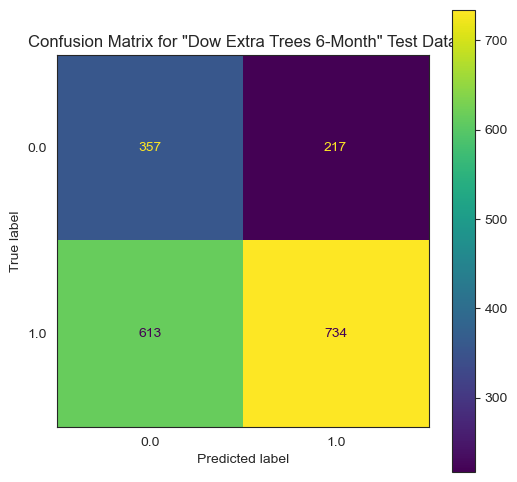

In [323]:
# Most practically useful model
etc_D_6_month.confusion_matrix()

### Results
Looking specifically at the 6-month target, the ETC model produced better mean return by 1.2%, and cut the maximum loss in half. Maximum gains from our model were capped at 10% less than the dummy, the first such occurence. All quartile performances were slightly better than the dummy as well. You can see how well the ETC model minimized outsized negative returns.

count    951.000000
mean       0.058169
std        0.087345
min       -0.166322
25%        0.006830
50%        0.060726
75%        0.125268
max        0.337067
Name: Six_Month_Change, dtype: float64

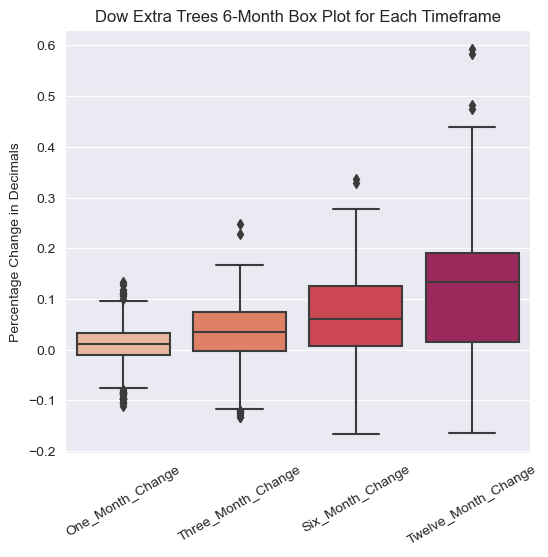

In [328]:
# Most precise model profile
describe_predictions(etc_D_6_month, ticker="^DJI", df=df, cat=1, box=True)["Six_Month_Change"]

count    1921.000000
mean        0.046128
std         0.093010
min        -0.310132
25%        -0.013177
50%         0.048206
75%         0.113835
max         0.439503
Name: Six_Month_Change, dtype: float64

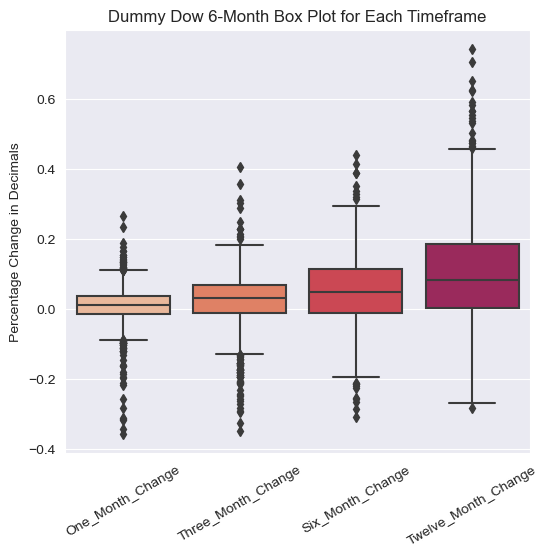

In [326]:
# Dummy Profile
describe_predictions(dummy_D_6_month, ticker="^DJI", df=df, cat=1, box=True)["Six_Month_Change"]

### Choosing ETC model for feature importance

In [329]:
# Feature importances for the best model
features_from_trees(etc_D_6_month)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.08201020650420576)
('Interest_Rates', 0.06431809183700722)
('ATR', 0.04663464286614579)
('Adj Close', 0.04456834100576031)
('20_day_SMA', 0.042214182596091505)


Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
0   0.040632  0.037007  0.042715  0.037906  0.031394  0.022302    0.121256   
1   0.047910  0.046397  0.041861  0.044876  0.040230  0.027051    0.049119   
2   0.025346  0.000000  0.040976  0.014000  0.006188  0.007736    0.070060   
3   0.044568  0.042131  0.034391  0.040268  0.037906  0.020627    0.082010   

   Interest_Rates    Mkt-RF       SMB       HML       RMW       CMA  \
0        0.099205  0.005304  0.005326  0.007362  0.007724  0.010244   
1        0.058243  0.016385  0.015627  0.015127  0.015592  0.016332   
2        0.033718  0.004473  0.003492  0.002693  0.006508  0.005923   
3        0.064318  0.007295  0.006650  0.008046  0.008030  0.008023   

   garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
0          0.006258  0.015604               0.039960              0.043111   
1          0.019209  0.041324               0.049670              0.045896   
2          0.004837  0.016786               0.024541              0.025817   
3          0.008472  0.022335               0.038930              0.040099   

   20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
0    0.041155               0.031843              0.043800  0.046404   
1    0.042415               0.046067              0.046743  0.052982   
2    0.015513               0.029528              0.046542  0.034682   
3    0.042214               0.037619              0.039219  0.046635   

       MACD  ...  Quarter_4   Month_1  Month_10  Month_11  Month_12   Month_2  \
0  0.017998  ...   0.014279  0.005447  0.005716  0.003006  0.005145  0.004382   
1  0.049525  ...   0.011129  0.009137  0.004313  0.003696  0.003661  0.005549   
2  0.015104  ...   0.007964  0.026322  0.005728  0.019336  0.034812  0.021865   
3  0.028024  ...   0.014001  0.009197  0.007277  0.005534  0.009155  0.007235   

    Month_3   Month_4   Month_5   Month_6   Month_7   Month_8   Month_9  \
0  0.004801  0.006590  0.006236  0.004690  0.008413  0.004068  0.009018   
1  0.007936  0.004587  0.006597  0.005226  0.007133  0.004183  0.006217   
2  0.033343  0.014447  0.024518  0.060686  0.062181  0.000834  0.012478   
3  0.010071  0.014402  0.007775  0.007750  0.010204  0.005681  0.007055   

   cycle_year_1  cycle_year_2  cycle_year_3  cycle_year_4  day_of_week_Friday  \
0      0.016851      0.030314      0.027356      0.023366            0.002242   
1      0.006947      0.009211      0.007121      0.008194            0.001407   
2      0.013912      0.077669      0.012335      0.033711            0.001394   
3      0.017170      0.028823      0.026227      0.028736            0.002743   

   day_of_week_Monday  day_of_week_Thursday  day_of_week_Tuesday  \
0            0.002260              0.002095             0.002078   
1            0.002048              0.001609             0.001821   
2            0.001593              0.002069             0.003360   
3            0.003017              0.002629             0.002916   

   day_of_week_Wednesday  
0               0.002048  
1               0.001614  
2               0.000534  
3               0.003050  

[4 rows x 48 columns]

In [330]:
# adding descriptive index name

Importance.df.rename(index={0:"12-Month Dow", 1:"1-Month Dow", 2:"3-Month Dow", 3:'6-Month Dow'}, inplace=True)

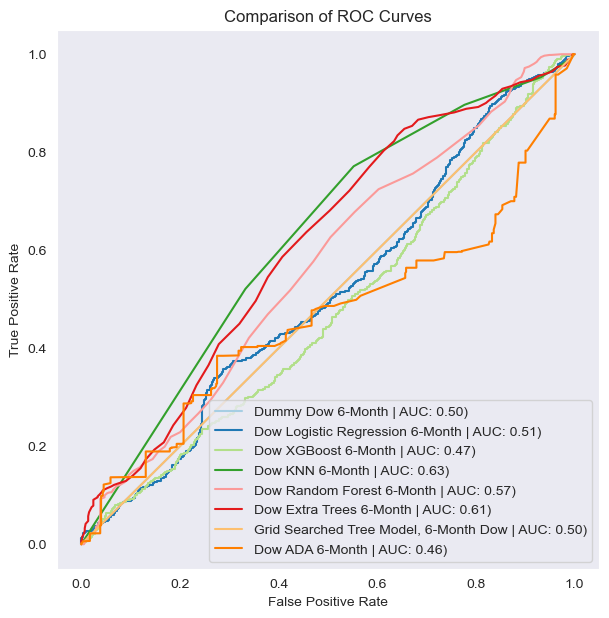

In [337]:
# Comparing model ROC curves

compare_curves([dummy_D_6_month, logreg_D_6_month, XGBoost_D_6_month, knn_D_6_month, rfc_D_6_month, etc_D_6_month, \
                grid_D_6_month, ada_D_6_month])

<hr style="border: 6px solid black">

# 1 Month S&P 

In [378]:
# Create variables

X_train, X_test, y_train, y_test = select_data(sp_df, "One")

# Create Model Objects

# dummy_S_1_month = dummy_model(Model, "S&P", 1)
# logreg_S_1_month = l_regr(Model, "S&P", 1)
# knn_S_1_month = knn(Model, "S&P", 1)
# ada_S_1_month = ada(Model, "S&P", 1)
# rfc_S_1_month = r_forest(Model, "S&P", 1)
# etc_S_1_month = extra_trees(Model, "S&P", 1)
# XGBoost_S_1_month = x_g_b(Model, "S&P", 1)

# Opting for ETC because of closer alignment of train/test scores, KNN looked a bit aberant

# grid_S_1_month = best_etc_grid(estimator=etc_S_1_month.model, model_type=Model, sector_name="S&P", time_period=1)

Model.model_df.iloc[36:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0.001, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.5s finished


name  train_accuracy  train_prec  \
38                        S&P KNN 1-Month        0.550465    0.638533   
41                S&P Extra Trees 1-Month        0.511427    0.684622   
36                      Dummy S&P 1-Month        0.589174    0.589174   
39                        S&P ADA 1-Month        0.506178    0.722362   
40              S&P Random Forest 1-Month        0.497868    0.701810   
42                    S&P XGBoost 1-Month        0.504101    0.628850   
43  Grid Searched Tree Model, 1-Month S&P        0.538874    0.602140   
37        S&P Logistic Regression 1-Month        0.491853    0.657065   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
38      0.599647  0.585689       7.161653       0.452856   0.681569   
41      0.421907  0.419136       0.833809       0.419514   0.670792   
36      1.000000  0.739788      14.807655       0.655917   0.655917   
39      0.444698  0.402660       0.712116       0.392457   0.653913   
40      0.427346  0.404516       0.845694       0.418967   0.650549   
42      0.432485  0.464242       2.088934       0.414321   0.646857   
43      0.587974  0.540469       0.740117       0.421700   0.631238   
37      0.521855  0.464435       2.138132       0.421153   0.621343   

    test_recall   test_f1  test_logloss       AUC  
38     0.311250  0.427346      8.883984  0.514446  
41     0.225833  0.337905      0.911362  0.476737  
36     1.000000  0.792210     12.402011  0.500000  
39     0.156667  0.252773      0.699076  0.506059  
40     0.246667  0.357704      0.960514  0.490661  
42     0.235833  0.345649      2.767793  0.482849  
43     0.284583  0.392303      0.735627  0.450925  
37     0.300833  0.405390      3.211149  0.499983

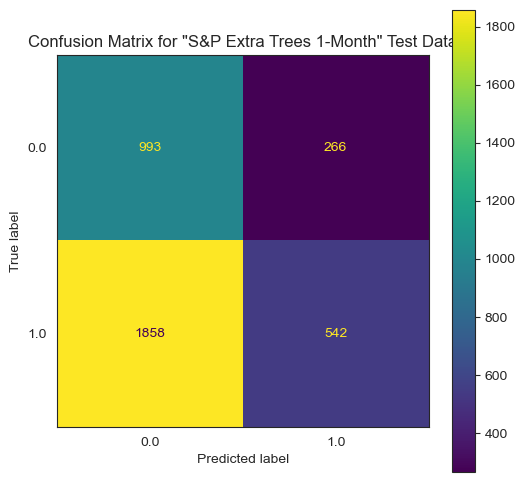

In [379]:
# Most practically useful model
etc_S_1_month.confusion_matrix()

### Results
Looking specifically at the 1-month target, the ETC model produced better mean return by 0.05%, and cut the maximum loss only by 3%. Maximum gains from our model were the same as the dummy. The bottom quartile for our model was 6% worse than the dummy, but 50 and 75 quartile performances were slightly better than the dummy by 0.7% and 1% respectively. Having a mean gain of less than 1% makes all models relatively unattractive.

count    808.000000
mean       0.007711
std        0.069722
min       -0.300304
25%       -0.019145
50%        0.021369
75%        0.045036
max        0.266108
Name: One_Month_Change, dtype: float64

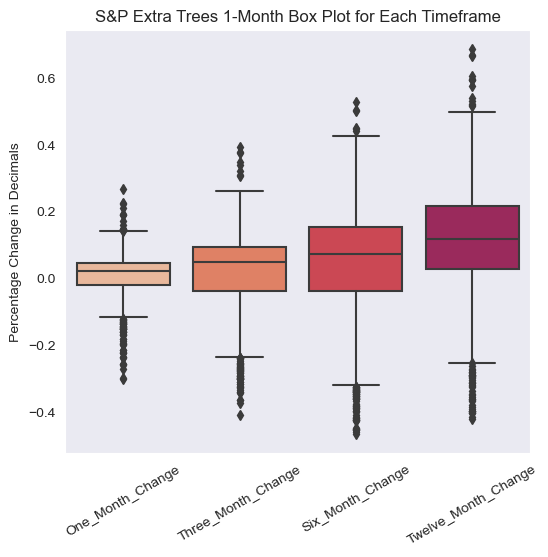

In [387]:
# Most precise model profile
describe_predictions(etc_S_1_month, ticker="^GSPC", df=df, cat=1, box=True)["One_Month_Change"]

count    3659.000000
mean        0.007260
std         0.051344
min        -0.329668
25%        -0.013566
50%         0.014697
75%         0.035519
max         0.266108
Name: One_Month_Change, dtype: float64

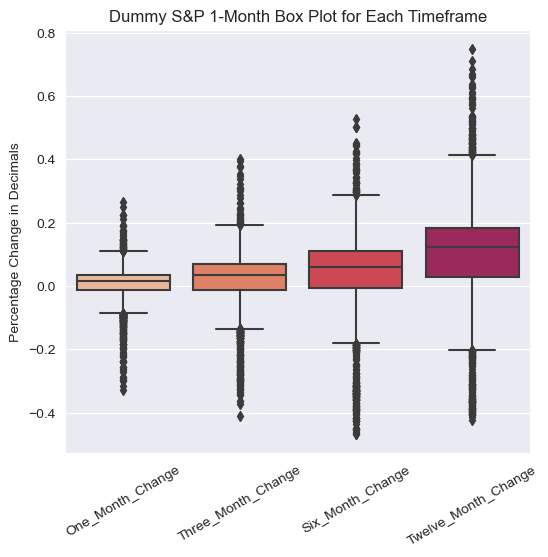

In [384]:
# Dummy Profile
describe_predictions(dummy_S_1_month, ticker="^GSPC", df=df, cat=1, box=True)["One_Month_Change"]

In [385]:
# Feature importances for the best model
features_from_trees(etc_S_1_month)
Importance.df

Top 5 Feature Importances
('Interest_Rates', 0.04734117665153022)
('one_up_bollinger_band', 0.04649450968462407)
('upper_bollinger_band', 0.04610801304935428)
('lower_bollinger_band', 0.04583893200640071)
('Adj Close', 0.04493174402171754)


Adj Close     Close      High       Low      Open    Volume  \
12-Month Dow   0.040632  0.037007  0.042715  0.037906  0.031394  0.022302   
1-Month Dow    0.047910  0.046397  0.041861  0.044876  0.040230  0.027051   
3-Month Dow    0.025346  0.000000  0.040976  0.014000  0.006188  0.007736   
6-Month Dow    0.044568  0.042131  0.034391  0.040268  0.037906  0.020627   
4              0.044932  0.044793  0.043455  0.041550  0.025632  0.025253   

              GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
12-Month Dow    0.121256        0.099205  0.005304  0.005326  0.007362   
1-Month Dow     0.049119        0.058243  0.016385  0.015627  0.015127   
3-Month Dow     0.070060        0.033718  0.004473  0.003492  0.002693   
6-Month Dow     0.082010        0.064318  0.007295  0.006650  0.008046   
4               0.037787        0.047341  0.013726  0.013598  0.014276   

                   RMW       CMA  garman_klass_vol       RSI  \
12-Month Dow  0.007724  0.010244          0.006258  0.015604   
1-Month Dow   0.015592  0.016332          0.019209  0.041324   
3-Month Dow   0.006508  0.005923          0.004837  0.016786   
6-Month Dow   0.008030  0.008023          0.008472  0.022335   
4             0.014694  0.014226          0.015268  0.038545   

              lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
12-Month Dow               0.039960              0.043111    0.041155   
1-Month Dow                0.049670              0.045896    0.042415   
3-Month Dow                0.024541              0.025817    0.015513   
6-Month Dow                0.038930              0.040099    0.042214   
4                          0.043482              0.045839    0.044143   

              one_up_bollinger_band  upper_bollinger_band       ATR      MACD  \
12-Month Dow               0.031843              0.043800  0.046404  0.017998   
1-Month Dow                0.046067              0.046743  0.052982  0.049525   
3-Month Dow                0.029528              0.046542  0.034682  0.015104   
6-Month Dow                0.037619              0.039219  0.046635  0.028024   
4                          0.046495              0.046108  0.040109  0.044580   

              ...  Quarter_4   Month_1  Month_10  Month_11  Month_12  \
12-Month Dow  ...   0.014279  0.005447  0.005716  0.003006  0.005145   
1-Month Dow   ...   0.011129  0.009137  0.004313  0.003696  0.003661   
3-Month Dow   ...   0.007964  0.026322  0.005728  0.019336  0.034812   
6-Month Dow   ...   0.014001  0.009197  0.007277  0.005534  0.009155   
4             ...   0.010003  0.008695  0.009405  0.007923  0.009069   

               Month_2   Month_3   Month_4   Month_5   Month_6   Month_7  \
12-Month Dow  0.004382  0.004801  0.006590  0.006236  0.004690  0.008413   
1-Month Dow   0.005549  0.007936  0.004587  0.006597  0.005226  0.007133   
3-Month Dow   0.021865  0.033343  0.014447  0.024518  0.060686  0.062181   
6-Month Dow   0.007235  0.010071  0.014402  0.007775  0.007750  0.010204   
4             0.009774  0.009796  0.008345  0.009837  0.008650  0.009966   

               Month_8   Month_9  cycle_year_1  cycle_year_2  cycle_year_3  \
12-Month Dow  0.004068  0.009018      0.016851      0.030314      0.027356   
1-Month Dow   0.004183  0.006217      0.006947      0.009211      0.007121   
3-Month Dow   0.000834  0.012478      0.013912      0.077669      0.012335   
6-Month Dow   0.005681  0.007055      0.017170      0.028823      0.026227   
4             0.008154  0.008661      0.012233      0.012620      0.013073   

              cycle_year_4  day_of_week_Friday  day_of_week_Monday  \
12-Month Dow      0.023366            0.002242            0.002260   
1-Month Dow       0.008194            0.001407            0.002048   
3-Month Dow       0.033711            0.001394            0.001593   
6-Month Dow       0.028736            0.002743            0.003017   
4                 0.013242            0.005652            0.005914   

              d

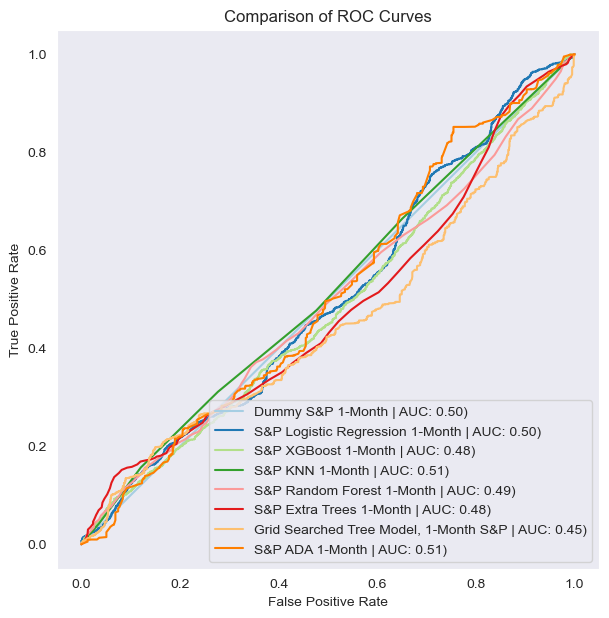

In [388]:
# Comparing model ROC curves

compare_curves([dummy_S_1_month, logreg_S_1_month, XGBoost_S_1_month, knn_S_1_month, rfc_S_1_month, etc_S_1_month, \
                grid_S_1_month, ada_S_1_month])

<hr style="border: 2px solid red;">

# 3 Month S&P 

In [400]:
# Create variables

X_train, X_test, y_train, y_test = select_data(sp_df, "Three")

# Create Model Objects

# dummy_S_3_month = dummy_model(Model, "S&P", 3)
# logreg_S_3_month = l_regr(Model, "S&P", 3)
# knn_S_3_month = knn(Model, "S&P", 3)
# ada_S_3_month = ada(Model, "S&P", 3)
# rfc_S_3_month = r_forest(Model, "S&P", 3)
# etc_S_3_month = extra_trees(Model, "S&P", 3)
# XGBoost_S_3_month = x_g_b(Model, "S&P", 3)

# grid_S_3_month = best_KNN_search(estimator=knn_S_3_month.model, model_class_type=Model, sector_name="S&P", time_period=3)
# ada_grid_S_3 = best_ada_grid(ada_S_3_month.model, Model, "S&P", 3)
Model.model_df.iloc[44:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'model__algorithm': 'SAMME.R', 'model__estimator': LogisticRegression(), 'model__learning_rate': 2.0, 'model__n_estimators': 150}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   10.4s finished


name  train_accuracy  train_prec  \
51                      S&P ADA 3-Month        0.579442    0.650769   
44                    Dummy S&P 3-Month        0.638272    0.638272   
52  Grid Searched AdaBoost, 3-Month S&P        0.545107    0.734184   
46                      S&P KNN 3-Month        0.598797    0.701534   
50       Grid Searched KNN, 3-Month S&P        0.599672    0.693573   
49                  S&P XGBoost 3-Month        0.526627    0.722569   
45      S&P Logistic Regression 3-Month        0.585238    0.720836   
48              S&P Extra Trees 3-Month        0.577802    0.740034   
47            S&P Random Forest 3-Month        0.534500    0.755691   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
51      0.465490  0.439188       0.687939       0.336431   0.721362   
44      1.000000  0.775001      13.037989       0.702651   0.702651   
52      0.568893  0.541344       0.692868       0.362941   0.650000   
46      0.609166  0.634774       5.756956       0.376332   0.634921   
50      0.623234  0.640363       5.109065       0.371960   0.628652   
49      0.418566  0.462854       2.420717       0.379885   0.621971   
45      0.677805  0.582141       4.439917       0.372779   0.618151   
48      0.580083  0.573629       0.831281       0.352555   0.602020   
47      0.485797  0.490575       0.899093       0.361301   0.598651   

    test_recall   test_f1  test_logloss       AUC  
51     0.090626  0.161023      0.885650  0.436182  
44     1.000000  0.825361     10.717544  0.500000  
52     0.202256  0.308514      0.694902  0.488497  
46     0.264489  0.373421     11.979808  0.456286  
50     0.259432  0.367291      9.794537  0.457720  
49     0.299494  0.404306      3.678251  0.415197  
45     0.280825  0.386200      3.353711  0.499576  
48     0.231816  0.334737      1.258606  0.420960  
47     0.276157  0.377961      1.411784  0.416066

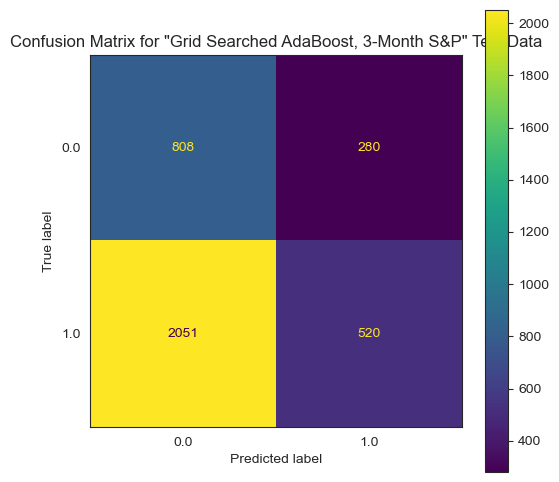

In [402]:
# Most practically useful model
ada_grid_S_3.confusion_matrix()

### Results
These were pretty atrocious results in terms of precision. The AdaBoost model was the only model able to surpass the precision of the dummy model, but its test score was substantially higher than its training score. The best performing model of AdaGrid did manage to improve the mean return. The min return was slightly better for the AdaGrid model, and max returns were virtually equal with the dummy model. Both mean and median returns were better for the AdaGrid model, but annualized returns of around 11.2% for AdaGrid vs 8.8% for the dummy still fails to impress 

count    800.000000
mean       0.028472
std        0.096332
min       -0.363743
25%       -0.020244
50%        0.040573
75%        0.090564
max        0.393035
Name: Three_Month_Change, dtype: float64

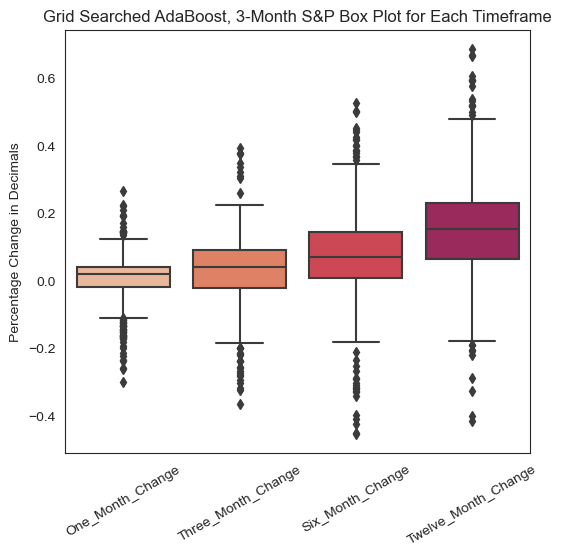

In [404]:
# Most precise model profile
describe_predictions(ada_grid_S_3, ticker="^GSPC", df=df, cat=1, box=True)["Three_Month_Change"]

count    3659.000000
mean        0.021717
std         0.082319
min        -0.409638
25%        -0.012200
50%         0.035701
75%         0.069708
max         0.399522
Name: Three_Month_Change, dtype: float64

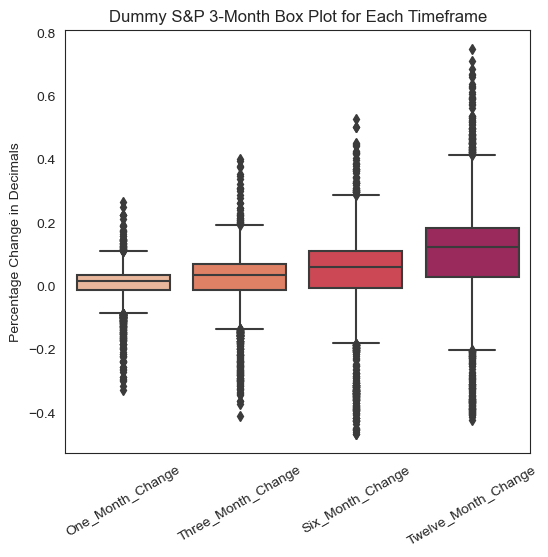

In [395]:
# Dummy Profile
describe_predictions(dummy_S_3_month, ticker="^GSPC", df=df, cat=1, box=True)["Three_Month_Change"]

In [398]:
# Feature importances for the best model
features_from_trees(XGBoost_S_3_month)
Importance.df

Top 5 Feature Importances
('cycle_year_1', 0.11202782)
('cycle_year_2', 0.102780215)
('GDP_Filled', 0.05283451)
('Quarter_4', 0.04563242)
('Quarter_2', 0.037046604)


Adj Close     Close      High       Low      Open    Volume  \
12-Month Dow   0.040632  0.037007  0.042715  0.037906  0.031394  0.022302   
1-Month Dow    0.047910  0.046397  0.041861  0.044876  0.040230  0.027051   
3-Month Dow    0.025346  0.000000  0.040976  0.014000  0.006188  0.007736   
6-Month Dow    0.044568  0.042131  0.034391  0.040268  0.037906  0.020627   
4              0.044932  0.044793  0.043455  0.041550  0.025632  0.025253   
5              0.019316  0.000000  0.018866  0.012285  0.002937  0.008108   

              GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
12-Month Dow    0.121256        0.099205  0.005304  0.005326  0.007362   
1-Month Dow     0.049119        0.058243  0.016385  0.015627  0.015127   
3-Month Dow     0.070060        0.033718  0.004473  0.003492  0.002693   
6-Month Dow     0.082010        0.064318  0.007295  0.006650  0.008046   
4               0.037787        0.047341  0.013726  0.013598  0.014276   
5               0.052835        0.025877  0.003870  0.003956  0.004274   

                   RMW       CMA  garman_klass_vol       RSI  \
12-Month Dow  0.007724  0.010244          0.006258  0.015604   
1-Month Dow   0.015592  0.016332          0.019209  0.041324   
3-Month Dow   0.006508  0.005923          0.004837  0.016786   
6-Month Dow   0.008030  0.008023          0.008472  0.022335   
4             0.014694  0.014226          0.015268  0.038545   
5             0.003110  0.003619          0.004425  0.013655   

              lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
12-Month Dow               0.039960              0.043111    0.041155   
1-Month Dow                0.049670              0.045896    0.042415   
3-Month Dow                0.024541              0.025817    0.015513   
6-Month Dow                0.038930              0.040099    0.042214   
4                          0.043482              0.045839    0.044143   
5                          0.021667              0.032016    0.016200   

              one_up_bollinger_band  upper_bollinger_band       ATR      MACD  \
12-Month Dow               0.031843              0.043800  0.046404  0.017998   
1-Month Dow                0.046067              0.046743  0.052982  0.049525   
3-Month Dow                0.029528              0.046542  0.034682  0.015104   
6-Month Dow                0.037619              0.039219  0.046635  0.028024   
4                          0.046495              0.046108  0.040109  0.044580   
5                          0.031716              0.018861  0.016439  0.017710   

              ...  Quarter_4   Month_1  Month_10  Month_11  Month_12  \
12-Month Dow  ...   0.014279  0.005447  0.005716  0.003006  0.005145   
1-Month Dow   ...   0.011129  0.009137  0.004313  0.003696  0.003661   
3-Month Dow   ...   0.007964  0.026322  0.005728  0.019336  0.034812   
6-Month Dow   ...   0.014001  0.009197  0.007277  0.005534  0.009155   
4             ...   0.010003  0.008695  0.009405  0.007923  0.009069   
5             ...   0.045632  0.016815  0.017330  0.015651  0.036401   

               Month_2   Month_3   Month_4   Month_5   Month_6   Month_7  \
12-Month Dow  0.004382  0.004801  0.006590  0.006236  0.004690  0.008413   
1-Month Dow   0.005549  0.007936  0.004587  0.006597  0.005226  0.007133   
3-Month Dow   0.021865  0.033343  0.014447  0.024518  0.060686  0.062181   
6-Month Dow   0.007235  0.010071  0.014402  0.007775  0.007750  0.010204   
4             0.009774  0.009796  0.008345  0.009837  0.008650  0.009966   
5             0.028255  0.021828  0.018959  0.016164  0.034346  0.027596   

               Month_8   Month_9  cycle_year_1  cycle_year_2  cycle_year_3  \
12-Month Dow  0.004068  0.009018      0.016851      0.030314      0.027356   
1-Month Dow   0.004183  0.006217      0.006947      0.009211      0.007121   
3-Month Dow   0.000834  0.012478      0.013912      0.077669      0.012335   
6-Month Dow   0.005681  0.007055      0.017170      0.028823      0.026227  

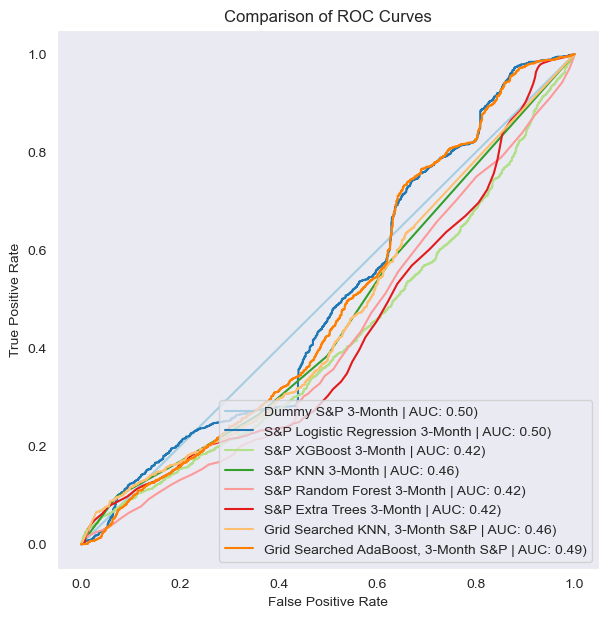

In [407]:
# Comparing model ROC curves

compare_curves([dummy_S_3_month, logreg_S_3_month, XGBoost_S_3_month, knn_S_3_month, rfc_S_3_month, etc_S_3_month, \
                grid_S_3_month, ada_grid_S_3])

<hr style="border: 2px solid red;">

# 6 Month S&P 

In [413]:
# Create variables

X_train, X_test, y_train, y_test = select_data(sp_df, "Six")

# Create Model Objects

# dummy_S_6_month = dummy_model(Model, "S&P", 6)
# logreg_S_6_month = l_regr(Model, "S&P", 6)
# knn_S_6_month = knn(Model, "S&P", 6)
# ada_S_6_month = ada(Model, "S&P", 6)
# rfc_S_6_month = r_forest(Model, "S&P", 6)
# etc_S_6_month = extra_trees(Model, "S&P", 6)
# XGBoost_S_6_month = x_g_b(Model, "S&P", 6)

# grid_S_6_month = best_XGB_grid(estimator=XGBoost_S_6_month.model, model_class_type=Model, sector_name="S&P", time_period=6)

Model.model_df.iloc[51:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
56                      S&P ADA 6-Month        0.556916    0.618279   
59                  S&P XGBoost 6-Month        0.590049    0.801412   
57            S&P Random Forest 6-Month        0.543794    0.849722   
58              S&P Extra Trees 6-Month        0.618043    0.830122   
53                    Dummy S&P 6-Month        0.679716    0.679716   
54      S&P Logistic Regression 6-Month        0.579552    0.748745   
60   Grid Searched XGBoost, 6-Month S&P        0.580864    0.759784   
51                      S&P ADA 3-Month        0.579442    0.650769   
55                      S&P KNN 6-Month        0.598907    0.774733   
52  Grid Searched AdaBoost, 3-Month S&P        0.545107    0.734184   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
56      0.525326  0.530901       0.711559       0.312654   0.968085   
59      0.545386  0.616970       1.716813       0.333151   0.849582   
57      0.471167  0.491703       0.899348       0.345176   0.783109   
58      0.612989  0.621365       0.769042       0.343810   0.738487   
53      1.000000  0.803314      11.544217       0.735447   0.735447   
54      0.641043  0.587967       4.268112       0.395190   0.733398   
60      0.631618  0.586935       3.250015       0.337251   0.730104   
51      0.465490  0.439188       0.687939       0.336431   0.721362   
55      0.590167  0.631034       7.321594       0.314840   0.705357   
52      0.568893  0.541344       0.692868       0.362941   0.650000   

    test_recall   test_f1  test_logloss       AUC  
56     0.067633  0.126433      0.925590  0.545897  
59     0.113341  0.200000      6.858042  0.490430  
57     0.151616  0.254047      2.871703  0.509102  
58     0.166852  0.272204      2.643897  0.471869  
53     1.000000  0.847559      9.535462  0.500000  
54     0.279078  0.404307      7.225569  0.543572  
60     0.156819  0.258183      3.435709  0.543228  
51     0.090626  0.161023      0.885650  0.436182  
55     0.117428  0.201338     20.507299  0.484790  
52     0.202256  0.308514      0.694902  0.488497

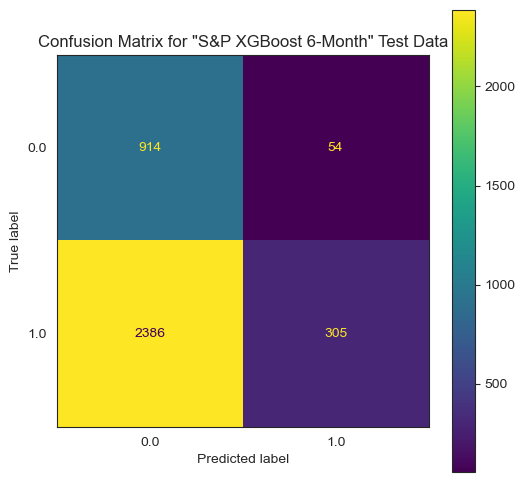

In [414]:
# Most practically useful model
XGBoost_S_6_month.confusion_matrix()

### Results
I opted to use the XGBoost model as it seemed to generalize the best. Even though AdaBoost had a 97% precision score on test data, its training precision score was 62%. In this instance, looking at the 6-month time period, XGBoost managed to improve on mean gains by almost 9%, and reduced the maximum loss from 47% to 21% over the dummy model. Maximum gains were equivalent over that period. A roughly 27% annualized return is the best result of any model so far.

count    359.000000
mean       0.134244
std        0.125300
min       -0.209492
25%        0.045081
50%        0.124212
75%        0.219586
max        0.527456
Name: Six_Month_Change, dtype: float64

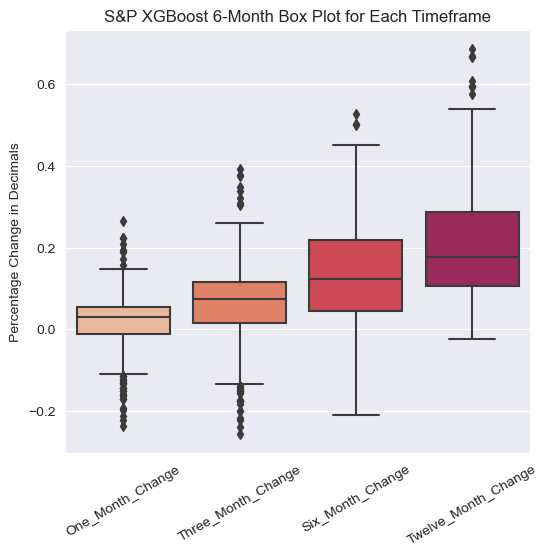

In [417]:
# Most precise model profile
describe_predictions(XGBoost_S_6_month, ticker="^GSPC", df=df, cat=1, box=True)["Six_Month_Change"]

count    3659.000000
mean        0.045936
std         0.120240
min        -0.467638
25%        -0.006424
50%         0.061346
75%         0.110615
max         0.527456
Name: Six_Month_Change, dtype: float64

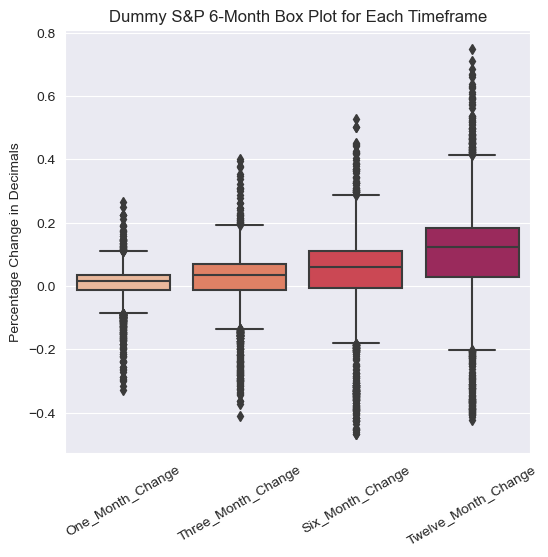

In [418]:
# Dummy Profile
describe_predictions(dummy_S_6_month, ticker="^GSPC", df=df, cat=1, box=True)["Six_Month_Change"]

In [419]:
# Feature importances for the best model
features_from_trees(rfc_S_6_month)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.09247800531530852)
('Interest_Rates', 0.06594053518615377)
('upper_bollinger_band', 0.059483331447698434)
('one_up_bollinger_band', 0.05716925342006516)
('ATR', 0.05558030481635927)


Adj Close     Close      High       Low      Open    Volume  \
12-Month Dow   0.040632  0.037007  0.042715  0.037906  0.031394  0.022302   
1-Month Dow    0.047910  0.046397  0.041861  0.044876  0.040230  0.027051   
3-Month Dow    0.025346  0.000000  0.040976  0.014000  0.006188  0.007736   
6-Month Dow    0.044568  0.042131  0.034391  0.040268  0.037906  0.020627   
4              0.044932  0.044793  0.043455  0.041550  0.025632  0.025253   
5              0.019316  0.000000  0.018866  0.012285  0.002937  0.008108   
6              0.041554  0.039364  0.039479  0.039635  0.022491  0.031403   

              GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
12-Month Dow    0.121256        0.099205  0.005304  0.005326  0.007362   
1-Month Dow     0.049119        0.058243  0.016385  0.015627  0.015127   
3-Month Dow     0.070060        0.033718  0.004473  0.003492  0.002693   
6-Month Dow     0.082010        0.064318  0.007295  0.006650  0.008046   
4               0.037787        0.047341  0.013726  0.013598  0.014276   
5               0.052835        0.025877  0.003870  0.003956  0.004274   
6               0.092478        0.065941  0.006025  0.005680  0.006364   

                   RMW       CMA  garman_klass_vol       RSI  \
12-Month Dow  0.007724  0.010244          0.006258  0.015604   
1-Month Dow   0.015592  0.016332          0.019209  0.041324   
3-Month Dow   0.006508  0.005923          0.004837  0.016786   
6-Month Dow   0.008030  0.008023          0.008472  0.022335   
4             0.014694  0.014226          0.015268  0.038545   
5             0.003110  0.003619          0.004425  0.013655   
6             0.007230  0.006941          0.011722  0.020891   

              lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
12-Month Dow               0.039960              0.043111    0.041155   
1-Month Dow                0.049670              0.045896    0.042415   
3-Month Dow                0.024541              0.025817    0.015513   
6-Month Dow                0.038930              0.040099    0.042214   
4                          0.043482              0.045839    0.044143   
5                          0.021667              0.032016    0.016200   
6                          0.044649              0.051109    0.049826   

              one_up_bollinger_band  upper_bollinger_band       ATR      MACD  \
12-Month Dow               0.031843              0.043800  0.046404  0.017998   
1-Month Dow                0.046067              0.046743  0.052982  0.049525   
3-Month Dow                0.029528              0.046542  0.034682  0.015104   
6-Month Dow                0.037619              0.039219  0.046635  0.028024   
4                          0.046495              0.046108  0.040109  0.044580   
5                          0.031716              0.018861  0.016439  0.017710   
6                          0.057169              0.059483  0.055580  0.028988   

              ...  Quarter_4   Month_1  Month_10  Month_11  Month_12  \
12-Month Dow  ...   0.014279  0.005447  0.005716  0.003006  0.005145   
1-Month Dow   ...   0.011129  0.009137  0.004313  0.003696  0.003661   
3-Month Dow   ...   0.007964  0.026322  0.005728  0.019336  0.034812   
6-Month Dow   ...   0.014001  0.009197  0.007277  0.005534  0.009155   
4             ...   0.010003  0.008695  0.009405  0.007923  0.009069   
5             ...   0.045632  0.016815  0.017330  0.015651  0.036401   
6             ...   0.009229  0.005215  0.003507  0.002792  0.004791   

               Month_2   Month_3   Month_4   Month_5   Month_6   Month_7  \
12-Month Dow  0.004382  0.004801  0.006590  0.006236  0.004690  0.008413   
1-Month Dow   0.005549  0.007936  0.004587  0.006597  0.005226  0.007133   
3-Month Dow   0.021865  0.033343  0.014447  0.024518  0.060686  0.062181   
6-Month Dow   0.007235  0.010071  0.014402  0.007775  0.007750  0.010204   
4             0.009774  0.009796  0.008345  0.009837  0.008650  0.009966   
5             0.028255  

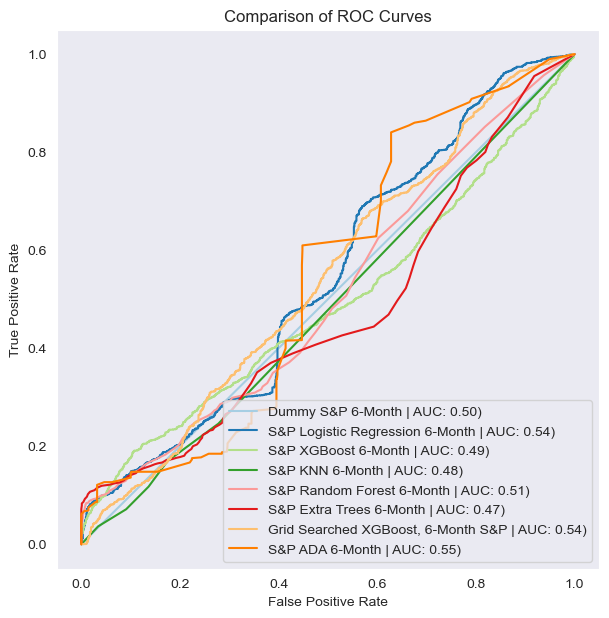

In [420]:
# Comparing model ROC curves

compare_curves([dummy_S_6_month, logreg_S_6_month, XGBoost_S_6_month, knn_S_6_month, rfc_S_6_month, etc_S_6_month, \
                grid_S_6_month, ada_S_6_month])

<hr style="border: 2px solid red;">

# 12 Month S&P 

In [424]:
# Create variables

X_train, X_test, y_train, y_test = select_data(sp_df, "Twelve")

# Create Model Objects

# dummy_S_12_month = dummy_model(Model, "S&P", 12)
# logreg_S_12_month = l_regr(Model, "S&P", 12)
# knn_S_12_month = knn(Model, "S&P", 12)
# ada_S_12_month = ada(Model, "S&P", 12)
# rfc_S_12_month = r_forest(Model, "S&P", 12)
# etc_S_12_month = extra_trees(Model, "S&P", 12)
# XGBoost_S_12_month = x_g_b(Model, "S&P", 12)

# grid_S_12_month = best_etc_grid(estimator=rfc_S_12_month.model, model_type=Model, sector_name="S&P", time_period=12)

Model.model_df.iloc[61:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0.01, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.3s finished


name  train_accuracy  train_prec  \
65              S&P Random Forest 12-Month        0.712630    0.822074   
62        S&P Logistic Regression 12-Month        0.687151    0.805254   
67                    S&P XGBoost 12-Month        0.759759    0.764979   
66                S&P Extra Trees 12-Month        0.709896    0.814248   
63                        S&P KNN 12-Month        0.745435    0.763407   
64                        S&P ADA 12-Month        0.632039    0.765680   
68  Grid Searched Tree Model, 12-Month S&P        0.724768    0.783073   
61                      Dummy S&P 12-Month        0.715036    0.715036   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
65      0.782222  0.783162       0.579832       0.344630   0.961783   
62      0.767547  0.747811       2.852032       0.365400   0.960674   
67      0.941566  0.843463       1.048597       0.367587   0.936842   
66      0.779573  0.760812       0.606481       0.350916   0.935065   
63      0.890289  0.812174       6.854086       0.261274   0.928349   
64      0.800361  0.715825       0.677322       0.246242   0.907407   
68      0.847003  0.798529       0.533173       0.385351   0.861966   
61      1.000000  0.828788      10.271160       0.813884   0.813884   

    test_recall   test_f1  test_logloss       AUC  
65     0.202821  0.334997      6.689677  0.551514  
62     0.229684  0.370732      9.813500  0.655202  
67     0.239087  0.380952      5.462916  0.636071  
66     0.217596  0.353037      4.251662  0.591624  
63     0.100067  0.180661     24.038257  0.564482  
64     0.082270  0.150862      0.742248  0.614013  
68     0.291471  0.435634      1.501804  0.514172  
61     1.000000  0.897393      6.708316  0.500000

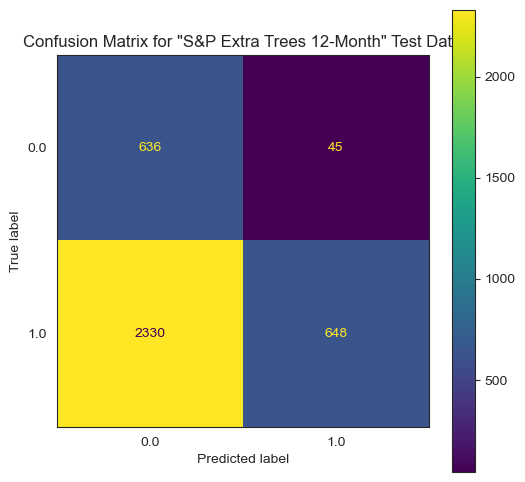

In [425]:
# Most practically useful model
etc_S_12_month.confusion_matrix()

### Results
Very tricky to determine the best model for grid searching as all of the train and test metrics were significantly dislocated. I selected the RFC because its overall profile was better than the ETC model, even though the gap between ETC's train and test scores was fractionally tighter. Again, I did not feel comfortable going with other models that had larger gaps between train and test. Mean gains were 3.6% larger with the ETC model, and max losses were cut in half. Maximum gains were slightly reduced.

count    693.000000
mean       0.142575
std        0.135727
min       -0.219600
25%        0.038522
50%        0.119504
75%        0.216553
max        0.685734
Name: Twelve_Month_Change, dtype: float64

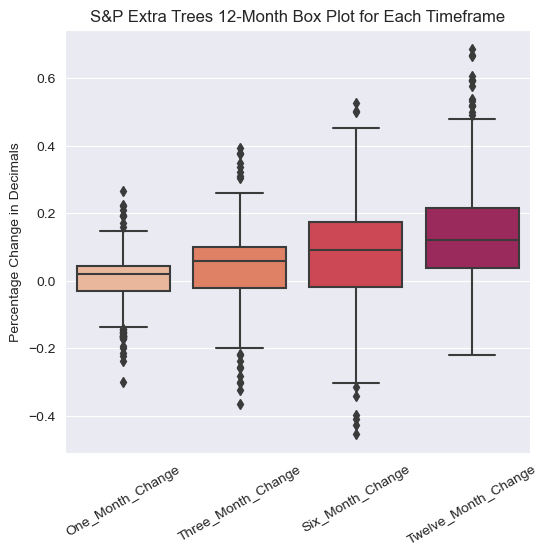

In [430]:
# Most precise model profile
describe_predictions(etc_S_12_month, ticker="^GSPC", df=df, cat=1, box=True)["Twelve_Month_Change"]

count    3659.000000
mean        0.106730
std         0.148765
min        -0.421937
25%         0.028849
50%         0.123997
75%         0.182863
max         0.747797
Name: Twelve_Month_Change, dtype: float64

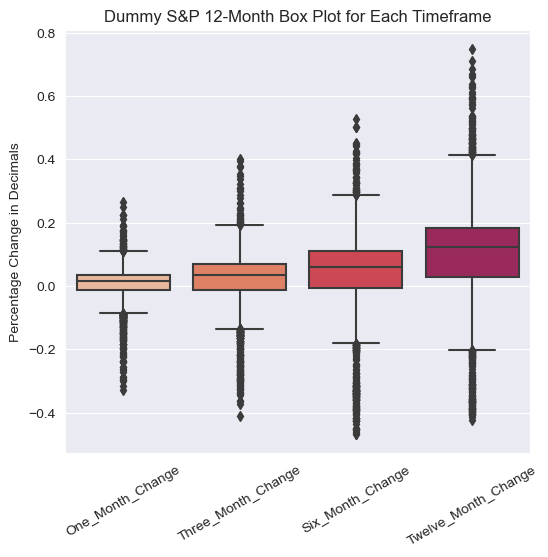

In [428]:
# Dummy Profile
describe_predictions(dummy_S_12_month, ticker="^GSPC", df=df, cat=1, box=True)["Twelve_Month_Change"]

In [431]:
# Feature importances for the best model
features_from_trees(etc_S_12_month)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.08512221072840641)
('cycle_year_1', 0.06735054055822817)
('upper_bollinger_band', 0.051142987412908784)
('cycle_year_3', 0.04821160895825477)
('lower_bollinger_band', 0.04793070964084888)


Adj Close     Close      High       Low      Open    Volume  \
12-Month Dow   0.040632  0.037007  0.042715  0.037906  0.031394  0.022302   
1-Month Dow    0.047910  0.046397  0.041861  0.044876  0.040230  0.027051   
3-Month Dow    0.025346  0.000000  0.040976  0.014000  0.006188  0.007736   
6-Month Dow    0.044568  0.042131  0.034391  0.040268  0.037906  0.020627   
4              0.044932  0.044793  0.043455  0.041550  0.025632  0.025253   
5              0.019316  0.000000  0.018866  0.012285  0.002937  0.008108   
6              0.041554  0.039364  0.039479  0.039635  0.022491  0.031403   
7              0.040410  0.041263  0.044003  0.044385  0.041698  0.022166   

              GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
12-Month Dow    0.121256        0.099205  0.005304  0.005326  0.007362   
1-Month Dow     0.049119        0.058243  0.016385  0.015627  0.015127   
3-Month Dow     0.070060        0.033718  0.004473  0.003492  0.002693   
6-Month Dow     0.082010        0.064318  0.007295  0.006650  0.008046   
4               0.037787        0.047341  0.013726  0.013598  0.014276   
5               0.052835        0.025877  0.003870  0.003956  0.004274   
6               0.092478        0.065941  0.006025  0.005680  0.006364   
7               0.085122        0.039196  0.003119  0.002874  0.003756   

                   RMW       CMA  garman_klass_vol       RSI  \
12-Month Dow  0.007724  0.010244          0.006258  0.015604   
1-Month Dow   0.015592  0.016332          0.019209  0.041324   
3-Month Dow   0.006508  0.005923          0.004837  0.016786   
6-Month Dow   0.008030  0.008023          0.008472  0.022335   
4             0.014694  0.014226          0.015268  0.038545   
5             0.003110  0.003619          0.004425  0.013655   
6             0.007230  0.006941          0.011722  0.020891   
7             0.003831  0.004000          0.007383  0.012668   

              lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
12-Month Dow               0.039960              0.043111    0.041155   
1-Month Dow                0.049670              0.045896    0.042415   
3-Month Dow                0.024541              0.025817    0.015513   
6-Month Dow                0.038930              0.040099    0.042214   
4                          0.043482              0.045839    0.044143   
5                          0.021667              0.032016    0.016200   
6                          0.044649              0.051109    0.049826   
7                          0.045723              0.047931    0.042930   

              one_up_bollinger_band  upper_bollinger_band       ATR      MACD  \
12-Month Dow               0.031843              0.043800  0.046404  0.017998   
1-Month Dow                0.046067              0.046743  0.052982  0.049525   
3-Month Dow                0.029528              0.046542  0.034682  0.015104   
6-Month Dow                0.037619              0.039219  0.046635  0.028024   
4                          0.046495              0.046108  0.040109  0.044580   
5                          0.031716              0.018861  0.016439  0.017710   
6                          0.057169              0.059483  0.055580  0.028988   
7                          0.043014              0.051143  0.036329  0.015864   

              ...  Quarter_4   Month_1  Month_10  Month_11  Month_12  \
12-Month Dow  ...   0.014279  0.005447  0.005716  0.003006  0.005145   
1-Month Dow   ...   0.011129  0.009137  0.004313  0.003696  0.003661   
3-Month Dow   ...   0.007964  0.026322  0.005728  0.019336  0.034812   
6-Month Dow   ...   0.014001  0.009197  0.007277  0.005534  0.009155   
4             ...   0.010003  0.008695  0.009405  0.007923  0.009069   
5             ...   0.045632  0.016815  0.017330  0.015651  0.036401   
6             ...   0.009229  0.005215  0.003507  0.002792  0.004791   
7             ...   0.016682  0.007798  0.003093  0.003755  0.006484   

               Month_2   Month_3   Mont

In [432]:
Importance.df.rename(index={4:"S&P 1-Month", 5:"S&P 3-Month", 6:'S&P 6-Month', 7:"S&P 12-Month"}, inplace=True)
Importance.df.tail()

Adj Close     Close      High       Low      Open    Volume  \
6-Month Dow    0.044568  0.042131  0.034391  0.040268  0.037906  0.020627   
S&P 1-Month    0.044932  0.044793  0.043455  0.041550  0.025632  0.025253   
S&P 3-Month    0.019316  0.000000  0.018866  0.012285  0.002937  0.008108   
S&P 6-Month    0.041554  0.039364  0.039479  0.039635  0.022491  0.031403   
S&P 12-Month   0.040410  0.041263  0.044003  0.044385  0.041698  0.022166   

              GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
6-Month Dow     0.082010        0.064318  0.007295  0.006650  0.008046   
S&P 1-Month     0.037787        0.047341  0.013726  0.013598  0.014276   
S&P 3-Month     0.052835        0.025877  0.003870  0.003956  0.004274   
S&P 6-Month     0.092478        0.065941  0.006025  0.005680  0.006364   
S&P 12-Month    0.085122        0.039196  0.003119  0.002874  0.003756   

                   RMW       CMA  garman_klass_vol       RSI  \
6-Month Dow   0.008030  0.008023          0.008472  0.022335   
S&P 1-Month   0.014694  0.014226          0.015268  0.038545   
S&P 3-Month   0.003110  0.003619          0.004425  0.013655   
S&P 6-Month   0.007230  0.006941          0.011722  0.020891   
S&P 12-Month  0.003831  0.004000          0.007383  0.012668   

              lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
6-Month Dow                0.038930              0.040099    0.042214   
S&P 1-Month                0.043482              0.045839    0.044143   
S&P 3-Month                0.021667              0.032016    0.016200   
S&P 6-Month                0.044649              0.051109    0.049826   
S&P 12-Month               0.045723              0.047931    0.042930   

              one_up_bollinger_band  upper_bollinger_band       ATR      MACD  \
6-Month Dow                0.037619              0.039219  0.046635  0.028024   
S&P 1-Month                0.046495              0.046108  0.040109  0.044580   
S&P 3-Month                0.031716              0.018861  0.016439  0.017710   
S&P 6-Month                0.057169              0.059483  0.055580  0.028988   
S&P 12-Month               0.043014              0.051143  0.036329  0.015864   

              ...  Quarter_4   Month_1  Month_10  Month_11  Month_12  \
6-Month Dow   ...   0.014001  0.009197  0.007277  0.005534  0.009155   
S&P 1-Month   ...   0.010003  0.008695  0.009405  0.007923  0.009069   
S&P 3-Month   ...   0.045632  0.016815  0.017330  0.015651  0.036401   
S&P 6-Month   ...   0.009229  0.005215  0.003507  0.002792  0.004791   
S&P 12-Month  ...   0.016682  0.007798  0.003093  0.003755  0.006484   

               Month_2   Month_3   Month_4   Month_5   Month_6   Month_7  \
6-Month Dow   0.007235  0.010071  0.014402  0.007775  0.007750  0.010204   
S&P 1-Month   0.009774  0.009796  0.008345  0.009837  0.008650  0.009966   
S&P 3-Month   0.028255  0.021828  0.018959  0.016164  0.034346  0.027596   
S&P 6-Month   0.002637  0.003373  0.006443  0.002348  0.003310  0.002582   
S&P 12-Month  0.003488  0.004578  0.005730  0.003324  0.003412  0.004450   

               Month_8   Month_9  cycle_year_1  cycle_year_2  cycle_year_3  \
6-Month Dow   0.005681  0.007055      0.017170      0.028823      0.026227   
S&P 1-Month   0.008154  0.008661      0.012233      0.012620      0.013073   
S&P 3-Month   0.020016  0.009084      0.112028      0.102780      0.023062   
S&P 6-Month   0.001623  0.003966      0.045398      0.016804      0.024101   
S&P 12-Month  0.005289  0.004893      0.067351      0.036261      0.048212   

              cycle_year_4  day_of_week_Friday  day_of_week_Monday  \
6-Month Dow       0.028736            0.002743            0.003017   
S&P 1-Month       0.013242            0.005652            0.005914   
S&P 3-Month       0.011888            0.001634            0.002694   
S&P 6-Month       0.017068            0.000607            0.000492   
S&P 12-Month      0.028639            0.001178            0.001218   

              d

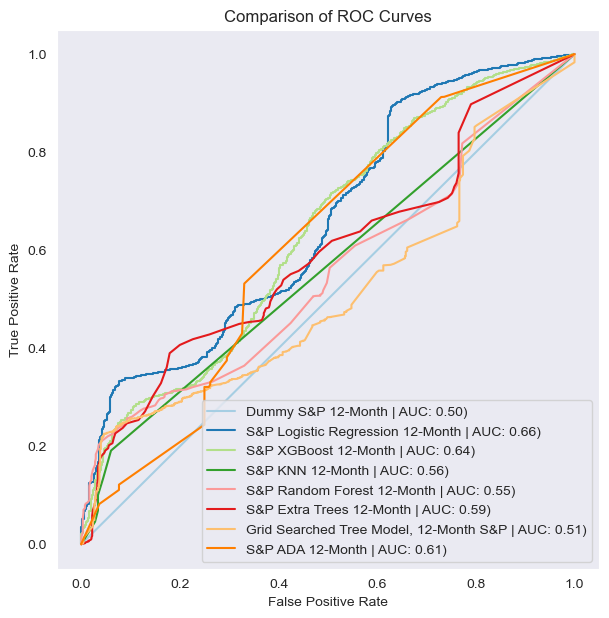

In [433]:
# Comparing model ROC curves

compare_curves([dummy_S_12_month, logreg_S_12_month, XGBoost_S_12_month, knn_S_12_month, rfc_S_12_month, etc_S_12_month, \
                grid_S_12_month, ada_S_12_month])

<hr style="border: 6px solid black">

# 1 Month Nasdaq 

In [438]:
# Create variables

X_train, X_test, y_train, y_test = select_data(nas_df, "One")

# Create Model Objects

# dummy_N_1_month = dummy_model(Model, "Nasdaq", 1)
# logreg_N_1_month = l_regr(Model, "Nasdaq", 1)
# knn_N_1_month = knn(Model, "Nasdaq", 1)
# ada_N_1_month = ada(Model, "Nasdaq", 1)
# rfc_N_1_month = r_forest(Model, "Nasdaq", 1)
# etc_N_1_month = extra_trees(Model, "Nasdaq", 1)
# XGBoost_N_1_month = x_g_b(Model, "Nasdaq", 1)

# grid_N_1_month = best_XGB_grid(estimator=XGBoost_N_1_month.model, model_class_type=Model, sector_name="Nasdaq", time_period=1)

Model.model_df.iloc[69:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
74             Nasdaq Extra Trees 1-Month        0.443824    0.593768   
75                 Nasdaq XGBoost 1-Month        0.438610    0.639323   
71                     Nasdaq KNN 1-Month        0.447796    0.638035   
69                   Dummy Nasdaq 1-Month        0.608566    0.608566   
72                     Nasdaq ADA 1-Month        0.471508    0.443475   
73           Nasdaq Random Forest 1-Month        0.418125    0.572702   
70     Nasdaq Logistic Regression 1-Month        0.469025    0.506973   
76  Grid Searched XGBoost, 1-Month Nasdaq        0.457356    0.606526   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
74      0.311006  0.325027       0.937284       0.381942   0.748175   
75      0.287570  0.330688       2.421975       0.423518   0.718447   
71      0.332297  0.366061      11.483645       0.381942   0.669154   
69      1.000000  0.755814      14.108708       0.660254   0.660254   
72      0.404235  0.371654       0.703347       0.408005   0.643603   
73      0.267202  0.274972       0.993241       0.361464   0.641129   
70      0.455402  0.420738       4.661354       0.416693   0.640271   
76      0.393515  0.403528       2.326705       0.362085   0.635338   

    test_recall   test_f1  test_logloss       AUC  
74     0.096335  0.170691      1.018656  0.505292  
75     0.208647  0.323379      2.281157  0.529563  
71     0.126410  0.212648     16.003799  0.505303  
69     1.000000  0.795365     12.245672  0.500000  
72     0.231673  0.340705      0.796263  0.483793  
73     0.074718  0.133838      0.919877  0.529780  
70     0.265977  0.375830      2.121508  0.517709  
76     0.079417  0.141186      3.487917  0.508433

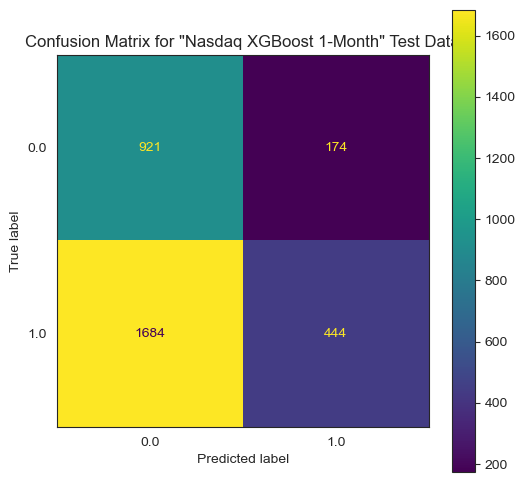

In [439]:
# Most practically useful model
XGBoost_N_1_month.confusion_matrix()

### Results
I chose to use XGBoost for similar reasons as before, where the train and test scores were most similar. Still, none of the models profiled particularly well, as is becoming the theme for 1 and 3 month targets. Mean gains were twice as large for XGBoost, annualizing at 27.6%. The overall profile is much better for XGBoost compared to the dummy model. 

count    618.000000
mean       0.023002
std        0.055835
min       -0.283600
25%       -0.006306
50%        0.032893
75%        0.055743
max        0.244379
Name: One_Month_Change, dtype: float64

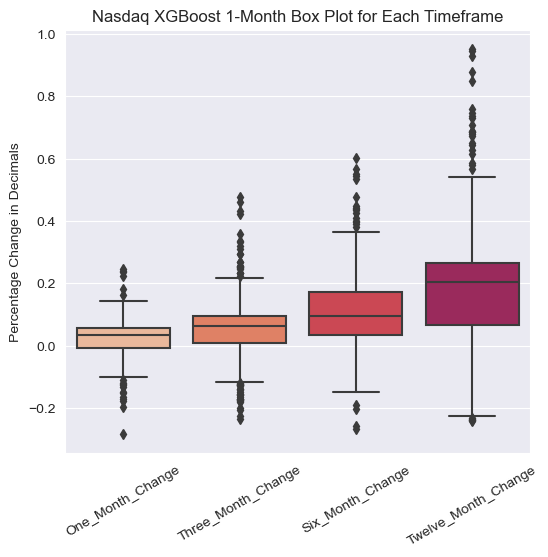

In [443]:
# Most precise model profile
describe_predictions(XGBoost_N_1_month, ticker="^IXIC", df=df, cat=1, box=True)["One_Month_Change"]

count    3223.000000
mean        0.011557
std         0.052548
min        -0.294478
25%        -0.015679
50%         0.018132
75%         0.043914
max         0.244379
Name: One_Month_Change, dtype: float64

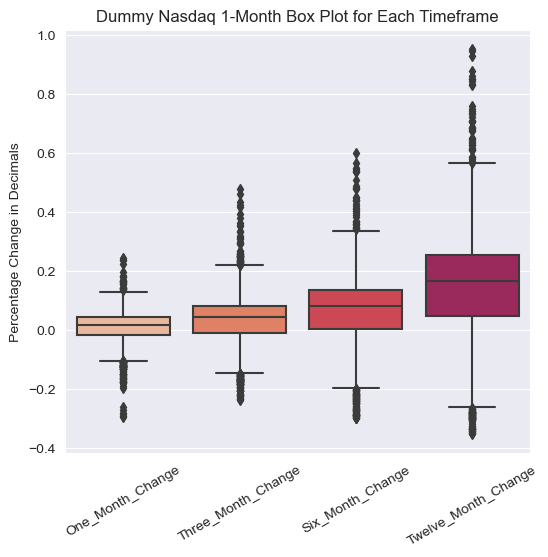

In [444]:
# Dummy Profile
describe_predictions(dummy_N_1_month, ticker="^IXIC", df=df, cat=1, box=True)["One_Month_Change"]

In [445]:
# Feature importances for the best model
features_from_trees(XGBoost_N_1_month)
Importance.df

Top 5 Feature Importances
('cycle_year_3', 0.067556985)
('Month_1', 0.065154105)
('Quarter_4', 0.04737686)
('GDP_Filled', 0.040414058)
('Month_6', 0.036610473)


Adj Close     Close      High       Low      Open    Volume  \
12-Month Dow   0.040632  0.037007  0.042715  0.037906  0.031394  0.022302   
1-Month Dow    0.047910  0.046397  0.041861  0.044876  0.040230  0.027051   
3-Month Dow    0.025346  0.000000  0.040976  0.014000  0.006188  0.007736   
6-Month Dow    0.044568  0.042131  0.034391  0.040268  0.037906  0.020627   
S&P 1-Month    0.044932  0.044793  0.043455  0.041550  0.025632  0.025253   
S&P 3-Month    0.019316  0.000000  0.018866  0.012285  0.002937  0.008108   
S&P 6-Month    0.041554  0.039364  0.039479  0.039635  0.022491  0.031403   
S&P 12-Month   0.040410  0.041263  0.044003  0.044385  0.041698  0.022166   
8              0.021892  0.000000  0.026331  0.026113  0.007612  0.008947   

              GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
12-Month Dow    0.121256        0.099205  0.005304  0.005326  0.007362   
1-Month Dow     0.049119        0.058243  0.016385  0.015627  0.015127   
3-Month Dow     0.070060        0.033718  0.004473  0.003492  0.002693   
6-Month Dow     0.082010        0.064318  0.007295  0.006650  0.008046   
S&P 1-Month     0.037787        0.047341  0.013726  0.013598  0.014276   
S&P 3-Month     0.052835        0.025877  0.003870  0.003956  0.004274   
S&P 6-Month     0.092478        0.065941  0.006025  0.005680  0.006364   
S&P 12-Month    0.085122        0.039196  0.003119  0.002874  0.003756   
8               0.040414        0.023354  0.004780  0.005429  0.004232   

                   RMW       CMA  garman_klass_vol       RSI  \
12-Month Dow  0.007724  0.010244          0.006258  0.015604   
1-Month Dow   0.015592  0.016332          0.019209  0.041324   
3-Month Dow   0.006508  0.005923          0.004837  0.016786   
6-Month Dow   0.008030  0.008023          0.008472  0.022335   
S&P 1-Month   0.014694  0.014226          0.015268  0.038545   
S&P 3-Month   0.003110  0.003619          0.004425  0.013655   
S&P 6-Month   0.007230  0.006941          0.011722  0.020891   
S&P 12-Month  0.003831  0.004000          0.007383  0.012668   
8             0.003717  0.003771          0.004215  0.017072   

              lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
12-Month Dow               0.039960              0.043111    0.041155   
1-Month Dow                0.049670              0.045896    0.042415   
3-Month Dow                0.024541              0.025817    0.015513   
6-Month Dow                0.038930              0.040099    0.042214   
S&P 1-Month                0.043482              0.045839    0.044143   
S&P 3-Month                0.021667              0.032016    0.016200   
S&P 6-Month                0.044649              0.051109    0.049826   
S&P 12-Month               0.045723              0.047931    0.042930   
8                          0.024929              0.020827    0.014319   

              one_up_bollinger_band  upper_bollinger_band       ATR      MACD  \
12-Month Dow               0.031843              0.043800  0.046404  0.017998   
1-Month Dow                0.046067              0.046743  0.052982  0.049525   
3-Month Dow                0.029528              0.046542  0.034682  0.015104   
6-Month Dow                0.037619              0.039219  0.046635  0.028024   
S&P 1-Month                0.046495              0.046108  0.040109  0.044580   
S&P 3-Month                0.031716              0.018861  0.016439  0.017710   
S&P 6-Month                0.057169              0.059483  0.055580  0.028988   
S&P 12-Month               0.043014              0.051143  0.036329  0.015864   
8                          0.016299              0.027913  0.019630  0.013258   

              ...  Quarter_4   Month_1  Month_10  Month_11  Month_12  \
12-Month Dow  ...   0.014279  0.005447  0.005716  0.003006  0.005145   
1-Month Dow   ...   0.011129  0.009137  0.004313  0.003696  0.003661   
3-Month Dow   ...   0.007964  0.026322  0.005728  0.019336  0.034812   
6-Month Dow   ...   0.014001  0

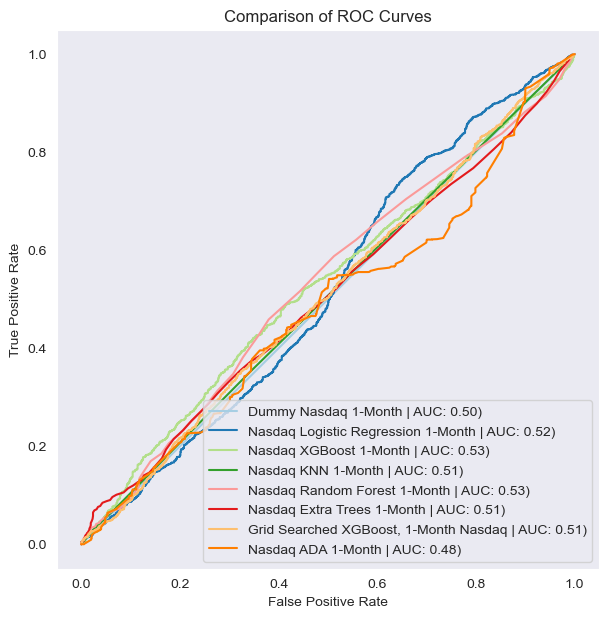

In [446]:
# Comparing model ROC curves

compare_curves([dummy_N_1_month, logreg_N_1_month, XGBoost_N_1_month, knn_N_1_month, rfc_N_1_month, etc_N_1_month, \
                grid_N_1_month, ada_N_1_month])

<hr style="border: 2px solid red;">

# 3 Month Nasdaq

In [479]:
# Create variables

X_train, X_test, y_train, y_test = select_data(nas_df, "Three")

# Create Model Objects

# dummy_N_3_month = dummy_model(Model, "Nasdaq", 3)
# logreg_N_3_month = l_regr(Model, "Nasdaq", 3)
# knn_N_3_month = knn(Model, "Nasdaq", 3)
# ada_N_3_month = ada(Model, "Nasdaq", 3)
# rfc_N_3_month = r_forest(Model, "Nasdaq", 3)
# etc_N_3_month = extra_trees(Model, "Nasdaq", 3)
# XGBoost_N_3_month = x_g_b(Model, "Nasdaq", 3)

# grid_N_3_month = best_etc_grid(estimator=rfc_N_3_month.model, model_type=Model, sector_name="Nasdaq", time_period=3)
# log_grid_N_3 = best_logreg_search(logreg_N_3_month.model, model_type=Model, sector_name="Nasdaq", time_period=3)
# knn_grid_N_3 = best_KNN_search(knn_N_3_month.model, Model, "Nasdaq", 3)

Model.model_df.iloc[77:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'model__algorithm': 'auto', 'model__leaf_size': 25, 'model__n_neighbors': 6, 'model__p': 2, 'model__weights': 'uniform'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.8s finished


name  train_accuracy  train_prec  \
80                   Nasdaq ADA 3-Month        0.419615    0.737799   
81         Nasdaq Random Forest 3-Month        0.421974    0.856567   
83               Nasdaq XGBoost 3-Month        0.417132    0.781422   
84  Grid Searched KNN, 12-Month Dow KNN        0.427561    0.754287   
86    Grid Searched KNN, 3-Month Nasdaq        0.427561    0.754287   
79                   Nasdaq KNN 3-Month        0.440099    0.749410   
85     Grid Searched LR, 3-Month Nasdaq        0.488144    0.744138   
78   Nasdaq Logistic Regression 3-Month        0.461949    0.724625   
77                 Dummy Nasdaq 3-Month        0.630168    0.630168   
82           Nasdaq Extra Trees 3-Month        0.433147    0.800933   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
80      0.132751  0.199424       0.745363       0.284828   1.000000   
81      0.111338  0.181567       1.476217       0.284828   1.000000   
83      0.163844  0.233159       3.362535       0.284518   0.888889   
84      0.168106  0.253199      14.084512       0.336333   0.785489   
86      0.168106  0.253199      14.084512       0.336333   0.785489   
79      0.206036  0.295498      14.691758       0.346572   0.780105   
85      0.457583  0.434761       8.071329       0.540800   0.751799   
78      0.398096  0.371468       8.349063       0.446789   0.731266   
77      1.000000  0.771425      13.330111       0.719826   0.719826   
82      0.193118  0.266876       1.180045       0.331058   0.697115   

    test_recall   test_f1  test_logloss       AUC  
80     0.006466  0.012848      0.923068  0.493786  
81     0.006466  0.012848      1.330818  0.477383  
83     0.006897  0.013687      6.474900  0.491498  
84     0.107328  0.188851     19.468690  0.494840  
86     0.107328  0.188851     19.468690  0.494840  
79     0.128448  0.220577     19.858151  0.497765  
85     0.540517  0.628887      2.645325  0.565161  
78     0.365948  0.487791      3.031820  0.563521  
77     1.000000  0.837092     10.098486  0.500000  
82     0.125000  0.211988      1.223875  0.452946

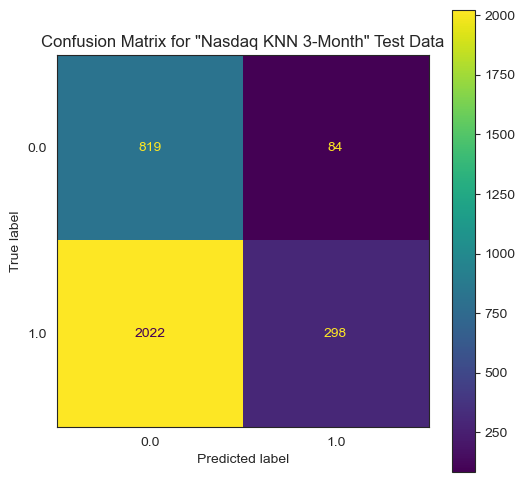

In [483]:
# Most practically useful model
knn_N_3_month.confusion_matrix()

### Results
The accuracy results were truly abhorrent, but some of the precision results were not too bad. I opted to use the LogisticRegression due to the number of positive predictions. Higher precision models predicted positve at such an infrequent rate that they would scarcely be able to be used. The choice to pursue the logistic regression model was not fruitful. The statistical profiles of both the LR model and dummy are very similar, with the exception being a smaller max gain for LR. There was a slightly smaller maximum loss, and the bottom 25% and above are all profitable, whereas the same cannot be said for the dummy model. The KNN model also had a similar profile to LR but had much better investment results. Therefore, KNN was the model best suited to make predictions on this data. It had a 27.2% annualized return, and did a much better job at limiting downside risk.

count    382.000000
mean       0.068123
std        0.095873
min       -0.170524
25%        0.009119
50%        0.069477
75%        0.114921
max        0.476732
Name: Three_Month_Change, dtype: float64

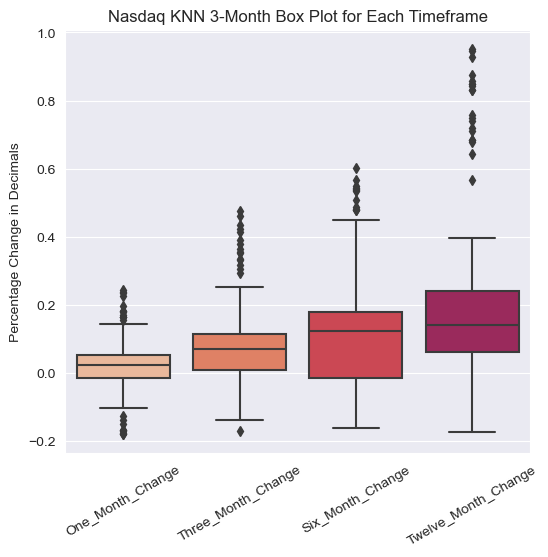

In [481]:
# Most precise model profile
describe_predictions(knn_N_3_month, ticker="^IXIC", df=df, cat=1, box=True)["Three_Month_Change"]

count    3223.000000
mean        0.034838
std         0.083031
min        -0.236357
25%        -0.009769
50%         0.045153
75%         0.082071
max         0.476732
Name: Three_Month_Change, dtype: float64

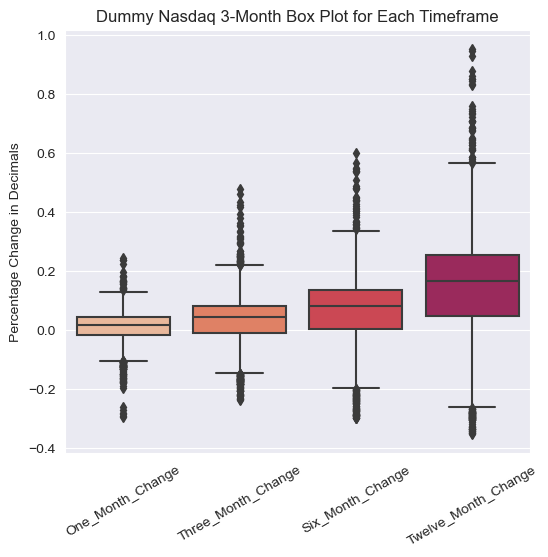

In [475]:
# Dummy Profile
describe_predictions(dummy_N_3_month, ticker="^IXIC", df=df, cat=1, box=True)["Three_Month_Change"]

In [484]:
# Feature importances for the best model
features_from_trees(etc_N_3_month)
Importance.df

Top 5 Feature Importances
('GDP_Filled', 0.05595919962156107)
('Interest_Rates', 0.052240308763002945)
('upper_bollinger_band', 0.04517529224926489)
('lower_bollinger_band', 0.04464973625393221)
('one_up_bollinger_band', 0.04443794718871645)


Adj Close     Close      High       Low      Open    Volume  \
12-Month Dow   0.040632  0.037007  0.042715  0.037906  0.031394  0.022302   
1-Month Dow    0.047910  0.046397  0.041861  0.044876  0.040230  0.027051   
3-Month Dow    0.025346  0.000000  0.040976  0.014000  0.006188  0.007736   
6-Month Dow    0.044568  0.042131  0.034391  0.040268  0.037906  0.020627   
S&P 1-Month    0.044932  0.044793  0.043455  0.041550  0.025632  0.025253   
S&P 3-Month    0.019316  0.000000  0.018866  0.012285  0.002937  0.008108   
S&P 6-Month    0.041554  0.039364  0.039479  0.039635  0.022491  0.031403   
S&P 12-Month   0.040410  0.041263  0.044003  0.044385  0.041698  0.022166   
8              0.021892  0.000000  0.026331  0.026113  0.007612  0.008947   
9              0.042290  0.043805  0.042763  0.042454  0.040857  0.018702   

              GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
12-Month Dow    0.121256        0.099205  0.005304  0.005326  0.007362   
1-Month Dow     0.049119        0.058243  0.016385  0.015627  0.015127   
3-Month Dow     0.070060        0.033718  0.004473  0.003492  0.002693   
6-Month Dow     0.082010        0.064318  0.007295  0.006650  0.008046   
S&P 1-Month     0.037787        0.047341  0.013726  0.013598  0.014276   
S&P 3-Month     0.052835        0.025877  0.003870  0.003956  0.004274   
S&P 6-Month     0.092478        0.065941  0.006025  0.005680  0.006364   
S&P 12-Month    0.085122        0.039196  0.003119  0.002874  0.003756   
8               0.040414        0.023354  0.004780  0.005429  0.004232   
9               0.055959        0.052240  0.005939  0.006315  0.006787   

                   RMW       CMA  garman_klass_vol       RSI  \
12-Month Dow  0.007724  0.010244          0.006258  0.015604   
1-Month Dow   0.015592  0.016332          0.019209  0.041324   
3-Month Dow   0.006508  0.005923          0.004837  0.016786   
6-Month Dow   0.008030  0.008023          0.008472  0.022335   
S&P 1-Month   0.014694  0.014226          0.015268  0.038545   
S&P 3-Month   0.003110  0.003619          0.004425  0.013655   
S&P 6-Month   0.007230  0.006941          0.011722  0.020891   
S&P 12-Month  0.003831  0.004000          0.007383  0.012668   
8             0.003717  0.003771          0.004215  0.017072   
9             0.006472  0.006670          0.005505  0.026573   

              lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
12-Month Dow               0.039960              0.043111    0.041155   
1-Month Dow                0.049670              0.045896    0.042415   
3-Month Dow                0.024541              0.025817    0.015513   
6-Month Dow                0.038930              0.040099    0.042214   
S&P 1-Month                0.043482              0.045839    0.044143   
S&P 3-Month                0.021667              0.032016    0.016200   
S&P 6-Month                0.044649              0.051109    0.049826   
S&P 12-Month               0.045723              0.047931    0.042930   
8                          0.024929              0.020827    0.014319   
9                          0.042935              0.044650    0.044215   

              one_up_bollinger_band  upper_bollinger_band       ATR      MACD  \
12-Month Dow               0.031843              0.043800  0.046404  0.017998   
1-Month Dow                0.046067              0.046743  0.052982  0.049525   
3-Month Dow                0.029528              0.046542  0.034682  0.015104   
6-Month Dow                0.037619              0.039219  0.046635  0.028024   
S&P 1-Month                0.046495              0.046108  0.040109  0.044580   
S&P 3-Month                0.031716              0.018861  0.016439  0.017710   
S&P 6-Month                0.057169              0.059483  0.055580  0.028988   
S&P 12-Month               0.043014              0.051143  0.036329  0.015864   
8                          0.016299              0.027913  0.019630  0.013258   
9                          0.044

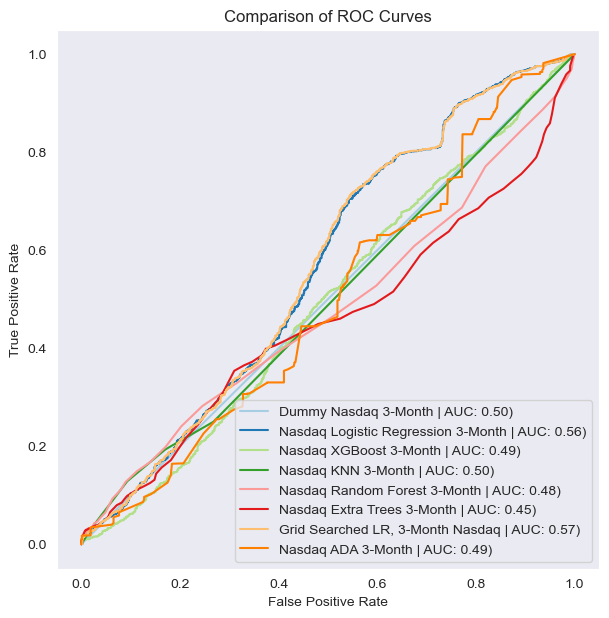

In [486]:
# Comparing model ROC curves

compare_curves([dummy_N_3_month, logreg_N_3_month, XGBoost_N_3_month, knn_N_3_month, rfc_N_3_month, etc_N_3_month, \
                log_grid_N_3, ada_N_3_month])

<hr style="border: 2px solid red;">

# 6 Month Nasdaq

In [496]:
# Create variables

X_train, X_test, y_train, y_test = select_data(nas_df, "Six")

# Create Model Objects

# dummy_N_6_month = dummy_model(Model, "Nasdaq", 6)
# logreg_N_6_month = l_regr(Model, "Nasdaq", 6)
# knn_N_6_month = knn(Model, "Nasdaq", 6)
# ada_N_6_month = ada(Model, "Nasdaq", 6)
# rfc_N_6_month = r_forest(Model, "Nasdaq", 6)
# etc_N_6_month = extra_trees(Model, "Nasdaq", 6)
# XGBoost_N_6_month = x_g_b(Model, "Nasdaq", 6)

# grid_N_6_month = best_etc_grid(estimator=etc_N_6_month.model, model_type=Model, sector_name="Nasdaq", time_period=6)

Model.model_df.iloc[87:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
91              Nasdaq Random Forest 6-Month        0.420981    0.886803   
92                Nasdaq Extra Trees 6-Month        0.441341    0.810572   
93                    Nasdaq XGBoost 6-Month        0.459963    0.725202   
88        Nasdaq Logistic Regression 6-Month        0.464804    0.841481   
87                      Dummy Nasdaq 6-Month        0.679578    0.679578   
89                        Nasdaq KNN 6-Month        0.431409    0.842856   
94  Grid Searched Tree Model, 6-Month Nasdaq        0.448045    0.849263   
90                        Nasdaq ADA 6-Month        0.481688    0.780765   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
91      0.300380  0.322859       1.639239       0.246975   1.000000   
92      0.363589  0.391186       1.251987       0.287000   1.000000   
93      0.450656  0.487666       2.462279       0.246665   1.000000   
88      0.394488  0.423487       9.383582       0.335402   0.793456   
87      1.000000  0.805882      11.549183       0.753646   0.753646   
89      0.334659  0.366550      17.348302       0.281105   0.690476   
94      0.372101  0.394274       0.997379       0.289792   0.664319   
90      0.478166  0.486543       0.751366       0.247285   0.600000   

    test_recall   test_f1  test_logloss       AUC  
91     0.000823  0.001645      1.342506  0.579113  
92     0.053932  0.102344      1.591860  0.367604  
93     0.000412  0.000823      6.899825  0.572393  
88     0.159737  0.265936      7.299281  0.603668  
87     1.000000  0.859519      8.879510  0.500000  
89     0.083573  0.149100     22.866044  0.490919  
94     0.116509  0.198249      1.199297  0.478627  
90     0.003705  0.007365      0.939274  0.576753

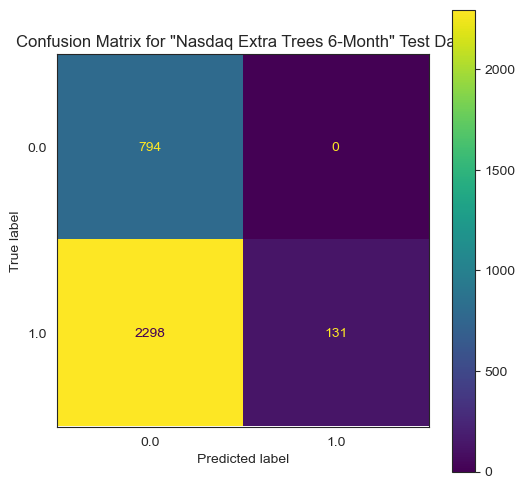

In [498]:
# Most practically useful model
etc_N_6_month.confusion_matrix()

### Results
ETC model both had 100% precision and enough predictions to be of reasonable worth. By grid searching, I was only able to 1-1 increase the true positives and negatives, so no real benefit. Mean gain on these predictions was an improvement of 10% over the dummy model, and there was also an eradication of negative returns. The maximum gain was also cut in half unfortunately.

count    131.000000
mean       0.178641
std        0.067715
min        0.014419
25%        0.134845
50%        0.172324
75%        0.229685
max        0.316098
Name: Six_Month_Change, dtype: float64

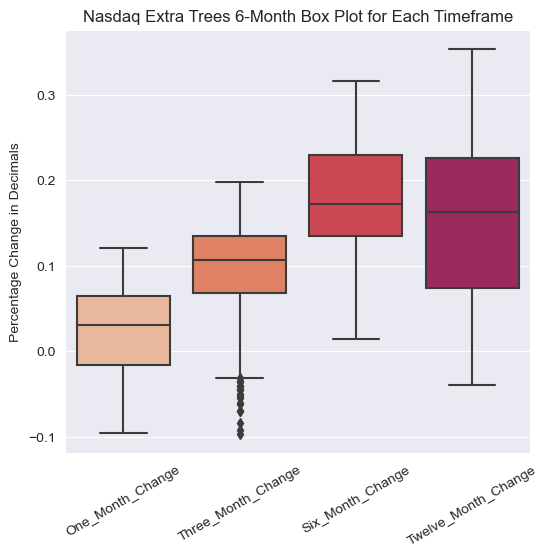

In [501]:
# Most precise model profile
describe_predictions(etc_N_6_month, ticker="^IXIC", df=df, cat=1, box=True)["Six_Month_Change"]

count    3223.000000
mean        0.070226
std         0.113277
min        -0.299387
25%         0.002626
50%         0.082188
75%         0.136688
max         0.600453
Name: Six_Month_Change, dtype: float64

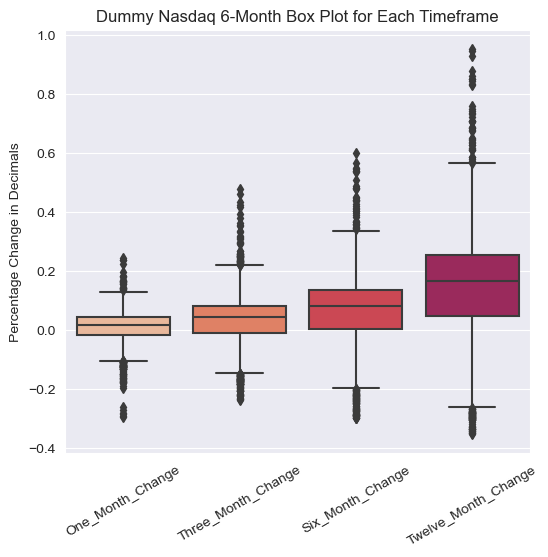

In [502]:
# Dummy Profile
describe_predictions(dummy_N_6_month, ticker="^IXIC", df=df, cat=1, box=True)["Six_Month_Change"]

In [503]:
# Feature importances for the best model
features_from_trees(etc_N_6_month)
Importance.df[-4:]

Top 5 Feature Importances
('GDP_Filled', 0.07339576593362142)
('Interest_Rates', 0.05651040513782322)
('upper_bollinger_band', 0.048232739585605026)
('ATR', 0.045994677778980454)
('one_up_bollinger_band', 0.04544181043278705)


Adj Close     Close      High       Low      Open    Volume  \
12-Month Dow   0.040632  0.037007  0.042715  0.037906  0.031394  0.022302   
1-Month Dow    0.047910  0.046397  0.041861  0.044876  0.040230  0.027051   
3-Month Dow    0.025346  0.000000  0.040976  0.014000  0.006188  0.007736   
6-Month Dow    0.044568  0.042131  0.034391  0.040268  0.037906  0.020627   
S&P 1-Month    0.044932  0.044793  0.043455  0.041550  0.025632  0.025253   
S&P 3-Month    0.019316  0.000000  0.018866  0.012285  0.002937  0.008108   
S&P 6-Month    0.041554  0.039364  0.039479  0.039635  0.022491  0.031403   
S&P 12-Month   0.040410  0.041263  0.044003  0.044385  0.041698  0.022166   
8              0.021892  0.000000  0.026331  0.026113  0.007612  0.008947   
9              0.042290  0.043805  0.042763  0.042454  0.040857  0.018702   
10             0.041900  0.041729  0.037509  0.042501  0.037971  0.018624   

              GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
12-Month Dow    0.121256        0.099205  0.005304  0.005326  0.007362   
1-Month Dow     0.049119        0.058243  0.016385  0.015627  0.015127   
3-Month Dow     0.070060        0.033718  0.004473  0.003492  0.002693   
6-Month Dow     0.082010        0.064318  0.007295  0.006650  0.008046   
S&P 1-Month     0.037787        0.047341  0.013726  0.013598  0.014276   
S&P 3-Month     0.052835        0.025877  0.003870  0.003956  0.004274   
S&P 6-Month     0.092478        0.065941  0.006025  0.005680  0.006364   
S&P 12-Month    0.085122        0.039196  0.003119  0.002874  0.003756   
8               0.040414        0.023354  0.004780  0.005429  0.004232   
9               0.055959        0.052240  0.005939  0.006315  0.006787   
10              0.073396        0.056510  0.003868  0.004416  0.004511   

                   RMW       CMA  garman_klass_vol       RSI  \
12-Month Dow  0.007724  0.010244          0.006258  0.015604   
1-Month Dow   0.015592  0.016332          0.019209  0.041324   
3-Month Dow   0.006508  0.005923          0.004837  0.016786   
6-Month Dow   0.008030  0.008023          0.008472  0.022335   
S&P 1-Month   0.014694  0.014226          0.015268  0.038545   
S&P 3-Month   0.003110  0.003619          0.004425  0.013655   
S&P 6-Month   0.007230  0.006941          0.011722  0.020891   
S&P 12-Month  0.003831  0.004000          0.007383  0.012668   
8             0.003717  0.003771          0.004215  0.017072   
9             0.006472  0.006670          0.005505  0.026573   
10            0.004420  0.004719          0.005752  0.018621   

              lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
12-Month Dow               0.039960              0.043111    0.041155   
1-Month Dow                0.049670              0.045896    0.042415   
3-Month Dow                0.024541              0.025817    0.015513   
6-Month Dow                0.038930              0.040099    0.042214   
S&P 1-Month                0.043482              0.045839    0.044143   
S&P 3-Month                0.021667              0.032016    0.016200   
S&P 6-Month                0.044649              0.051109    0.049826   
S&P 12-Month               0.045723              0.047931    0.042930   
8                          0.024929              0.020827    0.014319   
9                          0.042935              0.044650    0.044215   
10                         0.041771              0.043430    0.043848   

              one_up_bollinger_band  upper_bollinger_band       ATR      MACD  \
12-Month Dow               0.031843              0.043800  0.046404  0.017998   
1-Month Dow                0.046067              0.046743  0.052982  0.049525   
3-Month Dow                0.029528              0.046542  0.034682  0.015104   
6-Month Dow                0.037619              0.039219  0.046635  0.028024   
S&P 1-Month                0.046495              0.046108  0.040109  0.044580   
S&P 3-Month                0.031716              0.018861  0.016439 

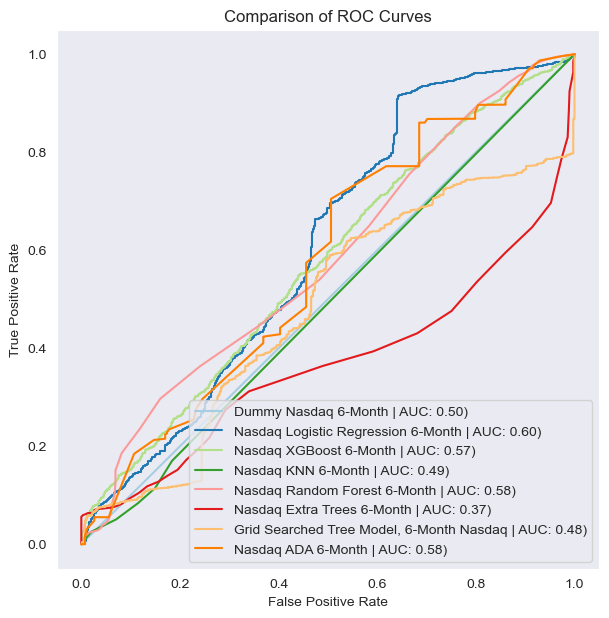

In [504]:
# Comparing model ROC curves

compare_curves([dummy_N_6_month, logreg_N_6_month, XGBoost_N_6_month, knn_N_6_month, rfc_N_6_month, etc_N_6_month, \
                grid_N_6_month, ada_N_6_month])

<hr style="border: 2px solid red;">

# 12 Month Nasdaq 

In [510]:
# Create variables

X_train, X_test, y_train, y_test = select_data(nas_df, "Twelve")

# Create Model Objects

# dummy_N_12_month = dummy_model(Model, "Nasdaq", 12)
# logreg_N_12_month = l_regr(Model, "Nasdaq", 12)
# knn_N_12_month = knn(Model, "Nasdaq", 12)
# ada_N_12_month = ada(Model, "Nasdaq", 12)
# rfc_N_12_month = r_forest(Model, "Nasdaq", 12)
# etc_N_12_month = extra_trees(Model, "Nasdaq", 12)
# XGBoost_N_12_month = x_g_b(Model, "Nasdaq", 12)

# grid_N_12_month = best_logreg_search(logreg_N_12_month.model, Model, "Nasdaq", 12)

Model.model_df.iloc[94:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
99              Nasdaq Random Forest 12-Month        0.419119    0.882563   
98                        Nasdaq ADA 12-Month        0.597765    0.844320   
96        Nasdaq Logistic Regression 12-Month        0.417753    0.908631   
101                   Nasdaq XGBoost 12-Month        0.566480    0.777378   
102         Grid Searched LR, 12-Month Nasdaq        0.414773    0.909490   
100               Nasdaq Extra Trees 12-Month        0.410180    0.803530   
97                        Nasdaq KNN 12-Month        0.434389    0.834264   
95                      Dummy Nasdaq 12-Month        0.735568    0.735568   
94   Grid Searched Tree Model, 6-Month Nasdaq        0.448045    0.849263   

     train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
99       0.349044  0.394598       2.188283       0.199193   0.991453   
98       0.660856  0.610732       0.770464       0.374806   0.952191   
96       0.353003  0.396865      10.563879       0.258455   0.939655   
101      0.659628  0.635407       1.967833       0.216568   0.938462   
102      0.348263  0.387933      11.029570       0.252560   0.936170   
100      0.372884  0.418343       2.325382       0.231772   0.916667   
97       0.389491  0.428973      16.040083       0.225566   0.909836   
95       1.000000  0.842653       9.531096       0.836488   0.836488   
94       0.372101  0.394274       0.997379       0.289792   0.664319   

     test_recall   test_f1  test_logloss       AUC  
99      0.043027  0.082474      2.117599  0.493191  
98      0.265950  0.415773      0.910538  0.627157  
96      0.121291  0.214849      9.809730  0.757488  
101     0.067878  0.126600      4.277966  0.461166  
102     0.114243  0.203636      9.983788  0.757443  
100     0.089763  0.163514      2.664161  0.565933  
97      0.082344  0.151020     26.776985  0.530236  
95      1.000000  0.910965      5.893579  0.500000  
94      0.116509  0.198249      1.199297  0.478627

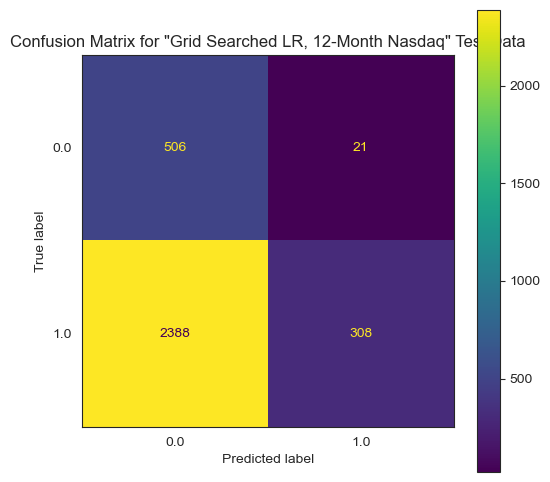

In [511]:
# Most practically useful model
grid_N_12_month.confusion_matrix()

### Results
Logistic Regression again provided some very promising results, and enough positive classifications to be worthwhile. While the grid searched model performed slightly worse on test data, it had a better training score, giving me the impression that it would likely generalize better. Mean gain between dummy and grid model were nearly identical, however the max loss and gains were radically different. Once again, our model managed to reduce negative potential, but also capped the upside. 

count    329.000000
mean       0.148392
std        0.093077
min       -0.039955
25%        0.072282
50%        0.151865
75%        0.212344
max        0.403299
Name: Twelve_Month_Change, dtype: float64

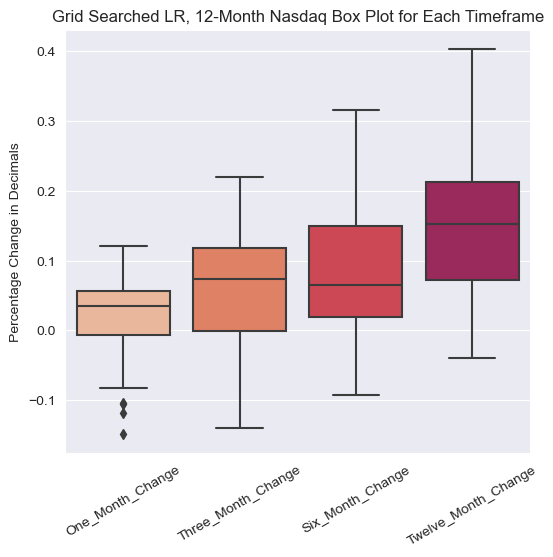

In [515]:
# Most precise model profile
describe_predictions(grid_N_12_month, ticker="^IXIC", df=df, cat=1, box=True)["Twelve_Month_Change"]

count    3223.000000
mean        0.151798
std         0.172612
min        -0.352840
25%         0.047918
50%         0.167220
75%         0.254986
max         0.951104
Name: Twelve_Month_Change, dtype: float64

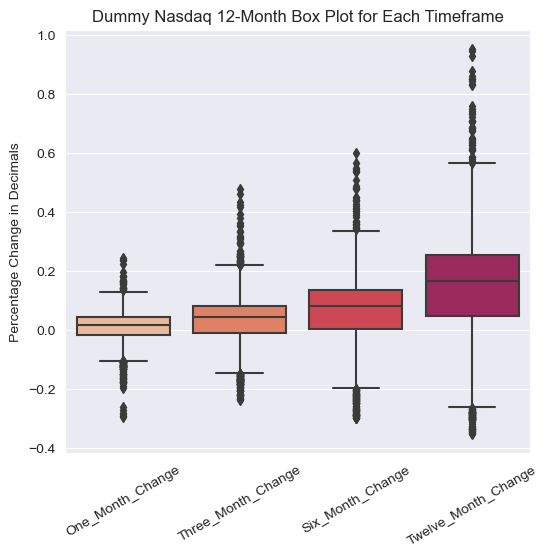

In [514]:
# Dummy Profile
describe_predictions(dummy_N_12_month, ticker="^IXIC", df=df, cat=1, box=True)["Twelve_Month_Change"]

In [539]:
coefs_from_lr(grid_N_12_month)
Importance.df

Adj Close     Close      High       Low      Open    Volume  \
12-Month Dow   0.040632  0.037007  0.042715  0.037906  0.031394  0.022302   
1-Month Dow    0.047910  0.046397  0.041861  0.044876  0.040230  0.027051   
3-Month Dow    0.025346  0.000000  0.040976  0.014000  0.006188  0.007736   
6-Month Dow    0.044568  0.042131  0.034391  0.040268  0.037906  0.020627   
S&P 1-Month    0.044932  0.044793  0.043455  0.041550  0.025632  0.025253   
S&P 3-Month    0.019316  0.000000  0.018866  0.012285  0.002937  0.008108   
S&P 6-Month    0.041554  0.039364  0.039479  0.039635  0.022491  0.031403   
S&P 12-Month   0.040410  0.041263  0.044003  0.044385  0.041698  0.022166   
8              0.021892  0.000000  0.026331  0.026113  0.007612  0.008947   
9              0.042290  0.043805  0.042763  0.042454  0.040857  0.018702   
10             0.041900  0.041729  0.037509  0.042501  0.037971  0.018624   
11            -0.810273 -0.810273  0.822179 -0.953719  0.764579  2.055675   

              GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
12-Month Dow    0.121256        0.099205  0.005304  0.005326  0.007362   
1-Month Dow     0.049119        0.058243  0.016385  0.015627  0.015127   
3-Month Dow     0.070060        0.033718  0.004473  0.003492  0.002693   
6-Month Dow     0.082010        0.064318  0.007295  0.006650  0.008046   
S&P 1-Month     0.037787        0.047341  0.013726  0.013598  0.014276   
S&P 3-Month     0.052835        0.025877  0.003870  0.003956  0.004274   
S&P 6-Month     0.092478        0.065941  0.006025  0.005680  0.006364   
S&P 12-Month    0.085122        0.039196  0.003119  0.002874  0.003756   
8               0.040414        0.023354  0.004780  0.005429  0.004232   
9               0.055959        0.052240  0.005939  0.006315  0.006787   
10              0.073396        0.056510  0.003868  0.004416  0.004511   
11              0.907857       -0.207416 -0.002636  0.006191  0.014644   

                   RMW       CMA  garman_klass_vol       RSI  \
12-Month Dow  0.007724  0.010244          0.006258  0.015604   
1-Month Dow   0.015592  0.016332          0.019209  0.041324   
3-Month Dow   0.006508  0.005923          0.004837  0.016786   
6-Month Dow   0.008030  0.008023          0.008472  0.022335   
S&P 1-Month   0.014694  0.014226          0.015268  0.038545   
S&P 3-Month   0.003110  0.003619          0.004425  0.013655   
S&P 6-Month   0.007230  0.006941          0.011722  0.020891   
S&P 12-Month  0.003831  0.004000          0.007383  0.012668   
8             0.003717  0.003771          0.004215  0.017072   
9             0.006472  0.006670          0.005505  0.026573   
10            0.004420  0.004719          0.005752  0.018621   
11           -0.084120 -0.102678          0.302931  0.112460   

              lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
12-Month Dow               0.039960              0.043111    0.041155   
1-Month Dow                0.049670              0.045896    0.042415   
3-Month Dow                0.024541              0.025817    0.015513   
6-Month Dow                0.038930              0.040099    0.042214   
S&P 1-Month                0.043482              0.045839    0.044143   
S&P 3-Month                0.021667              0.032016    0.016200   
S&P 6-Month                0.044649              0.051109    0.049826   
S&P 12-Month               0.045723              0.047931    0.042930   
8                          0.024929              0.020827    0.014319   
9                          0.042935              0.044650    0.044215   
10                         0.041771              0.043430    0.043848   
11                         0.871870              0.569400    0.285341   

              one_up_bollinger_band  upper_bollinger_band       ATR      MACD  \
12-Month Dow               0.031843              0.043800  0.046404  0.017998   
1-Month Dow                0.046067              0.046743  0.052982  0.049525   
3-Month Dow            

In [542]:
Importance.df.rename(index={8:"Nasdaq 1-Month", 9:"Nasdaq 3-Month", 10:'Nasdaq 6-Month', 11:"Nasdaq 12-Month"}, inplace=True)
Importance.df.tail(4)

Adj Close     Close      High       Low      Open    Volume  \
Nasdaq 1-Month    0.021892  0.000000  0.026331  0.026113  0.007612  0.008947   
Nasdaq 3-Month    0.042290  0.043805  0.042763  0.042454  0.040857  0.018702   
Nasdaq 6-Month    0.041900  0.041729  0.037509  0.042501  0.037971  0.018624   
Nasdaq 12-Month  -0.810273 -0.810273  0.822179 -0.953719  0.764579  2.055675   

                 GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
Nasdaq 1-Month     0.040414        0.023354  0.004780  0.005429  0.004232   
Nasdaq 3-Month     0.055959        0.052240  0.005939  0.006315  0.006787   
Nasdaq 6-Month     0.073396        0.056510  0.003868  0.004416  0.004511   
Nasdaq 12-Month    0.907857       -0.207416 -0.002636  0.006191  0.014644   

                      RMW       CMA  garman_klass_vol       RSI  \
Nasdaq 1-Month   0.003717  0.003771          0.004215  0.017072   
Nasdaq 3-Month   0.006472  0.006670          0.005505  0.026573   
Nasdaq 6-Month   0.004420  0.004719          0.005752  0.018621   
Nasdaq 12-Month -0.084120 -0.102678          0.302931  0.112460   

                 lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Nasdaq 1-Month                0.024929              0.020827    0.014319   
Nasdaq 3-Month                0.042935              0.044650    0.044215   
Nasdaq 6-Month                0.041771              0.043430    0.043848   
Nasdaq 12-Month               0.871870              0.569400    0.285341   

                 one_up_bollinger_band  upper_bollinger_band       ATR  \
Nasdaq 1-Month                0.016299              0.027913  0.019630   
Nasdaq 3-Month                0.044438              0.045175  0.042330   
Nasdaq 6-Month                0.045442              0.048233  0.045995   
Nasdaq 12-Month               0.018578             -0.231993 -0.737287   

                     MACD  ...  Quarter_4   Month_1  Month_10  Month_11  \
Nasdaq 1-Month   0.013258  ...   0.047377  0.065154  0.022893  0.010482   
Nasdaq 3-Month   0.031903  ...   0.017829  0.010465  0.006443  0.004964   
Nasdaq 6-Month   0.024079  ...   0.014439  0.008510  0.006413  0.004840   
Nasdaq 12-Month  0.346030  ...   0.217534 -0.133116  0.040112  0.165960   

                 Month_12   Month_2   Month_3   Month_4   Month_5   Month_6  \
Nasdaq 1-Month   0.025828  0.026709  0.026338  0.028940  0.013675  0.036610   
Nasdaq 3-Month   0.006830  0.006984  0.009793  0.010674  0.010274  0.009969   
Nasdaq 6-Month   0.007209  0.007446  0.008693  0.010128  0.007979  0.008874   
Nasdaq 12-Month  0.011461  0.107573  0.103877 -0.185639  0.003266  0.325165   

                  Month_7   Month_8   Month_9  cycle_year_1  cycle_year_2  \
Nasdaq 1-Month   0.029507  0.028270  0.036103      0.032732      0.032889   
Nasdaq 3-Month   0.011127  0.008065  0.011065      0.024446      0.020388   
Nasdaq 6-Month   0.009531  0.005117  0.006056      0.032041      0.030138   
Nasdaq 12-Month  0.118328  0.000432  0.051062     -0.552574      0.868574   

                 cycle_year_3  cycle_year_4  day_of_week_Friday  \
Nasdaq 1-Month       0.067557      0.018184            0.004517   
Nasdaq 3-Month       0.024254      0.021149            0.002376   
Nasdaq 6-Month       0.022876      0.031002            0.001766   
Nasdaq 12-Month      0.030702      0.261778            0.102821   

                 day_of_week_Monday  day_of_week_Thursday  \
Nasdaq 1-Month             0.002046              0.004078   
Nasdaq 3-Month             0.002488              0.002143   
Nasdaq 6-Month             0.001639              0.001441   
Nasdaq 12-Month            0.094305              0.152579   

                 day_of_week_Tuesday  day_of_week_Wednesday  
Nasdaq 1-Month              0.003391               0.003262  
Nasdaq 3-Month              0.002093               0.002140  
Nasdaq 6-Month              0.001591               0.001600  
Nasdaq 12-Month             0.128159               0.130615  

[4 rows x 48 columns]

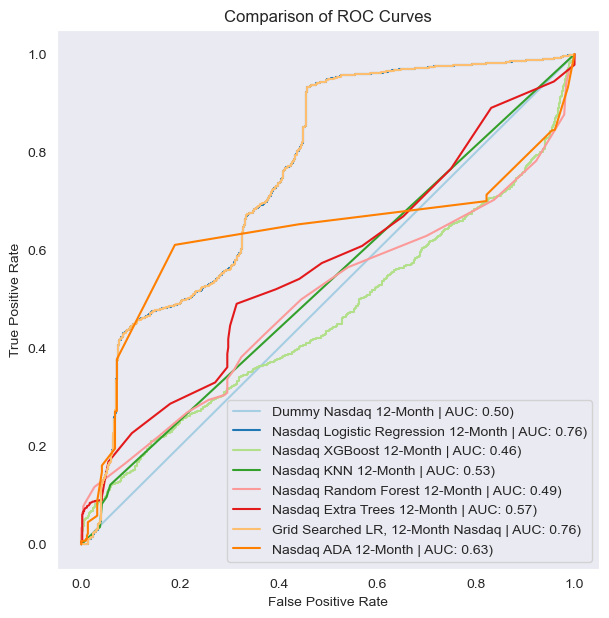

In [543]:
# Comparing model ROC curves

compare_curves([dummy_N_12_month, logreg_N_12_month, XGBoost_N_12_month, knn_N_12_month, rfc_N_12_month, etc_N_12_month, \
                grid_N_12_month, ada_N_12_month])

<hr style="border: 6px solid black">

# 1 Month Russell 2000 

In [548]:
# Create variables

X_train, X_test, y_train, y_test = select_data(rus_df, "One")

# Create Model Objects

# dummy_R_1_month = dummy_model(Model, "Russell", 1)
# logreg_R_1_month = l_regr(Model, "Russell", 1)
# knn_R_1_month = knn(Model, "Russell", 1)
# ada_R_1_month = ada(Model, "Russell", 1)
# rfc_R_1_month = r_forest(Model, "Russell", 1)
# etc_R_1_month = extra_trees(Model, "Russell", 1)
# XGBoost_R_1_month = x_g_b(Model, "Russell", 1)

# grid_R_1_month = best_etc_grid(estimator=rfc_R_1_month.model, model_type=Model, sector_name="Russell", time_period=1)

Model.model_df.iloc[103:].sort_values(by="test_prec", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.4s finished


name  train_accuracy  train_prec  \
104        Russell Logistic Regression 1-Month        0.515356    0.635531   
109                    Russell XGBoost 1-Month        0.452834    0.643019   
107              Russell Random Forest 1-Month        0.454479    0.688681   
110  Grid Searched Tree Model, 1-Month Russell        0.454479    0.688681   
106                        Russell ADA 1-Month        0.459415    0.665678   
105                        Russell KNN 1-Month        0.449177    0.650232   
108                Russell Extra Trees 1-Month        0.448446    0.672862   
103                      Dummy Russell 1-Month        0.617002    0.617002   

     train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
104      0.523023  0.526623       1.357447       0.500913   0.713615   
109      0.302803  0.359441       2.683115       0.467580   0.692580   
107      0.268807  0.352171       1.821537       0.501370   0.644094   
110      0.268807  0.352171       1.821537       0.501370   0.644094   
106      0.306582  0.329103       0.737023       0.453881   0.629508   
105      0.295016  0.358639       9.269336       0.555708   0.626254   
108      0.249415  0.331901       0.958065       0.530137   0.608275   
103      1.000000  0.762586      13.804653       0.582192   0.582192   

     test_recall   test_f1  test_logloss       AUC  
104     0.238431  0.357437      1.050861  0.578288  
109     0.153725  0.251605      2.770825  0.537978  
107     0.320784  0.428272      0.701996  0.571997  
110     0.320784  0.428272      0.701996  0.571997  
106     0.150588  0.243038      0.696342  0.521610  
105     0.587451  0.606232      5.222893  0.560403  
108     0.541961  0.573206      0.700533  0.548849  
103     1.000000  0.735931     15.059335  0.500000

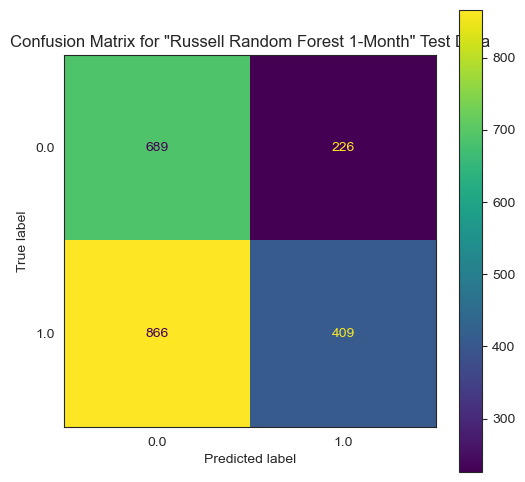

In [547]:
# Most practically useful model
rfc_R_1_month.confusion_matrix()

### Results
RFC had slightly higher train precision than test, but both were more or less in line and significantly better than the dummy model. RFC doubled mean gain from 0.6% for the dummy to 1.2% for RFC. The min and max losses/gains were equivalent between dummy and RFC. Median gain was much higher for the RFC model as well. There is not a clear visible difference between box plots for 1-month, however, the quartile metrics are quite different, enough to suggest a substantive improvement. 

count    635.000000
mean       0.011949
std        0.070706
min       -0.402212
25%       -0.020863
50%        0.019305
75%        0.052312
max        0.224172
Name: One_Month_Change, dtype: float64

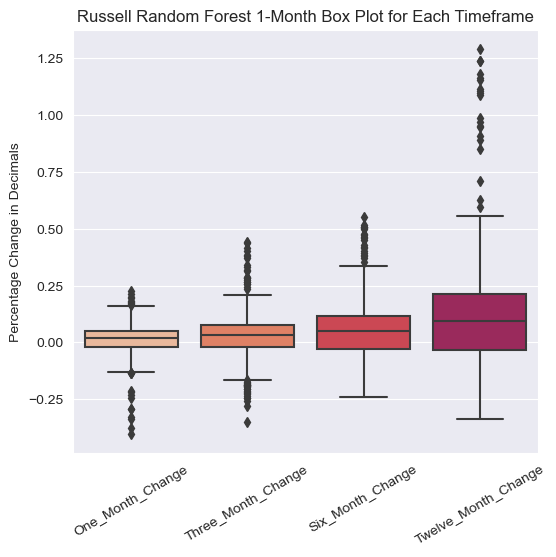

In [551]:
# Most precise model profile
describe_predictions(rfc_R_1_month, ticker="^RUT", df=df, cat=1, box=True)["One_Month_Change"]

count    2190.000000
mean        0.006630
std         0.061961
min        -0.411257
25%        -0.025176
50%         0.009788
75%         0.039750
max         0.224172
Name: One_Month_Change, dtype: float64

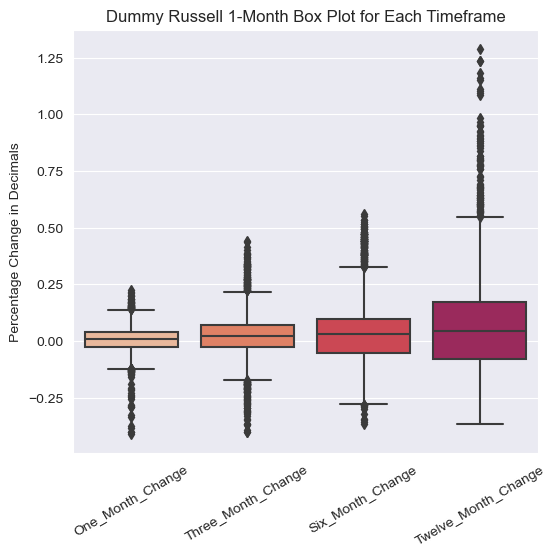

In [552]:
# Dummy Profile
describe_predictions(dummy_R_1_month, ticker="^RUT", df=df, cat=1, box=True)["One_Month_Change"]

In [553]:
# Feature importances for the best model
features_from_trees(rfc_R_1_month)
Importance.df[-4:]

Top 5 Feature Importances
('Interest_Rates', 0.05721983297037012)
('ATR', 0.056452361155270935)
('lowest_bollinger_band', 0.05339509111407113)
('one_up_bollinger_band', 0.053263111430345386)
('upper_bollinger_band', 0.052490584325958115)


Adj Close     Close      High       Low      Open    Volume  \
Nasdaq 3-Month    0.042290  0.043805  0.042763  0.042454  0.040857  0.018702   
Nasdaq 6-Month    0.041900  0.041729  0.037509  0.042501  0.037971  0.018624   
Nasdaq 12-Month  -0.810273 -0.810273  0.822179 -0.953719  0.764579  2.055675   
12                0.043152  0.039275  0.040822  0.041221  0.035546  0.028341   

                 GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
Nasdaq 3-Month     0.055959        0.052240  0.005939  0.006315  0.006787   
Nasdaq 6-Month     0.073396        0.056510  0.003868  0.004416  0.004511   
Nasdaq 12-Month    0.907857       -0.207416 -0.002636  0.006191  0.014644   
12                 0.049751        0.057220  0.014507  0.014305  0.016177   

                      RMW       CMA  garman_klass_vol       RSI  \
Nasdaq 3-Month   0.006472  0.006670          0.005505  0.026573   
Nasdaq 6-Month   0.004420  0.004719          0.005752  0.018621   
Nasdaq 12-Month -0.084120 -0.102678          0.302931  0.112460   
12               0.016086  0.015228          0.018359  0.037301   

                 lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Nasdaq 3-Month                0.042935              0.044650    0.044215   
Nasdaq 6-Month                0.041771              0.043430    0.043848   
Nasdaq 12-Month               0.871870              0.569400    0.285341   
12                            0.053395              0.051143    0.049228   

                 one_up_bollinger_band  upper_bollinger_band       ATR  \
Nasdaq 3-Month                0.044438              0.045175  0.042330   
Nasdaq 6-Month                0.045442              0.048233  0.045995   
Nasdaq 12-Month               0.018578             -0.231993 -0.737287   
12                            0.053263              0.052491  0.056452   

                     MACD  ...  Quarter_4   Month_1  Month_10  Month_11  \
Nasdaq 3-Month   0.031903  ...   0.017829  0.010465  0.006443  0.004964   
Nasdaq 6-Month   0.024079  ...   0.014439  0.008510  0.006413  0.004840   
Nasdaq 12-Month  0.346030  ...   0.217534 -0.133116  0.040112  0.165960   
12               0.047878  ...   0.007289  0.007639  0.007100  0.005364   

                 Month_12   Month_2   Month_3   Month_4   Month_5   Month_6  \
Nasdaq 3-Month   0.006830  0.006984  0.009793  0.010674  0.010274  0.009969   
Nasdaq 6-Month   0.007209  0.007446  0.008693  0.010128  0.007979  0.008874   
Nasdaq 12-Month  0.011461  0.107573  0.103877 -0.185639  0.003266  0.325165   
12               0.005921  0.006196  0.006794  0.004665  0.004506  0.005149   

                  Month_7   Month_8   Month_9  cycle_year_1  cycle_year_2  \
Nasdaq 3-Month   0.011127  0.008065  0.011065      0.024446      0.020388   
Nasdaq 6-Month   0.009531  0.005117  0.006056      0.032041      0.030138   
Nasdaq 12-Month  0.118328  0.000432  0.051062     -0.552574      0.868574   
12               0.006381  0.003821  0.004668      0.006831      0.011914   

                 cycle_year_3  cycle_year_4  day_of_week_Friday  \
Nasdaq 3-Month       0.024254      0.021149            0.002376   
Nasdaq 6-Month       0.022876      0.031002            0.001766   
Nasdaq 12-Month      0.030702      0.261778            0.102821   
12                   0.006085      0.005458            0.001496   

                 day_of_week_Monday  day_of_week_Thursday  \
Nasdaq 3-Month             0.002488              0.002143   
Nasdaq 6-Month             0.001639              0.001441   
Nasdaq 12-Month            0.094305              0.152579   
12                         0.001745              0.001602   

                 day_of_week_Tuesday  day_of_week_Wednesday  
Nasdaq 3-Month              0.002093               0.002140  
Nasdaq 6-Month              0.001591               0.001600  
Nasdaq 12-Month             0.128159               0.130615  
12                          0.001515               0.001560  

[4 rows x 48 columns]

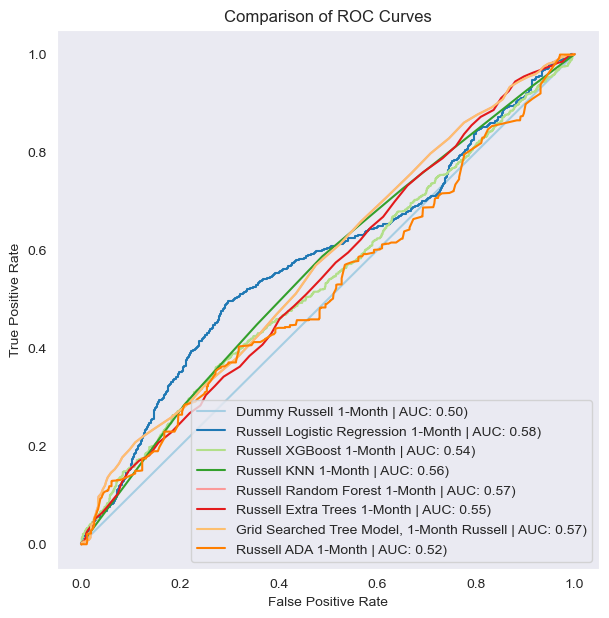

In [554]:
# Comparing model ROC curves

compare_curves([dummy_R_1_month, logreg_R_1_month, XGBoost_R_1_month, knn_R_1_month, rfc_R_1_month, etc_R_1_month, \
                grid_R_1_month, ada_R_1_month])

<hr style="border: 2px solid red;">

# 3 Month Russell

In [563]:
# Create variables

X_train, X_test, y_train, y_test = select_data(rus_df, "Three")

# Create Model Objects

# dummy_R_3_month = dummy_model(Model, "Russell", 3)
# logreg_R_3_month = l_regr(Model, "Russell", 3)
# knn_R_3_month = knn(Model, "Russell", 3)
# ada_R_3_month = ada(Model, "Russell", 3)
# rfc_R_3_month = r_forest(Model, "Russell", 3)
# etc_R_3_month = extra_trees(Model, "Russell", 3)
# XGBoost_R_3_month = x_g_b(Model, "Russell", 3)

# grid_R_3_month = best_etc_grid(estimator=etc_R_3_month.model, model_type=Model, sector_name="Russell", time_period=3)
# grid_XG_R_3 = best_XGB_grid(XGBoost_R_3_month.model, Model, "Russell", 12)
Model.model_df.iloc[111:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
115            Russell Random Forest 3-Month        0.430713    0.774128   
117                  Russell XGBoost 3-Month        0.469287    0.744017   
112      Russell Logistic Regression 3-Month        0.523583    0.684911   
113                      Russell KNN 3-Month        0.496527    0.752433   
118  Grid Searched XGBoost, 12-Month Russell        0.466910    0.805155   
116              Russell Extra Trees 3-Month        0.476417    0.803519   
114                      Russell ADA 3-Month        0.439305    0.821524   
111                    Dummy Russell 3-Month        0.639671    0.639671   

     train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
115      0.225770  0.299482       1.077262       0.462557   0.970060   
117      0.288076  0.402360       2.317196       0.473059   0.761628   
112      0.488581  0.496888       2.236493       0.504566   0.748503   
113      0.421875  0.487548       9.676908       0.538813   0.720708   
118      0.265130  0.373638       2.637044       0.486758   0.711694   
116      0.305408  0.409229       0.913699       0.553425   0.710900   
114      0.208691  0.290784       0.767502       0.501826   0.630505   
111      1.000000  0.778147      12.987576       0.609132   0.609132   

     test_recall   test_f1  test_logloss       AUC  
115     0.121439  0.215856      0.800743  0.636850  
117     0.196402  0.312277      2.110057  0.613679  
112     0.281109  0.408719      1.373395  0.623207  
113     0.396552  0.511605      5.330841  0.605383  
118     0.264618  0.385792      2.066513  0.619974  
116     0.449775  0.550964      0.715641  0.586398  
114     0.440030  0.518322      0.695199  0.526308  
111     1.000000  0.757094     14.088296  0.500000

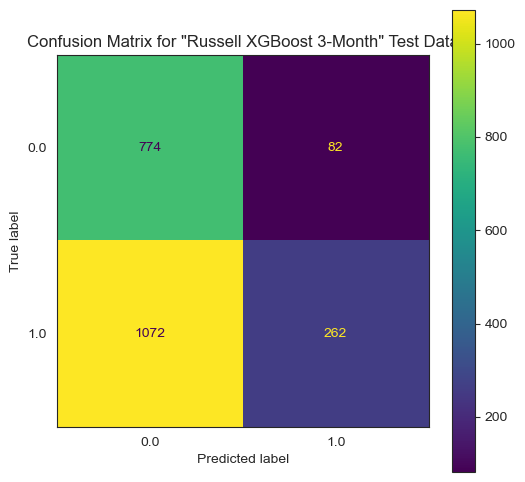

In [564]:
# Most practically useful model
XGBoost_R_3_month.confusion_matrix()

### Results
I opted to pursue optimization of the XGBoost model due to the consistency of its scores. While the grid search did improve train precision, it failed to generalize to the test data, and I felt that the default XGBoost model would be a better representative to model this data. XGBoost more than doubled mean gains of the dummy model, and shaved 10% off of the maximum downside prediction from 40% to 30%. This model's gains annualize to 19%, which is certainly not the worst performance. The maximum gain was only curtailed by 3% compared to the dummy model. 

count    344.000000
mean       0.045437
std        0.097163
min       -0.296453
25%        0.003621
50%        0.047425
75%        0.085347
max        0.413891
Name: Three_Month_Change, dtype: float64

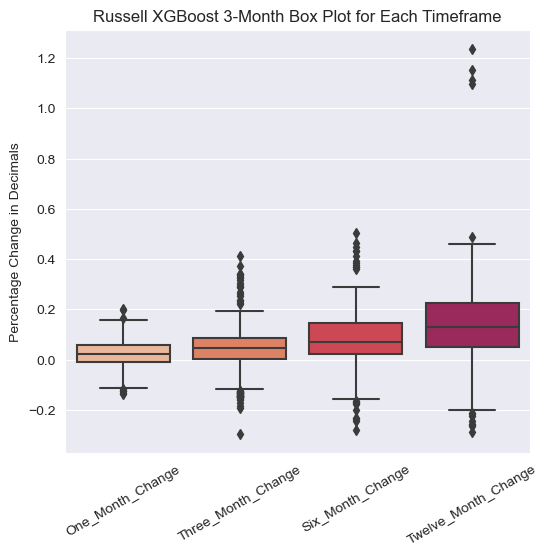

In [567]:
# Most precise model profile
describe_predictions(XGBoost_R_3_month, ticker="^RUT", df=df, cat=1, box=True)["Three_Month_Change"]

count    2190.000000
mean        0.019120
std         0.102889
min        -0.403537
25%        -0.028080
50%         0.020237
75%         0.069055
max         0.440060
Name: Three_Month_Change, dtype: float64

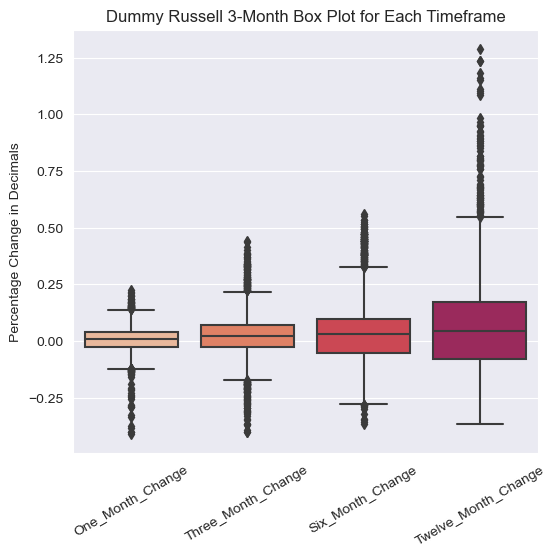

In [568]:
# Dummy Profile
describe_predictions(dummy_R_3_month, ticker="^RUT", df=df, cat=1, box=True)["Three_Month_Change"]

In [569]:
# Feature importances for the best model
features_from_trees(XGBoost_R_3_month)
Importance.df[-4:]

Top 5 Feature Importances
('cycle_year_3', 0.0896221)
('cycle_year_1', 0.083544895)
('Quarter_4', 0.06366623)
('Month_3', 0.06363915)
('GDP_Filled', 0.047565956)


Adj Close     Close      High       Low      Open    Volume  \
Nasdaq 6-Month    0.041900  0.041729  0.037509  0.042501  0.037971  0.018624   
Nasdaq 12-Month  -0.810273 -0.810273  0.822179 -0.953719  0.764579  2.055675   
12                0.043152  0.039275  0.040822  0.041221  0.035546  0.028341   
13                0.025090  0.000000  0.031190  0.033704  0.008283  0.015352   

                 GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
Nasdaq 6-Month     0.073396        0.056510  0.003868  0.004416  0.004511   
Nasdaq 12-Month    0.907857       -0.207416 -0.002636  0.006191  0.014644   
12                 0.049751        0.057220  0.014507  0.014305  0.016177   
13                 0.047566        0.025258  0.003485  0.002874  0.002428   

                      RMW       CMA  garman_klass_vol       RSI  \
Nasdaq 6-Month   0.004420  0.004719          0.005752  0.018621   
Nasdaq 12-Month -0.084120 -0.102678          0.302931  0.112460   
12               0.016086  0.015228          0.018359  0.037301   
13               0.003507  0.002291          0.002951  0.011018   

                 lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Nasdaq 6-Month                0.041771              0.043430    0.043848   
Nasdaq 12-Month               0.871870              0.569400    0.285341   
12                            0.053395              0.051143    0.049228   
13                            0.012739              0.027302    0.015041   

                 one_up_bollinger_band  upper_bollinger_band       ATR  \
Nasdaq 6-Month                0.045442              0.048233  0.045995   
Nasdaq 12-Month               0.018578             -0.231993 -0.737287   
12                            0.053263              0.052491  0.056452   
13                            0.027065              0.026916  0.026417   

                     MACD  ...  Quarter_4   Month_1  Month_10  Month_11  \
Nasdaq 6-Month   0.024079  ...   0.014439  0.008510  0.006413  0.004840   
Nasdaq 12-Month  0.346030  ...   0.217534 -0.133116  0.040112  0.165960   
12               0.047878  ...   0.007289  0.007639  0.007100  0.005364   
13               0.017353  ...   0.063666  0.012911  0.009457  0.030539   

                 Month_12   Month_2   Month_3   Month_4   Month_5   Month_6  \
Nasdaq 6-Month   0.007209  0.007446  0.008693  0.010128  0.007979  0.008874   
Nasdaq 12-Month  0.011461  0.107573  0.103877 -0.185639  0.003266  0.325165   
12               0.005921  0.006196  0.006794  0.004665  0.004506  0.005149   
13               0.027129  0.015491  0.063639  0.021920  0.004216  0.006977   

                  Month_7   Month_8   Month_9  cycle_year_1  cycle_year_2  \
Nasdaq 6-Month   0.009531  0.005117  0.006056      0.032041      0.030138   
Nasdaq 12-Month  0.118328  0.000432  0.051062     -0.552574      0.868574   
12               0.006381  0.003821  0.004668      0.006831      0.011914   
13               0.045248  0.026121  0.015470      0.083545      0.010311   

                 cycle_year_3  cycle_year_4  day_of_week_Friday  \
Nasdaq 6-Month       0.022876      0.031002            0.001766   
Nasdaq 12-Month      0.030702      0.261778            0.102821   
12                   0.006085      0.005458            0.001496   
13                   0.089622      0.027060            0.002643   

                 day_of_week_Monday  day_of_week_Thursday  \
Nasdaq 6-Month             0.001639              0.001441   
Nasdaq 12-Month            0.094305              0.152579   
12                         0.001745              0.001602   
13                         0.001363              0.001941   

                 day_of_week_Tuesday  day_of_week_Wednesday  
Nasdaq 6-Month              0.001591               0.001600  
Nasdaq 12-Month             0.128159               0.130615  
12                          0.001515               0.001560  
13                          0.000983               0.001183  

[4 rows x 48 columns]

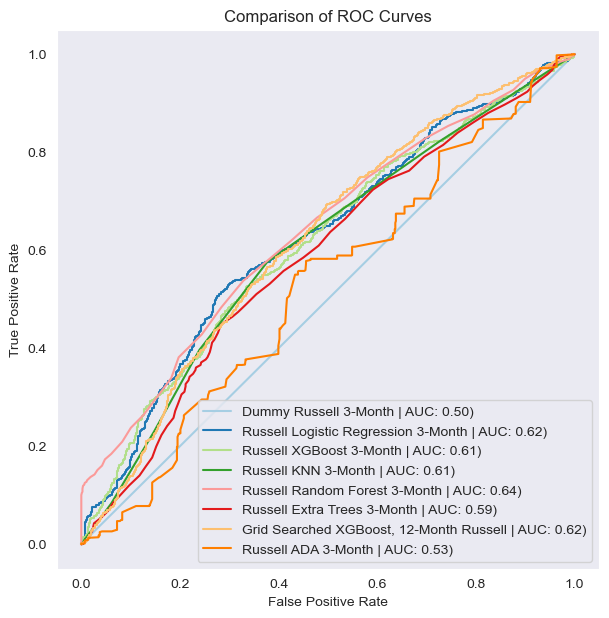

In [571]:
# Comparing model ROC curves

compare_curves([dummy_R_3_month, logreg_R_3_month, XGBoost_R_3_month, knn_R_3_month, rfc_R_3_month, etc_R_3_month, \
                grid_XG_R_3, ada_R_3_month])

<hr style="border: 2px solid red;">

# 6 Month Russell

In [579]:
# Create variables

X_train, X_test, y_train, y_test = select_data(rus_df, "Six")

# Create Model Objects

# dummy_R_6_month = dummy_model(Model, "Russell", 6)
# logreg_R_6_month = l_regr(Model, "Russell", 6)
# knn_R_6_month = knn(Model, "Russell", 6)
# ada_R_6_month = ada(Model, "Russell", 6)
# rfc_R_6_month = r_forest(Model, "Russell", 6)
# etc_R_6_month = extra_trees(Model, "Russell", 6)
# XGBoost_R_6_month = x_g_b(Model, "Russell", 6)

# grid_R_6_month = best_XGB_grid(XGBoost_R_6_month.model, Model, "Russell", 6)

Model.model_df.iloc[119:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
123           Russell Random Forest 6-Month        0.448629    0.571766   
126  Grid Searched XGBoost, 6-Month Russell        0.471298    0.776310   
125                 Russell XGBoost 6-Month        0.456307    0.713472   
124             Russell Extra Trees 6-Month        0.470567    0.568206   
121                     Russell KNN 6-Month        0.454479    0.747606   
120     Russell Logistic Regression 6-Month        0.508044    0.641638   
122                     Russell ADA 6-Month        0.466910    0.787865   
119                   Dummy Russell 6-Month        0.682084    0.682084   

     train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
123      0.431703  0.435834       1.120798       0.494521   0.788571   
126      0.452120  0.492638       2.948893       0.634247   0.755533   
125      0.440415  0.486951       2.692374       0.633333   0.726703   
124      0.468529  0.481534       0.948895       0.677169   0.675613   
121      0.471443  0.488299      14.215332       0.615068   0.673881   
120      0.419195  0.448712       4.668792       0.447945   0.662338   
122      0.489587  0.459379       0.778626       0.628767   0.630252   
119      1.000000  0.807466      11.458851       0.597717   0.597717   

     test_recall   test_f1  test_logloss       AUC  
123     0.210848  0.332731      0.759406  0.686687  
126     0.573720  0.652193      1.122800  0.685866  
125     0.619557  0.668866      0.883051  0.681369  
124     0.884645  0.766126      0.613039  0.725271  
121     0.689840  0.681767      4.646953  0.617258  
120     0.155844  0.252319      1.703132  0.663191  
122     0.916730  0.746965      0.691475  0.464466  
119     1.000000  0.748214     14.499753  0.500000

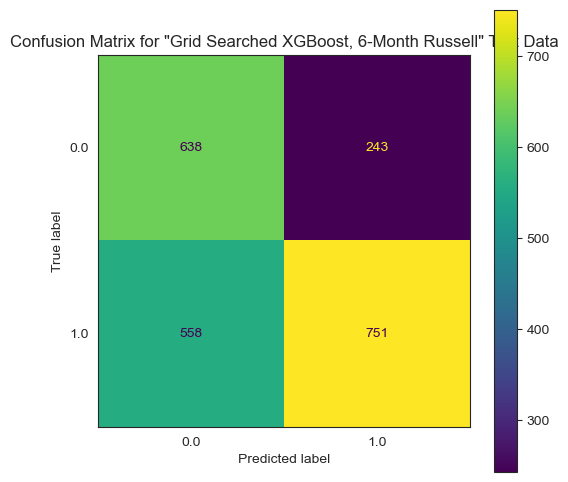

In [580]:
# Most practically useful model
grid_R_6_month.confusion_matrix()

### Results
XGBoost once again had the best alignment between train and test, both outpacing the dummy's precision. The grid search managed to improve both train and test precision this time, so that made for an easy representative. The grid model improved on the mean gains by 4.4%. The entire statistical profile of our model improves upon the dummy. 16% annualized earnings are not the highest, but the reliability of the earnings is strong.

count    994.000000
mean       0.080934
std        0.144755
min       -0.233758
25%        0.002402
50%        0.066937
75%        0.127153
max        0.561869
Name: Six_Month_Change, dtype: float64

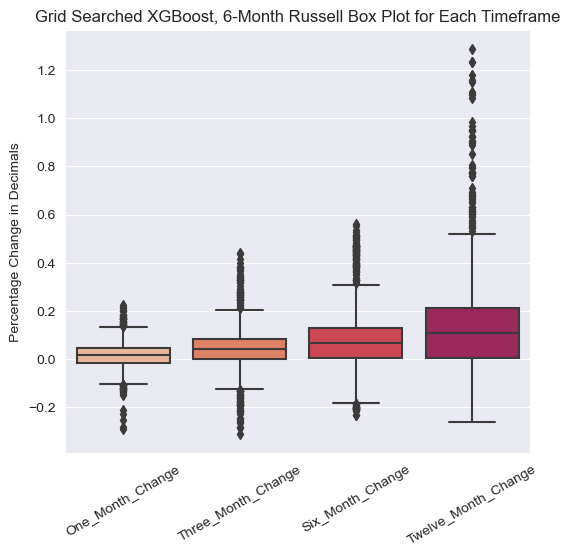

In [588]:
# Most precise model profile
describe_predictions(grid_R_6_month, ticker="^RUT", df=df, cat=1, box=True)["Six_Month_Change"]

count    2190.000000
mean        0.036901
std         0.147460
min        -0.368020
25%        -0.053754
50%         0.029617
75%         0.098294
max         0.561869
Name: Six_Month_Change, dtype: float64

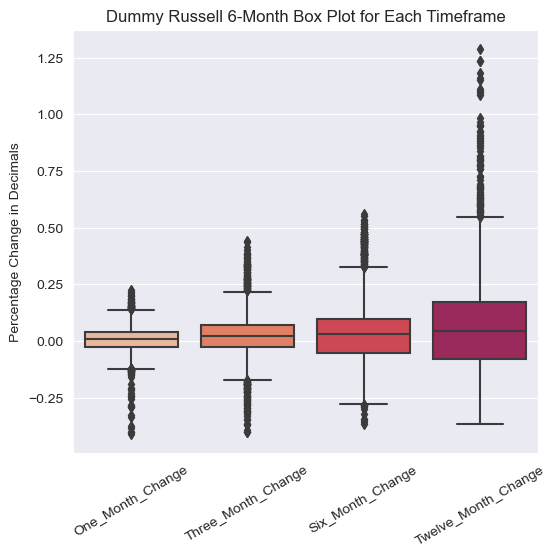

In [587]:
# Dummy Profile
describe_predictions(dummy_R_6_month, ticker="^RUT", df=df, cat=1, box=True)["Six_Month_Change"]

In [589]:
# Feature importances for the best model
features_from_trees(grid_R_6_month)
Importance.df[-4:]

Top 5 Feature Importances
('cycle_year_3', 0.14746934)
('cycle_year_1', 0.082521796)
('Month_2', 0.06952972)
('one_up_bollinger_band', 0.047258925)
('Quarter_1', 0.043879673)


Adj Close     Close      High       Low      Open    Volume  \
Nasdaq 12-Month  -0.810273 -0.810273  0.822179 -0.953719  0.764579  2.055675   
12                0.043152  0.039275  0.040822  0.041221  0.035546  0.028341   
13                0.025090  0.000000  0.031190  0.033704  0.008283  0.015352   
14                0.020275  0.000000  0.014127  0.023789  0.002481  0.004805   

                 GDP_Filled  Interest_Rates    Mkt-RF       SMB       HML  \
Nasdaq 12-Month    0.907857       -0.207416 -0.002636  0.006191  0.014644   
12                 0.049751        0.057220  0.014507  0.014305  0.016177   
13                 0.047566        0.025258  0.003485  0.002874  0.002428   
14                 0.042194        0.025409  0.002070  0.001719  0.001990   

                      RMW       CMA  garman_klass_vol       RSI  \
Nasdaq 12-Month -0.084120 -0.102678          0.302931  0.112460   
12               0.016086  0.015228          0.018359  0.037301   
13               0.003507  0.002291          0.002951  0.011018   
14               0.002259  0.001381          0.001355  0.009802   

                 lowest_bollinger_band  lower_bollinger_band  20_day_SMA  \
Nasdaq 12-Month               0.871870              0.569400    0.285341   
12                            0.053395              0.051143    0.049228   
13                            0.012739              0.027302    0.015041   
14                            0.003402              0.030652    0.032623   

                 one_up_bollinger_band  upper_bollinger_band       ATR  \
Nasdaq 12-Month               0.018578             -0.231993 -0.737287   
12                            0.053263              0.052491  0.056452   
13                            0.027065              0.026916  0.026417   
14                            0.047259              0.018815  0.007988   

                     MACD  ...  Quarter_4   Month_1  Month_10  Month_11  \
Nasdaq 12-Month  0.346030  ...   0.217534 -0.133116  0.040112  0.165960   
12               0.047878  ...   0.007289  0.007639  0.007100  0.005364   
13               0.017353  ...   0.063666  0.012911  0.009457  0.030539   
14               0.007873  ...   0.039613  0.011066  0.036873  0.004576   

                 Month_12   Month_2   Month_3   Month_4   Month_5   Month_6  \
Nasdaq 12-Month  0.011461  0.107573  0.103877 -0.185639  0.003266  0.325165   
12               0.005921  0.006196  0.006794  0.004665  0.004506  0.005149   
13               0.027129  0.015491  0.063639  0.021920  0.004216  0.006977   
14               0.035241  0.069530  0.021244  0.038526  0.005507  0.035647   

                  Month_7   Month_8   Month_9  cycle_year_1  cycle_year_2  \
Nasdaq 12-Month  0.118328  0.000432  0.051062     -0.552574      0.868574   
12               0.006381  0.003821  0.004668      0.006831      0.011914   
13               0.045248  0.026121  0.015470      0.083545      0.010311   
14               0.011229  0.016433  0.010042      0.082522      0.039720   

                 cycle_year_3  cycle_year_4  day_of_week_Friday  \
Nasdaq 12-Month      0.030702      0.261778            0.102821   
12                   0.006085      0.005458            0.001496   
13                   0.089622      0.027060            0.002643   
14                   0.147469      0.014440            0.000486   

                 day_of_week_Monday  day_of_week_Thursday  \
Nasdaq 12-Month            0.094305              0.152579   
12                         0.001745              0.001602   
13                         0.001363              0.001941   
14                         0.000970              0.000405   

                 day_of_week_Tuesday  day_of_week_Wednesday  
Nasdaq 12-Month             0.128159               0.130615  
12                          0.001515               0.001560  
13                          0.000983               0.001183  
14                          0.000169               0.000170  

[4 rows x 48 columns]

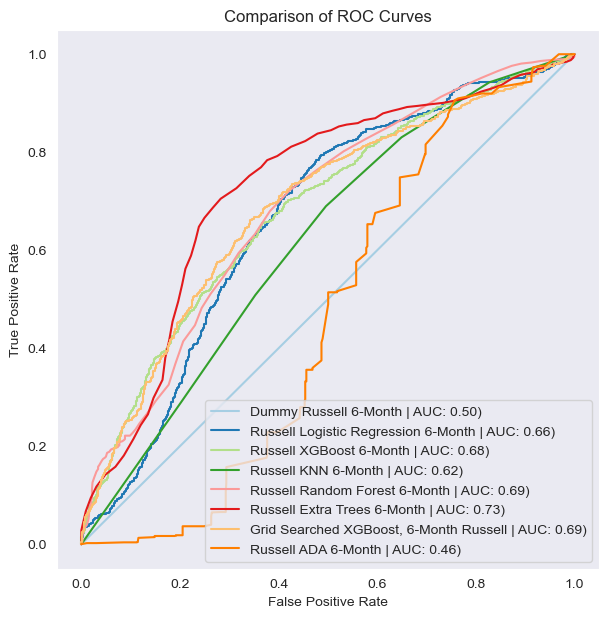

In [590]:
# Comparing model ROC curves

compare_curves([dummy_R_6_month, logreg_R_6_month, XGBoost_R_6_month, knn_R_6_month, rfc_R_6_month, etc_R_6_month, \
                grid_R_6_month, ada_R_6_month])

<hr style="border: 2px solid red;">

# 12 Month Russell 

In [596]:
# Create variables

X_train, X_test, y_train, y_test = select_data(rus_df, "Twelve")

# Create Model Objects

# dummy_R_12_month = dummy_model(Model, "Russell", 12)
# logreg_R_12_month = l_regr(Model, "Russell", 12)
# knn_R_12_month = knn(Model, "Russell", 12)
# ada_R_12_month = ada(Model, "Russell", 12)
# rfc_R_12_month = r_forest(Model, "Russell", 12)
# etc_R_12_month = extra_trees(Model, "Russell", 12)
# XGBoost_R_12_month = x_g_b(Model, "Russell", 12)

# grid_R_12_month = best_etc_grid(estimator=etc_R_12_month.model, model_type=Model, sector_name="Russell", time_period=12)
# lr_R_12_month = best_logreg_search(logreg_R_12_month.model, Model, "Russell", 12)

Model.model_df.iloc[127:].sort_values(by="test_prec", ascending=False)

name  train_accuracy  train_prec  \
128  Russell Logistic Regression 12-Month        0.545704    0.839355   
134    Grid Searched LR, 12-Month Russell        0.550457    0.853769   
131        Russell Random Forest 12-Month        0.573126    0.769715   
133              Russell XGBoost 12-Month        0.543327    0.748740   
130                  Russell ADA 12-Month        0.560878    0.784900   
132          Russell Extra Trees 12-Month        0.581353    0.778349   
127                Dummy Russell 12-Month        0.719196    0.719196   
129                  Russell KNN 12-Month        0.557404    0.744724   

     train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
128      0.449120  0.543925       4.150627       0.557078   0.958904   
134      0.447215  0.547066       4.420937       0.567580   0.932367   
131      0.714475  0.652219       1.489017       0.613242   0.631458   
133      0.701959  0.627260       2.410927       0.561187   0.620448   
130      0.698420  0.623002       0.773452       0.570320   0.605937   
132      0.716397  0.666192       1.614377       0.605479   0.605150   
127      1.000000  0.830141      10.121216       0.595890   0.595890   
129      0.708134  0.637749      14.063290       0.580822   0.589708   

     test_recall   test_f1  test_logloss       AUC  
128     0.268199  0.419162      1.301017  0.767375  
134     0.295785  0.449098      1.275158  0.767438  
131     0.842912  0.722022      0.660307  0.638071  
133     0.678927  0.648372      1.452391  0.530002  
130     0.797701  0.688720      0.689459  0.497982  
132     0.972414  0.746032      0.771699  0.578277  
127     1.000000  0.746781     14.565586  0.500000  
129     0.974713  0.734835      6.575071  0.568474

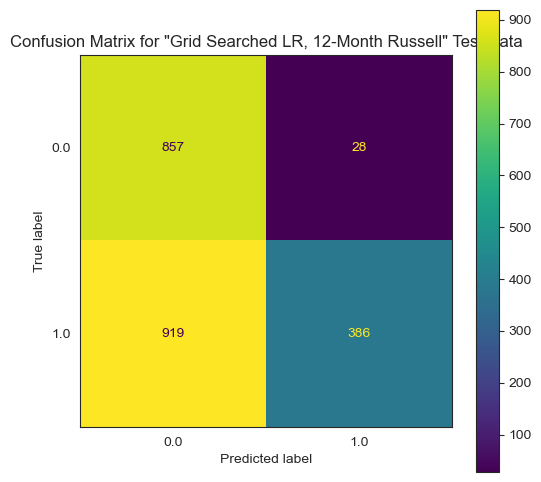

In [597]:
# Most practically useful model
lr_R_12_month.confusion_matrix()

### Results
Given LR's high train precision, I felt comfortable optimizing it, even though its test precision seems to be a bit of a fluke. The grid search also brought train and test closer together. The mean return of 20.5% is 13% higher than the dummy model. The max loss/gain are comparable, however everything else greatly favors the grid searched model. 

count    414.000000
mean       0.205744
std        0.207097
min       -0.332222
25%        0.093699
50%        0.188139
75%        0.248240
max        1.287814
Name: Twelve_Month_Change, dtype: float64

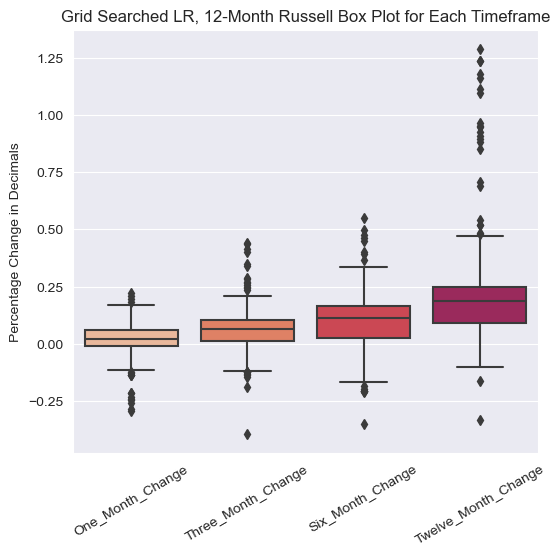

In [601]:
# Most precise model profile
describe_predictions(lr_R_12_month, ticker="^RUT", df=df, cat=1, box=True)["Twelve_Month_Change"]

count    2190.000000
mean        0.074063
std         0.221419
min        -0.366238
25%        -0.079436
50%         0.043478
75%         0.171534
max         1.287814
Name: Twelve_Month_Change, dtype: float64

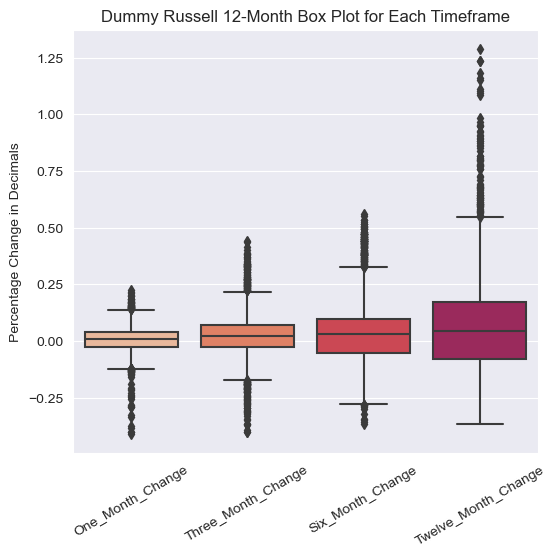

In [602]:
# Dummy Profile
describe_predictions(dummy_R_12_month, ticker="^RUT", df=df, cat=1, box=True)["Twelve_Month_Change"]

In [603]:
# Feature importances for the best model
coefs_from_lr(lr_R_12_month)
Importance.df[-4:]

Top 5 Feature Coefficients
('GDP_Filled', 8.738963749244313)
('dollar_volume(M)', 3.1463879708242697)
('upper_bollinger_band', 1.7050806656468271)
('one_up_bollinger_band', 0.718919388537773)
('cycle_year_4', 0.5880834264665141)


Adj Close     Close      High       Low      Open    Volume  GDP_Filled  \
12   0.043152  0.039275  0.040822  0.041221  0.035546  0.028341    0.049751   
13   0.025090  0.000000  0.031190  0.033704  0.008283  0.015352    0.047566   
14   0.020275  0.000000  0.014127  0.023789  0.002481  0.004805    0.042194   
15  -1.691731 -1.691731 -0.973673  0.254667 -1.095777 -4.337336    8.738964   

    Interest_Rates    Mkt-RF       SMB       HML       RMW       CMA  \
12        0.057220  0.014507  0.014305  0.016177  0.016086  0.015228   
13        0.025258  0.003485  0.002874  0.002428  0.003507  0.002291   
14        0.025409  0.002070  0.001719  0.001990  0.002259  0.001381   
15       -0.106552 -0.068792 -0.110701  0.023114 -0.139991 -0.028500   

    garman_klass_vol       RSI  lowest_bollinger_band  lower_bollinger_band  \
12          0.018359  0.037301               0.053395              0.051143   
13          0.002951  0.011018               0.012739              0.027302   
14          0.001355  0.009802               0.003402              0.030652   
15          0.500658  0.178898              -2.479225             -1.373074   

    20_day_SMA  one_up_bollinger_band  upper_bollinger_band       ATR  \
12    0.049228               0.053263              0.052491  0.056452   
13    0.015041               0.027065              0.026916  0.026417   
14    0.032623               0.047259              0.018815  0.007988   
15   -0.307026               0.718919              1.705081 -1.773009   

        MACD  ...  Quarter_4   Month_1  Month_10  Month_11  Month_12  \
12  0.047878  ...   0.007289  0.007639  0.007100  0.005364  0.005921   
13  0.017353  ...   0.063666  0.012911  0.009457  0.030539  0.027129   
14  0.007873  ...   0.039613  0.011066  0.036873  0.004576  0.035241   
15 -0.157948  ...   0.057794 -0.133844 -0.063250  0.126363 -0.005320   

     Month_2   Month_3   Month_4   Month_5   Month_6   Month_7   Month_8  \
12  0.006196  0.006794  0.004665  0.004506  0.005149  0.006381  0.003821   
13  0.015491  0.063639  0.021920  0.004216  0.006977  0.045248  0.026121   
14  0.069530  0.021244  0.038526  0.005507  0.035647  0.011229  0.016433   
15 -0.140818  0.461783 -0.036029  0.203291  0.086557  0.017598  0.027405   

     Month_9  cycle_year_1  cycle_year_2  cycle_year_3  cycle_year_4  \
12  0.004668      0.006831      0.011914      0.006085      0.005458   
13  0.015470      0.083545      0.010311      0.089622      0.027060   
14  0.010042      0.082522      0.039720      0.147469      0.014440   
15  0.228838     -0.089989      0.011264      0.263217      0.588083   

    day_of_week_Friday  day_of_week_Monday  day_of_week_Thursday  \
12            0.001496            0.001745              0.001602   
13            0.002643            0.001363              0.001941   
14            0.000486            0.000970              0.000405   
15            0.135185            0.069175              0.232852   

    day_of_week_Tuesday  day_of_week_Wednesday  
12             0.001515               0.001560  
13             0.000983               0.001183  
14             0.000169               0.000170  
15             0.165599               0.169765  

[4 rows x 48 columns]

In [604]:
Importance.df.rename(index={12:"Russell 2000 1-Month", 13:"Russell 2000 3-Month", 14:'Russell 2000 6-Month',\
                            15:"Russell 2000 12-Month"}, inplace=True)
Importance.df.tail(4)

Adj Close     Close      High       Low      Open  \
Russell 2000 1-Month    0.043152  0.039275  0.040822  0.041221  0.035546   
Russell 2000 3-Month    0.025090  0.000000  0.031190  0.033704  0.008283   
Russell 2000 6-Month    0.020275  0.000000  0.014127  0.023789  0.002481   
Russell 2000 12-Month  -1.691731 -1.691731 -0.973673  0.254667 -1.095777   

                         Volume  GDP_Filled  Interest_Rates    Mkt-RF  \
Russell 2000 1-Month   0.028341    0.049751        0.057220  0.014507   
Russell 2000 3-Month   0.015352    0.047566        0.025258  0.003485   
Russell 2000 6-Month   0.004805    0.042194        0.025409  0.002070   
Russell 2000 12-Month -4.337336    8.738964       -0.106552 -0.068792   

                            SMB       HML       RMW       CMA  \
Russell 2000 1-Month   0.014305  0.016177  0.016086  0.015228   
Russell 2000 3-Month   0.002874  0.002428  0.003507  0.002291   
Russell 2000 6-Month   0.001719  0.001990  0.002259  0.001381   
Russell 2000 12-Month -0.110701  0.023114 -0.139991 -0.028500   

                       garman_klass_vol       RSI  lowest_bollinger_band  \
Russell 2000 1-Month           0.018359  0.037301               0.053395   
Russell 2000 3-Month           0.002951  0.011018               0.012739   
Russell 2000 6-Month           0.001355  0.009802               0.003402   
Russell 2000 12-Month          0.500658  0.178898              -2.479225   

                       lower_bollinger_band  20_day_SMA  \
Russell 2000 1-Month               0.051143    0.049228   
Russell 2000 3-Month               0.027302    0.015041   
Russell 2000 6-Month               0.030652    0.032623   
Russell 2000 12-Month             -1.373074   -0.307026   

                       one_up_bollinger_band  upper_bollinger_band       ATR  \
Russell 2000 1-Month                0.053263              0.052491  0.056452   
Russell 2000 3-Month                0.027065              0.026916  0.026417   
Russell 2000 6-Month                0.047259              0.018815  0.007988   
Russell 2000 12-Month               0.718919              1.705081 -1.773009   

                           MACD  ...  Quarter_4   Month_1  Month_10  Month_11  \
Russell 2000 1-Month   0.047878  ...   0.007289  0.007639  0.007100  0.005364   
Russell 2000 3-Month   0.017353  ...   0.063666  0.012911  0.009457  0.030539   
Russell 2000 6-Month   0.007873  ...   0.039613  0.011066  0.036873  0.004576   
Russell 2000 12-Month -0.157948  ...   0.057794 -0.133844 -0.063250  0.126363   

                       Month_12   Month_2   Month_3   Month_4   Month_5  \
Russell 2000 1-Month   0.005921  0.006196  0.006794  0.004665  0.004506   
Russell 2000 3-Month   0.027129  0.015491  0.063639  0.021920  0.004216   
Russell 2000 6-Month   0.035241  0.069530  0.021244  0.038526  0.005507   
Russell 2000 12-Month -0.005320 -0.140818  0.461783 -0.036029  0.203291   

                        Month_6   Month_7   Month_8   Month_9  cycle_year_1  \
Russell 2000 1-Month   0.005149  0.006381  0.003821  0.004668      0.006831   
Russell 2000 3-Month   0.006977  0.045248  0.026121  0.015470      0.083545   
Russell 2000 6-Month   0.035647  0.011229  0.016433  0.010042      0.082522   
Russell 2000 12-Month  0.086557  0.017598  0.027405  0.228838     -0.089989   

                       cycle_year_2  cycle_year_3  cycle_year_4  \
Russell 2000 1-Month       0.011914      0.006085      0.005458   
Russell 2000 3-Month       0.010311      0.089622      0.027060   
Russell 2000 6-Month       0.039720      0.147469      0.014440   
Russell 2000 12-Month      0.011264      0.263217      0.588083   

                       day_of_week_Friday  day_of_week_Monday  \
Russell 2000 1-Month             0.001496            0.001745   
Russell 2000 3-Month             0.002643            0.001363   
Russell 2000 6-Month             0.000486            0.000970   
Russell 2000 12-Month            0.135185            0.069175   

                       day_of_we

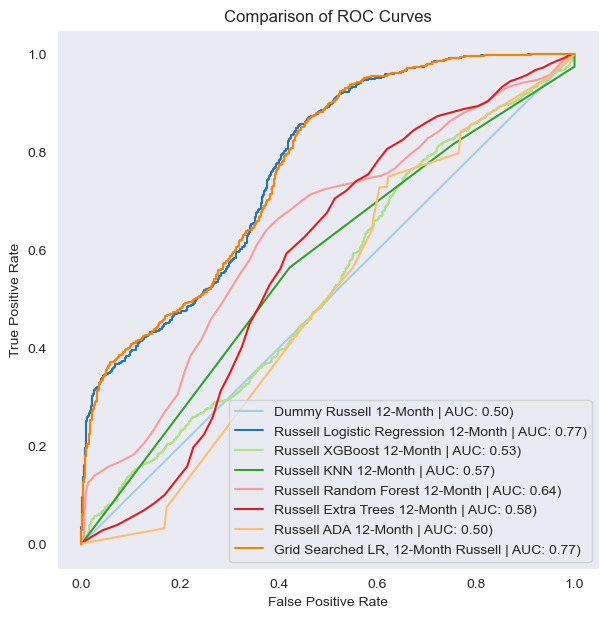

In [605]:
# Comparing model ROC curves

compare_curves([dummy_R_12_month, logreg_R_12_month, XGBoost_R_12_month, knn_R_12_month, rfc_R_12_month, etc_R_12_month, \
                ada_R_12_month, lr_R_12_month])

<hr style="border: 8px solid red;">

# Summary of Statistics

In [606]:
# Importances
Importance.df

Adj Close     Close      High       Low      Open  \
12-Month Dow            0.040632  0.037007  0.042715  0.037906  0.031394   
1-Month Dow             0.047910  0.046397  0.041861  0.044876  0.040230   
3-Month Dow             0.025346  0.000000  0.040976  0.014000  0.006188   
6-Month Dow             0.044568  0.042131  0.034391  0.040268  0.037906   
S&P 1-Month             0.044932  0.044793  0.043455  0.041550  0.025632   
S&P 3-Month             0.019316  0.000000  0.018866  0.012285  0.002937   
S&P 6-Month             0.041554  0.039364  0.039479  0.039635  0.022491   
S&P 12-Month            0.040410  0.041263  0.044003  0.044385  0.041698   
Nasdaq 1-Month          0.021892  0.000000  0.026331  0.026113  0.007612   
Nasdaq 3-Month          0.042290  0.043805  0.042763  0.042454  0.040857   
Nasdaq 6-Month          0.041900  0.041729  0.037509  0.042501  0.037971   
Nasdaq 12-Month        -0.810273 -0.810273  0.822179 -0.953719  0.764579   
Russell 2000 1-Month    0.043152  0.039275  0.040822  0.041221  0.035546   
Russell 2000 3-Month    0.025090  0.000000  0.031190  0.033704  0.008283   
Russell 2000 6-Month    0.020275  0.000000  0.014127  0.023789  0.002481   
Russell 2000 12-Month  -1.691731 -1.691731 -0.973673  0.254667 -1.095777   

                         Volume  GDP_Filled  Interest_Rates    Mkt-RF  \
12-Month Dow           0.022302    0.121256        0.099205  0.005304   
1-Month Dow            0.027051    0.049119        0.058243  0.016385   
3-Month Dow            0.007736    0.070060        0.033718  0.004473   
6-Month Dow            0.020627    0.082010        0.064318  0.007295   
S&P 1-Month            0.025253    0.037787        0.047341  0.013726   
S&P 3-Month            0.008108    0.052835        0.025877  0.003870   
S&P 6-Month            0.031403    0.092478        0.065941  0.006025   
S&P 12-Month           0.022166    0.085122        0.039196  0.003119   
Nasdaq 1-Month         0.008947    0.040414        0.023354  0.004780   
Nasdaq 3-Month         0.018702    0.055959        0.052240  0.005939   
Nasdaq 6-Month         0.018624    0.073396        0.056510  0.003868   
Nasdaq 12-Month        2.055675    0.907857       -0.207416 -0.002636   
Russell 2000 1-Month   0.028341    0.049751        0.057220  0.014507   
Russell 2000 3-Month   0.015352    0.047566        0.025258  0.003485   
Russell 2000 6-Month   0.004805    0.042194        0.025409  0.002070   
Russell 2000 12-Month -4.337336    8.738964       -0.106552 -0.068792   

                            SMB       HML       RMW       CMA  \
12-Month Dow           0.005326  0.007362  0.007724  0.010244   
1-Month Dow            0.015627  0.015127  0.015592  0.016332   
3-Month Dow            0.003492  0.002693  0.006508  0.005923   
6-Month Dow            0.006650  0.008046  0.008030  0.008023   
S&P 1-Month            0.013598  0.014276  0.014694  0.014226   
S&P 3-Month            0.003956  0.004274  0.003110  0.003619   
S&P 6-Month            0.005680  0.006364  0.007230  0.006941   
S&P 12-Month           0.002874  0.003756  0.003831  0.004000   
Nasdaq 1-Month         0.005429  0.004232  0.003717  0.003771   
Nasdaq 3-Month         0.006315  0.006787  0.006472  0.006670   
Nasdaq 6-Month         0.004416  0.004511  0.004420  0.004719   
Nasdaq 12-Month        0.006191  0.014644 -0.084120 -0.102678   
Russell 2000 1-Month   0.014305  0.016177  0.016086  0.015228   
Russell 2000 3-Month   0.002874  0.002428  0.003507  0.002291   
Russell 2000 6-Month   0.001719  0.001990  0.002259  0.001381   
Russell 2000 12-Month -0.110701  0.023114 -0.139991 -0.028500   

                       garman_klass_vol       RSI  lowest_bollinger_band  \
12-Month Dow                   0.006258  0.015604               0.039960   
1-Month Dow                    0.019209  0.041324               0.049670   
3-Month Dow                    0.004837  0.016786               0.024541   
6-Month Dow                    0.008472  0.022335               0.038930   
S&

In [607]:
# Top 10 Models overall
Model.model_df.sort_values(by="test_prec", ascending=False)[:10]

name  train_accuracy  train_prec  \
0        Logistic Regression 12-Month Dow        0.683594    0.854941   
8    Grid Searched AdaBoost, 12-Month Dow        0.627148    0.840793   
93                 Nasdaq XGBoost 6-Month        0.459963    0.725202   
92             Nasdaq Extra Trees 6-Month        0.441341    0.810572   
91           Nasdaq Random Forest 6-Month        0.420981    0.886803   
81           Nasdaq Random Forest 3-Month        0.421974    0.856567   
80                     Nasdaq ADA 3-Month        0.419615    0.737799   
99          Nasdaq Random Forest 12-Month        0.419119    0.882563   
115         Russell Random Forest 3-Month        0.430713    0.774128   
56                        S&P ADA 6-Month        0.556916    0.618279   

     train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
0        0.732000  0.720464       1.960234       0.287573   1.000000   
8        0.615627  0.605328       0.678889       0.273910   1.000000   
93       0.450656  0.487666       2.462279       0.246665   1.000000   
92       0.363589  0.391186       1.251987       0.287000   1.000000   
91       0.300380  0.322859       1.639239       0.246975   1.000000   
81       0.111338  0.181567       1.476217       0.284828   1.000000   
80       0.132751  0.199424       0.745363       0.284828   1.000000   
99       0.349044  0.394598       2.188283       0.199193   0.991453   
115      0.225770  0.299482       1.077262       0.462557   0.970060   
56       0.525326  0.530901       0.711559       0.312654   0.968085   

     test_recall   test_f1  test_logloss       AUC  
0       0.045336  0.086739     13.978651  0.723824  
8       0.027027  0.052632      0.703935  0.724061  
93      0.000412  0.000823      6.899825  0.572393  
92      0.053932  0.102344      1.591860  0.367604  
91      0.000823  0.001645      1.342506  0.579113  
81      0.006466  0.012848      1.330818  0.477383  
80      0.006466  0.012848      0.923068  0.493786  
99      0.043027  0.082474      2.117599  0.493191  
115     0.121439  0.215856      0.800743  0.636850  
56      0.067633  0.126433      0.925590  0.545897

# Best One Month Models by Precision

In [610]:
show_time_horizon(Model.model_df, "One")[:5]

name  train_accuracy  train_prec  \
74            Nasdaq Extra Trees 1-Month        0.443824    0.593768   
75                Nasdaq XGBoost 1-Month        0.438610    0.639323   
104  Russell Logistic Regression 1-Month        0.515356    0.635531   
109              Russell XGBoost 1-Month        0.452834    0.643019   
38                       S&P KNN 1-Month        0.550465    0.638533   

     train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
74       0.311006  0.325027       0.937284       0.381942   0.748175   
75       0.287570  0.330688       2.421975       0.423518   0.718447   
104      0.523023  0.526623       1.357447       0.500913   0.713615   
109      0.302803  0.359441       2.683115       0.467580   0.692580   
38       0.599647  0.585689       7.161653       0.452856   0.681569   

     test_recall   test_f1  test_logloss       AUC  
74      0.096335  0.170691      1.018656  0.505292  
75      0.208647  0.323379      2.281157  0.529563  
104     0.238431  0.357437      1.050861  0.578288  
109     0.153725  0.251605      2.770825  0.537978  
38      0.311250  0.427346      8.883984  0.514446

One_Month_Change  Three_Month_Change  Six_Month_Change  \
count        274.000000          274.000000        274.000000   
mean           0.028213            0.059982          0.101040   
std            0.047977            0.074630          0.118159   
min           -0.095549           -0.163356         -0.131485   
25%           -0.001872            0.003274         -0.011844   
50%            0.036765            0.065128          0.135189   
75%            0.062944            0.120602          0.195094   
max            0.155037            0.214887          0.332961   

       Twelve_Month_Change  
count           274.000000  
mean              0.155770  
std               0.088369  
min              -0.021716  
25%               0.076835  
50%               0.159172  
75%               0.227265  
max               0.353478

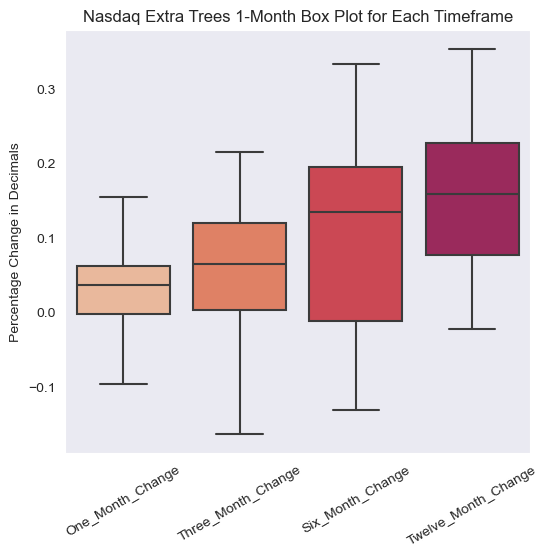

In [611]:
describe_predictions(Model.model_list[74], "^IXIC", df, box=True)

# Best Three Month Models

In [612]:
show_time_horizon(Model.model_df, "Three")[:5]

name  train_accuracy  train_prec  \
80                  Nasdaq ADA 3-Month        0.419615    0.737799   
81        Nasdaq Random Forest 3-Month        0.421974    0.856567   
115      Russell Random Forest 3-Month        0.430713    0.774128   
83              Nasdaq XGBoost 3-Month        0.417132    0.781422   
86   Grid Searched KNN, 3-Month Nasdaq        0.427561    0.754287   

     train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
80       0.132751  0.199424       0.745363       0.284828   1.000000   
81       0.111338  0.181567       1.476217       0.284828   1.000000   
115      0.225770  0.299482       1.077262       0.462557   0.970060   
83       0.163844  0.233159       3.362535       0.284518   0.888889   
86       0.168106  0.253199      14.084512       0.336333   0.785489   

     test_recall   test_f1  test_logloss       AUC  
80      0.006466  0.012848      0.923068  0.493786  
81      0.006466  0.012848      1.330818  0.477383  
115     0.121439  0.215856      0.800743  0.636850  
83      0.006897  0.013687      6.474900  0.491498  
86      0.107328  0.188851     19.468690  0.494840

One_Month_Change  Three_Month_Change  Six_Month_Change  \
count         15.000000           15.000000         15.000000   
mean           0.005978            0.067348         -0.000709   
std            0.047659            0.013956          0.045349   
min           -0.061637            0.049444         -0.079449   
25%           -0.037965            0.054440         -0.030305   
50%            0.012531            0.067859          0.012712   
75%            0.050289            0.077126          0.034345   
max            0.064379            0.095888          0.058306   

       Twelve_Month_Change  
count            15.000000  
mean              0.184206  
std               0.016321  
min               0.162224  
25%               0.168023  
50%               0.187885  
75%               0.196502  
max               0.212344

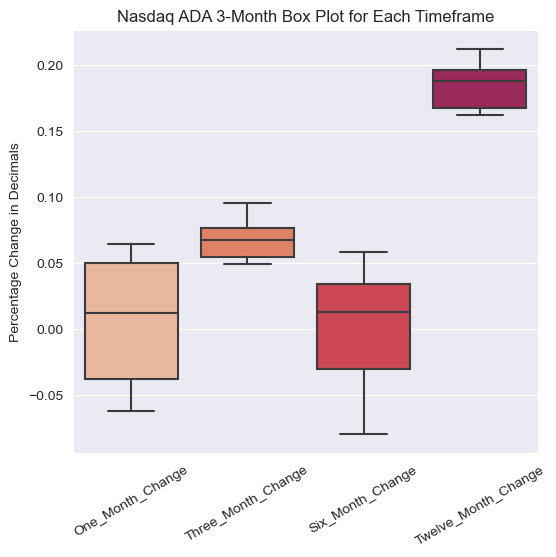

In [613]:
describe_predictions(Model.model_list[80], "^IXIC", df, box=True)

# Best Six Month Models

These 100% precision models predicted so infrequently, that they were essentially useless. Therefore, we will look at the S&P XGBoost model, #5 on this list.

In [614]:
show_time_horizon(Model.model_df, "Six")[:5]

name  train_accuracy  train_prec  train_recall  \
93        Nasdaq XGBoost 6-Month        0.459963    0.725202      0.450656   
92    Nasdaq Extra Trees 6-Month        0.441341    0.810572      0.363589   
91  Nasdaq Random Forest 6-Month        0.420981    0.886803      0.300380   
56               S&P ADA 6-Month        0.556916    0.618279      0.525326   
59           S&P XGBoost 6-Month        0.590049    0.801412      0.545386   

    train_f1  train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
93  0.487666       2.462279       0.246665   1.000000     0.000412  0.000823   
92  0.391186       1.251987       0.287000   1.000000     0.053932  0.102344   
91  0.322859       1.639239       0.246975   1.000000     0.000823  0.001645   
56  0.530901       0.711559       0.312654   0.968085     0.067633  0.126433   
59  0.616970       1.716813       0.333151   0.849582     0.113341  0.200000   

    test_logloss       AUC  
93      6.899825  0.572393  
92      1.591860  0.367604  
91      1.342506  0.579113  
56      0.925590  0.545897  
59      6.858042  0.490430

One_Month_Change  Three_Month_Change  Six_Month_Change  \
count        359.000000          359.000000        359.000000   
mean           0.018709            0.058810          0.134244   
std            0.073131            0.103136          0.125300   
min           -0.236412           -0.256315         -0.209492   
25%           -0.011213            0.014595          0.045081   
50%            0.029767            0.073495          0.124212   
75%            0.054792            0.115370          0.219586   
max            0.266108            0.393035          0.527456   

       Twelve_Month_Change  
count           359.000000  
mean              0.208103  
std               0.137057  
min              -0.023977  
25%               0.105748  
50%               0.177565  
75%               0.287753  
max               0.685734

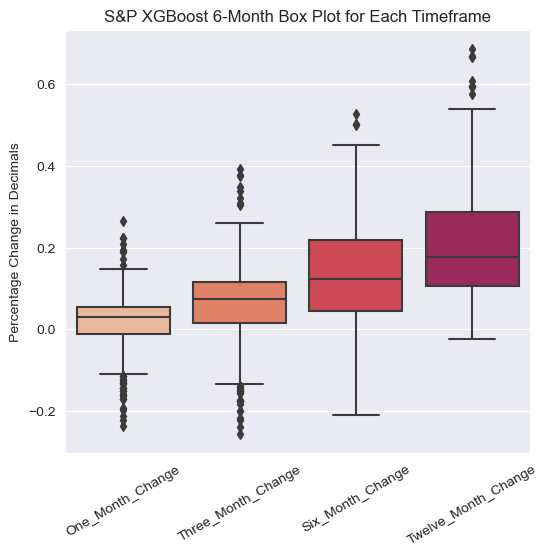

In [617]:
describe_predictions(Model.model_list[59], "^GSPC", df, box=True)

# Best Twelve Month Models

In [619]:
show_time_horizon(Model.model_df, "Twelve")[:5]

name  train_accuracy  train_prec  \
0       Logistic Regression 12-Month Dow        0.683594    0.854941   
8   Grid Searched AdaBoost, 12-Month Dow        0.627148    0.840793   
99         Nasdaq Random Forest 12-Month        0.419119    0.882563   
65            S&P Random Forest 12-Month        0.712630    0.822074   
62      S&P Logistic Regression 12-Month        0.687151    0.805254   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
0       0.732000  0.720464       1.960234       0.287573   1.000000   
8       0.615627  0.605328       0.678889       0.273910   1.000000   
99      0.349044  0.394598       2.188283       0.199193   0.991453   
65      0.782222  0.783162       0.579832       0.344630   0.961783   
62      0.767547  0.747811       2.852032       0.365400   0.960674   

    test_recall   test_f1  test_logloss       AUC  
0      0.045336  0.086739     13.978651  0.723824  
8      0.027027  0.052632      0.703935  0.724061  
99     0.043027  0.082474      2.117599  0.493191  
65     0.202821  0.334997      6.689677  0.551514  
62     0.229684  0.370732      9.813500  0.655202

One_Month_Change  Three_Month_Change  Six_Month_Change  \
count         52.000000           52.000000         52.000000   
mean           0.030676            0.095289          0.133131   
std            0.027360            0.007905          0.021230   
min           -0.017705            0.080292          0.090093   
25%            0.001598            0.090411          0.122759   
50%            0.040096            0.093496          0.133971   
75%            0.051209            0.099803          0.152574   
max            0.074236            0.120981          0.171240   

       Twelve_Month_Change  
count            52.000000  
mean              0.255253  
std               0.028064  
min               0.207027  
25%               0.233750  
50%               0.247570  
75%               0.282963  
max               0.316416

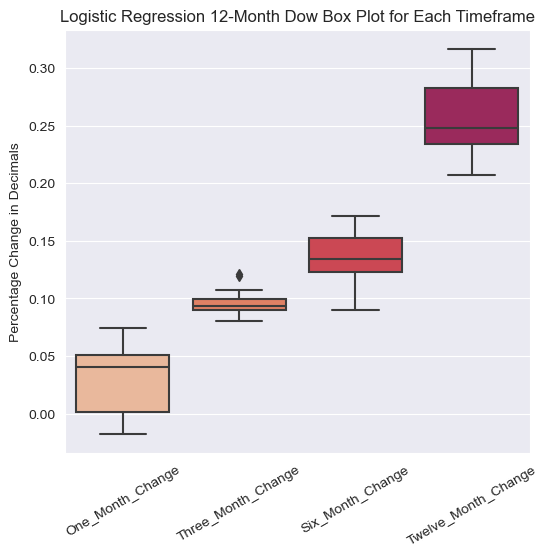

In [622]:
describe_predictions(Model.model_list[0], "^DJI", df, box=True)

In [630]:
def print_feature_importances(start, stop, interval=1, feats=5, data=Importance.df):
    for i in range(start, stop, interval):
        print("*" *40)
        print(f"Top {feats} Feature Importance(s):")
        print(data.iloc[i].sort_values(ascending=False)[:feats])

In [631]:
print_feature_importances(0, 16, 1, 5, Importance.df)

****************************************
Top 5 Feature Importance(s):
GDP_Filled              0.121256
Interest_Rates          0.099205
ATR                     0.046404
upper_bollinger_band    0.043800
lower_bollinger_band    0.043111
Name: 12-Month Dow, dtype: float64
****************************************
Top 5 Feature Importance(s):
Interest_Rates           0.058243
ATR                      0.052982
lowest_bollinger_band    0.049670
MACD                     0.049525
GDP_Filled               0.049119
Name: 1-Month Dow, dtype: float64
****************************************
Top 5 Feature Importance(s):
cycle_year_2            0.077669
GDP_Filled              0.070060
Month_7                 0.062181
Month_6                 0.060686
upper_bollinger_band    0.046542
Name: 3-Month Dow, dtype: float64
****************************************
Top 5 Feature Importance(s):
GDP_Filled        0.082010
Interest_Rates    0.064318
ATR               0.046635
Adj Close         0.044568
20_day_SM

# Conclusions:

There was a mixture of best models depending on the context. Tree based models XGBoost, AdaBoost, RFC, and ETC performed slightly better on shorter time horizons, and LogisticRegression performed a bit better on 12-month time horizons. One more key takeaway is that these models reinforce the ideas behind being a "Macro-economic" investor, given that the most important features were frequently GDP and Federal Interest Rates for both parametric and non-parametric models. When investing at the index level, if minimizing risk is your objective, staying out of the market when interest rates are rising is a good basic tenet to adhere to. Also noteable is that the target time period of the model is generally resistant to negative outliers, and therefore, these recommendations seem like very solid indicators. The relative infrequency of "buy" predictions means that rather than being your guide for decisions, these models would be a good cross-referencing resource. If you were to only wait for "buys" from the models, you would risk being under-invested, so only relying on these models would likely be a mistake as well. Using them as a supplementary resource seems like their primary value. While beating the dummy model on accuracy was difficult, the precise recommendations of the tuned models managed to produce better results than the dummy. 

In [632]:
# import pickle 

# with open('/Users/samalainabayeva/Desktop/Capstone Project/INDEX_classes_1.pkl', 'wb') as file:
#     pickle.dump(Model.model_list, file)

In [633]:
# Model.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/INDEX_CLASS_MODEL_DF.csv')

In [634]:
# Importance.df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/INDEX_IMPORTANCES.csv')